# Goat Format War League Analysis


## Table of Contents

1.  [Disclaimers](#disclaimers)
2.  [Setup](#setup)
    -   [Imports](#imports)
    -   [Query Base Data](#query-base-data)
3.  [Data Preparation](#data-preparation)
    -   [Data Cleaning](#data-cleaning)
    -   [Create Cards DataFrame](#create-cards-dataframe)
    -   [Feature Engineering](#feature-engineering)
        -   [Deck Partial Feature](#deck-partial-feature)
        -   [Side Type Feature](#side-type-feature)
4.  [Define "Other" Deck Type](#define-other-deck-type)
    -   [Deck Partial](#deck-partial)
    -   [Deck Type Confidence](#deck-type-confidence)
    -   [Partial and Confidence Regression](#partial-and-confidence-regression)
    -   [Interactive Confidence Session](#interactive-confidence-session)
5.  [Exploratory Data Analysis](#exploratory-data-analysis)
    -   [Match and Game Count](#match-and-game-count)
    -   [Deck Type Match Count](#deck-type-match-count)
    -   [Deck Type Match Count Across Seasons](#deck-type-match-count-across-seasons)
6.  [Win Rate Calculations](#win-rate-calculations)
    -   [Remove Low Samples](#remove-low-samples)
    -   [Laplace Smoothing](#laplace-smoothing)
    -   [Wilson Score Interval](#wilson-score-interval)
    -   [Bayesian Estimation](#bayesian-estimation)
    -   [What We'll Use](#what-well-use)
7.  [Deck Type Match Win Rate](#deck-type-match-win-rate)
    -   [Non-Mirror](#non-mirror)
    -   [Most Lopsided Matchups](#most-lopsided-matchups)
    -   [Matchup Matrix](#matchup-matrix)
    -   [Most Improved Matchups Across Seasons](#most-improved-matchups-across-seasons)
8.  [Deck Type Game Win Rate](#deck-type-game-win-rate)
    -   [Best Matchups When Going First](#best-matchups-when-going-first)
    -   [Best Matchups Preside vs Postside](#best-matchups-preside-vs-postside-1)
9.  [Card Game Win Rate](#card-game-win-rate)
    -   [Best and Worst Cards](#best-and-worst-cards-1)
    -   [Best and Worst Cards When Going First](#best-and-worst-cards-when-going-first)
    -   [Best and Worst Cards Preside](#best-and-worst-cards-preside)
    -   [Best and Worst Cards Postside](#best-and-worst-cards-postside)
    -   [Best Cards Preside vs Postside](#best-cards-preside-vs-postside-1)
10. [Chaos Turbo Analysis](#chaos-turbo-analysis)
    -   [Best and Worst Matchups](#best-and-worst-matchups)
    -   [Best Matchups Preside vs Postside](#best-matchups-preside-vs-postside-2)
    -   [Best and Worst Cards](#best-and-worst-cards-2)
    -   [Best Cards Preside vs Postside](#best-cards-preside-vs-postside-2)
    -   [Warrior Matchup](#warrior-matchup)
        -   [Match Win Rate](#match-win-rate)
        -   [Match Win Rate Across Seasons](#match-win-rate-across-seasons)
        -   [Game Win Rate](#game-win-rate)
        -   [Game Win Rate Across Seasons](#game-win-rate-across-seasons)
        -   [Game Win Rate Preside vs Postside](#game-win-rate-preside-vs-postside)
        -   [Best and Worst Cards](#best-and-worst-cards-2)
        -   [Best and Worst Cards Preside](#best-and-worst-cards-preside-2)
        -   [Best and Worst Cards Postside](#best-and-worst-cards-postside-2)
        -   [Best Cards Preside vs Postside](#best-cards-preside-vs-postside-2)
        -   [What Changed Between Season 5 and 6?](#what-changed-between-season-5-and-6)

## Disclaimers

- These games are from the Goat Format War League.
- Only seasons 1 through 6, in-season games. No playoffs or other tournaments.
- Doesn't include games from matches with multiple replays, eg. 1 match over multiple replays.
- Doesn't include the first 2 matches from s6, embed parsing laziness.
- All data are extracted from replays, eg:
  - Players are defined from their duelingbook names.
  - A deck type model is used to predict deck types based on cards seen.
- All "cards" data are from what were seen in the replay. This is defined as:
  - Cards drawn, milled, banished, etc. from deck.
  - This does not imply the card was played.
- As mentioned, some matches are not included. There's about 4000 matches total, can assume less than 20 were omitted.

## Setup

### Imports


In [433]:
import re
import textwrap

import pandas as pd
import polars as pl
import polars.selectors as cs
from plotnine import *

from notebooks.utils import remove_suffix, reorder_within

### Query Base Data


In [434]:
from gfwldata.utils.db import sync_engine

query = """
select
    g.id as game_id,
    lm.season as season,
    lm.week as week,
    lm.replay_id as replay_id,
    lm.replay_url as replay_url,
    g.player1 as player1,
    g.player2 as player2,
    g.player1_deck_type as player1_deck_type,
    g.player1_deck_type_confidence as player1_deck_type_confidence,
    g.player2_deck_type as player2_deck_type,
    g.player2_deck_type_confidence as player2_deck_type_confidence,
    g.player1_cards as player1_cards,
    g.player2_cards as player2_cards,
    g.game_number as game_number,
    g.game_winner as game_winner,
    g.went_first as went_first
from games g
    join league_matches lm on g.league_match_id = lm.id
"""

base_df = pl.read_database(query, connection=sync_engine)

with pl.Config(tbl_rows=2):
    print(base_df)

shape: (10_078, 16)
┌─────────────┬────────┬──────┬───────────┬───┬─────────────┬────────────┬────────────┬────────────┐
│ game_id     ┆ season ┆ week ┆ replay_id ┆ … ┆ player2_car ┆ game_numbe ┆ game_winne ┆ went_first │
│ ---         ┆ ---    ┆ ---  ┆ ---       ┆   ┆ ds          ┆ r          ┆ r          ┆ ---        │
│ str         ┆ i64    ┆ i64  ┆ i64       ┆   ┆ ---         ┆ ---        ┆ ---        ┆ str        │
│             ┆        ┆      ┆           ┆   ┆ str         ┆ i64        ┆ str        ┆            │
╞═════════════╪════════╪══════╪═══════════╪═══╪═════════════╪════════════╪════════════╪════════════╡
│ 691b9b2bd38 ┆ 1      ┆ 1    ┆ 37142193  ┆ … ┆ [{"card_nam ┆ 1          ┆ nice boy   ┆ nice boy   │
│ a48fa91e9cf ┆        ┆      ┆           ┆   ┆ e": "Don    ┆            ┆            ┆            │
│ e1917fa9…   ┆        ┆      ┆           ┆   ┆ Zaloog", "… ┆            ┆            ┆            │
│ …           ┆ …      ┆ …    ┆ …         ┆ … ┆ …           ┆ …        

## Data Preparation

### Data Cleaning

Only nulls are in game_winner. That's the expected behavior for draws.


In [435]:
base_df.null_count()

shape: (1, 16)
┌─────────┬────────┬──────┬───────────┬───┬───────────────┬─────────────┬─────────────┬────────────┐
│ game_id ┆ season ┆ week ┆ replay_id ┆ … ┆ player2_cards ┆ game_number ┆ game_winner ┆ went_first │
│ ---     ┆ ---    ┆ ---  ┆ ---       ┆   ┆ ---           ┆ ---         ┆ ---         ┆ ---        │
│ u32     ┆ u32    ┆ u32  ┆ u32       ┆   ┆ u32           ┆ u32         ┆ u32         ┆ u32        │
╞═════════╪════════╪══════╪═══════════╪═══╪═══════════════╪═════════════╪═════════════╪════════════╡
│ 0       ┆ 0      ┆ 0    ┆ 0         ┆ … ┆ 0             ┆ 0           ┆ 82          ┆ 0          │
└─────────┴────────┴──────┴───────────┴───┴───────────────┴─────────────┴─────────────┴────────────┘

Descriptive statistics of numeric columns:

- Seasons are between 1-6 ✅
- Weeks are between 1-15 ✅
- Model confidences are between 0-1 ✅
- Game numbers are greater than 1 ✅

Looks good overall.


In [436]:
print(
    base_df
    .select(cs.numeric() & cs.exclude("replay_id"))
    .describe()
)

shape: (9, 6)
┌────────────┬──────────┬──────────┬────────────────────────┬────────────────────────┬─────────────┐
│ statistic  ┆ season   ┆ week     ┆ player1_deck_type_conf ┆ player2_deck_type_conf ┆ game_number │
│ ---        ┆ ---      ┆ ---      ┆ idence                 ┆ idence                 ┆ ---         │
│ str        ┆ f64      ┆ f64      ┆ ---                    ┆ ---                    ┆ f64         │
│            ┆          ┆          ┆ f64                    ┆ f64                    ┆             │
╞════════════╪══════════╪══════════╪════════════════════════╪════════════════════════╪═════════════╡
│ count      ┆ 10078.0  ┆ 10078.0  ┆ 10078.0                ┆ 10078.0                ┆ 10078.0     │
│ null_count ┆ 0.0      ┆ 0.0      ┆ 0.0                    ┆ 0.0                    ┆ 0.0         │
│ mean       ┆ 3.421512 ┆ 6.438976 ┆ 0.91589                ┆ 0.916786               ┆ 1.86148     │
│ std        ┆ 1.64623  ┆ 3.51684  ┆ 0.153259               ┆ 0.152481       

Count deck classes.

In [437]:
print(
    base_df
    .unpivot(
        on=["player1_deck_type", "player2_deck_type"],
        index="game_id",
        value_name="deck_type"
    )
    .unique("deck_type")
    .sort("deck_type")
    ["deck_type"]
    .to_list()
)

['Bazoo Return', 'Cat OTK', 'Chaos Control', 'Chaos Recruiter', 'Chaos Return', 'Chaos Turbo', 'Chaos Warrior', 'Chaos Warrior Turbo', 'Dimension Fusion Turbo', 'Drain Burn', 'Earth Beat', 'Economics FTK', 'Flip Control', 'Flip Warrior', 'Gearfried', 'Goat Control', 'Gravekeeper', 'Mataza Rush', 'Panda Burn', 'Reasoning Gate Turbo', 'Relinquished', 'Stein Gate Turbo', 'Stein Monarch', 'Tiger Stun', 'Tomato Monarch', 'Warrior', 'Zombie']


Count cards:

- In `dp_unqiue_cards_df`, we can see that there are some non-goat-format cards. This is because an edison replay found it's way to our dataset.


In [438]:
# Base df of the exploded cards data
dp_base_cards_df = (
    base_df
    .unpivot(
        on=["player1_cards", "player2_cards"],
        index="game_id",
        value_name="cards"
    )
    .with_columns(
        cards=pl.col("cards").str.json_decode()
    )
    .explode("cards")
    .unnest("cards")
)

# Unique cards in base df
dp_unique_cards_df = (
    dp_base_cards_df
    .unique("card_name")
    .select("game_id", "variable", "card_name")
    .sort("card_name")
)

# game_id's with Edison cards
dp_edison_game_ids_list = (
    dp_unique_cards_df
    .filter(pl.col("card_name").str.contains("HERO|Emergency Call|Blackwing"))
    .unique("game_id")
    ["game_id"]
    .to_list()
)

with pl.Config(fmt_str_lengths=100):
    print(
        dp_unique_cards_df
        .filter(pl.col("game_id").is_in(dp_edison_game_ids_list))
        .group_by("game_id")
        .head(1)
    )

shape: (2, 3)
┌──────────────────────────────────┬───────────────┬────────────────────┐
│ game_id                          ┆ variable      ┆ card_name          │
│ ---                              ┆ ---           ┆ ---                │
│ str                              ┆ str           ┆ str                │
╞══════════════════════════════════╪═══════════════╪════════════════════╡
│ 59d96a3169f94a9fb26ae7ba0525bb3a ┆ player1_cards ┆ Aqua Madoor        │
│ c9d3150af45b46089cdcb9fc54d22653 ┆ player1_cards ┆ Allure of Darkness │
└──────────────────────────────────┴───────────────┴────────────────────┘


These edison replays are from seasons 1 and 6.

In [439]:
dp_edison_replays_to_remove = (
    base_df
    .filter(pl.col("game_id").is_in(dp_edison_game_ids_list))
    ["replay_url"]
    .to_list()
)

with pl.Config(fmt_str_lengths=100, tbl_width_chars=500):
    print(
        base_df
        .filter(pl.col("replay_url").is_in(dp_edison_replays_to_remove))
        .select("game_id", "season", "week", "replay_url", "player1", "player2")
    )

shape: (6, 6)
┌──────────────────────────────────┬────────┬──────┬────────────────────────────────────────────┬──────────────┬─────────────┐
│ game_id                          ┆ season ┆ week ┆ replay_url                                 ┆ player1      ┆ player2     │
│ ---                              ┆ ---    ┆ ---  ┆ ---                                        ┆ ---          ┆ ---         │
│ str                              ┆ i64    ┆ i64  ┆ str                                        ┆ str          ┆ str         │
╞══════════════════════════════════╪════════╪══════╪════════════════════════════════════════════╪══════════════╪═════════════╡
│ 59d96a3169f94a9fb26ae7ba0525bb3a ┆ 1      ┆ 4    ┆ https://duelingbook.com/replay?id=37729472 ┆ Gandhi's Sub ┆ lezhuendfox │
│ 45b4d4ed43ce4d0c943b8d0175d8fac7 ┆ 1      ┆ 4    ┆ https://duelingbook.com/replay?id=37729472 ┆ Gandhi's Sub ┆ lezhuendfox │
│ 82cc53960b184761880dc972f0192015 ┆ 1      ┆ 4    ┆ https://duelingbook.com/replay?id=37729472 ┆

Let's filter them out.

In [440]:
cleaned_base_df = (
    base_df
    .filter(~pl.col("replay_url").is_in(dp_edison_replays_to_remove))
)

### Create Cards DataFrame

We're going to unpivot, or melt, base_df to continue with the rest of our analysis.

FIrst, we'll create a match dataframe with the match's deck_type and confidence. A match's deck_type is going to be defined as the deck_type for game 1. Although, there's more data if we used all games in the match, it can give a bad prediction based on the side - especially smoke screens.


In [441]:
# Create match df
ccdf_match_df = (
    cleaned_base_df
    .sort(["replay_url", "game_number"])
    .group_by("replay_url")
    .agg(
        player1=pl.col("player1").first(),
        player2=pl.col("player2").first(),
        player1_match_score=pl.when(pl.col("game_winner") == pl.col("player1"))
            .then(pl.lit(1))
            .otherwise(pl.lit(0))
            .sum(),
        player2_match_score=pl.when(pl.col("game_winner") == pl.col("player2"))
            .then(pl.lit(1))
            .otherwise(pl.lit(0))
            .sum(),
        player1_match_deck_type=pl.col("player1_deck_type").first(),
        player1_match_deck_type_conf=pl.col("player1_deck_type_confidence").first(),
        player2_match_deck_type=pl.col("player2_deck_type").first(),
        player2_match_deck_type_conf=pl.col("player2_deck_type_confidence").first(),
        match_went_first=pl.col("went_first").first()
    )
    .with_columns(
        match_winner=pl.when(pl.col("player1_match_score") == 2)
            .then(pl.col("player1"))
            .otherwise(pl.col("player2"))
    )
    .drop(cs.contains("match_score"), "player1", "player2")
)

with pl.Config(tbl_rows=2, fmt_str_lengths=100):
    print(ccdf_match_df)

shape: (3_845, 7)
┌──────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ replay_url   ┆ player1_mat ┆ player1_mat ┆ player2_mat ┆ player2_mat ┆ match_went_ ┆ match_winne │
│ ---          ┆ ch_deck_typ ┆ ch_deck_typ ┆ ch_deck_typ ┆ ch_deck_typ ┆ first       ┆ r           │
│ str          ┆ e           ┆ e_conf      ┆ e           ┆ e_conf      ┆ ---         ┆ ---         │
│              ┆ ---         ┆ ---         ┆ ---         ┆ ---         ┆ str         ┆ str         │
│              ┆ str         ┆ f64         ┆ str         ┆ f64         ┆             ┆             │
╞══════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ https://duel ┆ Chaos Turbo ┆ 0.976       ┆ Chaos       ┆ 0.4917      ┆ nice boy    ┆ nice boy    │
│ ingbook.com/ ┆             ┆             ┆ Warrior     ┆             ┆             ┆             │
│ replay?id=37 ┆             ┆             ┆             ┆             ┆ 

Next, we'll join the match_df with cleaned_base_df for each player's tables. Then concat the results to unpivot the dataframe.


In [442]:
# Base columns for player dfs
ccdf_base_cols = [
    "game_id", "season", "week", "game_number", 
    "player", "player_deck_type", "player_deck_type_confidence", "player_cards", 
    "player_match_deck_type", "player_match_deck_type_conf",
    "opp", "opp_deck_type", "opp_deck_type_confidence", "opp_cards", 
    "opp_match_deck_type", "opp_match_deck_type_conf",
    "replay_url"
]

# Join match_df with cleaned_base_df as player's base_df
ccdf_base_df = (
    cleaned_base_df
    .join(
        ccdf_match_df,
        on="replay_url",
        how="left"
    )
)

# Create player1 df
ccdf_player1_df = (
    ccdf_base_df
    .rename(lambda col: re.sub("player1", "player", col))
    .rename(lambda col: re.sub("player2", "opp", col))
    .select([
        *ccdf_base_cols,
        pl.when(pl.col("game_winner") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_won"),
        pl.when(pl.col("went_first") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_went_first"),
        pl.when(pl.col("match_winner") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_won_match"),
        pl.when(pl.col("match_went_first") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_match_went_first"),
    ])
)

# Create player2 df
ccdf_player2_df = (
    ccdf_base_df
    .rename(lambda col: re.sub("player2", "player", col))
    .rename(lambda col: re.sub("player1", "opp", col))
    .select([
        *ccdf_base_cols,
        pl.when(pl.col("game_winner") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_won"),
        pl.when(pl.col("went_first") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_went_first"),
        pl.when(pl.col("match_winner") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_won_match"),
        pl.when(pl.col("match_went_first") == pl.col("player"))
            .then(pl.lit(True))
            .otherwise(pl.lit(False))
            .alias("player_match_went_first"),
    ])
)

# Concat players df's to unpivot cleaned_base_df
games_df = (
    pl
    .concat([ccdf_player1_df, ccdf_player2_df])
    .sort("replay_url")
)

print(
    games_df
    .head(4)
    .select("season", "week", "game_number", "player", "opp", "player_won", "player_won_match")
)

shape: (4, 7)
┌────────┬──────┬─────────────┬──────────┬──────────┬────────────┬──────────────────┐
│ season ┆ week ┆ game_number ┆ player   ┆ opp      ┆ player_won ┆ player_won_match │
│ ---    ┆ ---  ┆ ---         ┆ ---      ┆ ---      ┆ ---        ┆ ---              │
│ i64    ┆ i64  ┆ i64         ┆ str      ┆ str      ┆ bool       ┆ bool             │
╞════════╪══════╪═════════════╪══════════╪══════════╪════════════╪══════════════════╡
│ 1      ┆ 1    ┆ 1           ┆ nice boy ┆ Alisae   ┆ true       ┆ true             │
│ 1      ┆ 1    ┆ 2           ┆ nice boy ┆ Alisae   ┆ true       ┆ true             │
│ 1      ┆ 1    ┆ 1           ┆ Alisae   ┆ nice boy ┆ false      ┆ false            │
│ 1      ┆ 1    ┆ 2           ┆ Alisae   ┆ nice boy ┆ false      ┆ false            │
└────────┴──────┴─────────────┴──────────┴──────────┴────────────┴──────────────────┘


Next, we'll explode the player_cards columns so that we can do card analysis. We won't explode opp's cards because that'll create too many pairs of rows. We're only keeping opp_cards in the first place to filter for player_cards analysis, ie. we can keep it as a string and filter for patterns/cards.

In [443]:
cards_df = (
    games_df
    .with_columns(
        player_cards=pl.col("player_cards").str.json_decode()
    )
    .explode("player_cards")
    .unnest("player_cards")
    .rename({"card_name": "player_card_name", "card_amount": "player_card_amount"})
)

print(
    cards_df
    .select("game_id", "player", "player_card_name", "player_card_amount")
    .head(4)
)

shape: (4, 4)
┌─────────────────────────────────┬──────────┬────────────────────────────────┬────────────────────┐
│ game_id                         ┆ player   ┆ player_card_name               ┆ player_card_amount │
│ ---                             ┆ ---      ┆ ---                            ┆ ---                │
│ str                             ┆ str      ┆ str                            ┆ i64                │
╞═════════════════════════════════╪══════════╪════════════════════════════════╪════════════════════╡
│ 691b9b2bd38a48fa91e9cfe1917fa9… ┆ nice boy ┆ Black Luster Soldier - Envoy   ┆ 1                  │
│                                 ┆          ┆ o…                             ┆                    │
│ 691b9b2bd38a48fa91e9cfe1917fa9… ┆ nice boy ┆ Delinquent Duo                 ┆ 1                  │
│ 691b9b2bd38a48fa91e9cfe1917fa9… ┆ nice boy ┆ Gravekeeper's Spy              ┆ 2                  │
│ 691b9b2bd38a48fa91e9cfe1917fa9… ┆ nice boy ┆ Heavy Storm                   

### Feature Engineering

#### Deck Partial Feature

Let's start with `deck_partial` - this is the percent of cards seen from a deck, per game.

In [444]:
# Calculate player_deck_partial 
fe_dpf_base_df = (
    cards_df
    .group_by(["game_id", "player"])
    .agg(
        player_cards_seen=pl.col("player_card_amount").sum()
    )
    .with_columns(
        player_deck_partial=pl.when(pl.col("player_cards_seen") >= 40)
            .then(pl.lit(1))
            .otherwise((pl.col("player_cards_seen")/40))
    )
    .sort("game_id")
)

print(
    fe_dpf_base_df
    .head(4)
)

shape: (4, 4)
┌─────────────────────────────────┬─────────────┬───────────────────┬─────────────────────┐
│ game_id                         ┆ player      ┆ player_cards_seen ┆ player_deck_partial │
│ ---                             ┆ ---         ┆ ---               ┆ ---                 │
│ str                             ┆ str         ┆ i64               ┆ f64                 │
╞═════════════════════════════════╪═════════════╪═══════════════════╪═════════════════════╡
│ 000002e720a741ec816942bb14ec1f… ┆ IAMZ1       ┆ 13                ┆ 0.325               │
│ 000002e720a741ec816942bb14ec1f… ┆ tanasis     ┆ 17                ┆ 0.425               │
│ 00026898aae64b68922fc442a857a5… ┆ Ultra_Plant ┆ 20                ┆ 0.5                 │
│ 00026898aae64b68922fc442a857a5… ┆ Riksaah     ┆ 7                 ┆ 0.175               │
└─────────────────────────────────┴─────────────┴───────────────────┴─────────────────────┘


Let's check out the distribution of our new feature.

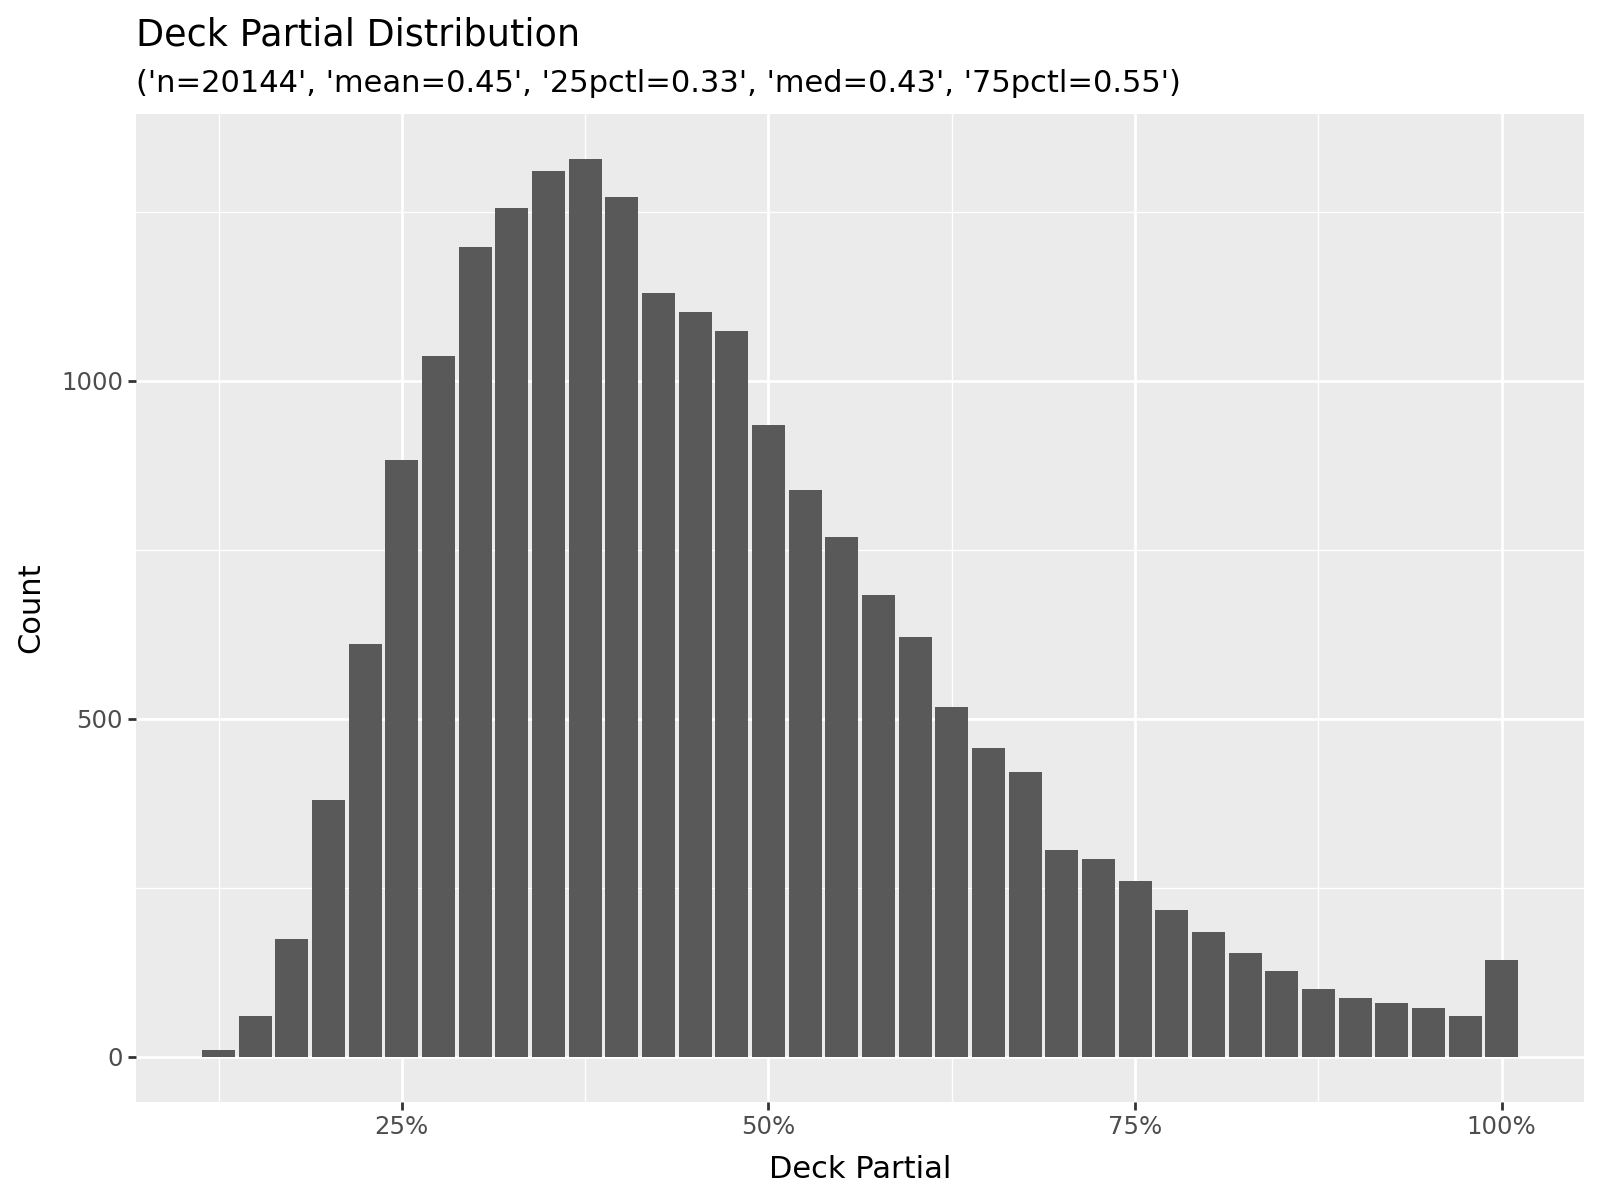

In [445]:
fe_dpf_plot_df = (
    fe_dpf_base_df
    .select("player_deck_partial")
    .describe()
    .with_columns(
        player_deck_partial=pl.col("player_deck_partial").round(2)
    )
)

(
    ggplot(
        fe_dpf_base_df,
        aes(x="player_deck_partial")
    )
    + geom_bar()
    + scale_x_continuous(labels=lambda x: [f"{(label*100):.0f}%" for label in x])
    + labs(
        title="Deck Partial Distribution",
        subtitle=(
            f"n={int(fe_dpf_plot_df[0,1])}",
            f"mean={fe_dpf_plot_df[2,1]}",
            f"25pctl={fe_dpf_plot_df[5,1]}",
            f"med={fe_dpf_plot_df[6,1]}",
            f"75pctl={fe_dpf_plot_df[7,1]}"
        ),
        x="Deck Partial",
        y="Count"
    )
    + theme(
        figure_size=(8, 6)
    )
)

We'll circle back to this feature later.

#### Side Type Feature

Next feature is `side_type`, this defines whether a game is a preside or postside game. Which of course, means that preside is defined as whenever game_number == 1, and post_side is whenever game_number is > 1.

In [446]:
fe_stf_base_df = (
    cards_df
    .with_columns(
        side_type=pl.when(pl.col("game_number") == 1)
            .then(pl.lit("preside"))
            .otherwise(pl.lit("postside"))
    )
    .select("game_id", "player", "game_number", "side_type")
    .unique()
    .sort("game_id")
)

print(
    fe_stf_base_df
    .head(4)
)

shape: (4, 4)
┌─────────────────────────────────┬─────────────┬─────────────┬───────────┐
│ game_id                         ┆ player      ┆ game_number ┆ side_type │
│ ---                             ┆ ---         ┆ ---         ┆ ---       │
│ str                             ┆ str         ┆ i64         ┆ str       │
╞═════════════════════════════════╪═════════════╪═════════════╪═══════════╡
│ 000002e720a741ec816942bb14ec1f… ┆ IAMZ1       ┆ 1           ┆ preside   │
│ 000002e720a741ec816942bb14ec1f… ┆ tanasis     ┆ 1           ┆ preside   │
│ 00026898aae64b68922fc442a857a5… ┆ Riksaah     ┆ 1           ┆ preside   │
│ 00026898aae64b68922fc442a857a5… ┆ Ultra_Plant ┆ 1           ┆ preside   │
└─────────────────────────────────┴─────────────┴─────────────┴───────────┘


Let's join these new features to our cards_df as featured_cards_df.

In [447]:
featured_cards_df = (
    cards_df
    .join(
        fe_dpf_base_df,
        on=["game_id", "player"],
        how="left"
    )
    .join(
        fe_stf_base_df,
        on=["game_id", "player", "game_number"],
        how="left"
    )
)

print(
    featured_cards_df
    .select("game_id", "player", "player_cards_seen", "player_deck_partial", "game_number", "side_type")
    .unique()
    .sort("game_id")
    .head(4)
)

shape: (4, 6)
┌───────────────────┬─────────────┬───────────────────┬──────────────────┬─────────────┬───────────┐
│ game_id           ┆ player      ┆ player_cards_seen ┆ player_deck_part ┆ game_number ┆ side_type │
│ ---               ┆ ---         ┆ ---               ┆ ial              ┆ ---         ┆ ---       │
│ str               ┆ str         ┆ i64               ┆ ---              ┆ i64         ┆ str       │
│                   ┆             ┆                   ┆ f64              ┆             ┆           │
╞═══════════════════╪═════════════╪═══════════════════╪══════════════════╪═════════════╪═══════════╡
│ 000002e720a741ec8 ┆ tanasis     ┆ 17                ┆ 0.425            ┆ 1           ┆ preside   │
│ 16942bb14ec1f…    ┆             ┆                   ┆                  ┆             ┆           │
│ 000002e720a741ec8 ┆ IAMZ1       ┆ 13                ┆ 0.325            ┆ 1           ┆ preside   │
│ 16942bb14ec1f…    ┆             ┆                   ┆                  ┆   

## Define "Other" Deck Type

Currently, our deck type model is trying to predict deck types based on the deck types it was trained on. There's many possible deck types that wasn't in that training data - eg. Empty Jar, Heavy Slump, etc. There's also decks that just doesn't fit any of these deck types and should just get lumped together in an "Other" class.

We'll define how to label "Other" via `player_deck_partial` and `{x}_deck_type_confidence` features.

### Deck Partial

Recall in [the deck_model notebook](../deck_model/README.md), we know how our model performed on out-of-sample decks at differential partial levels - 20, 40, 60, 80, and 100. We'll use those to build expectation given our data's partial distribution. Below is the chart of that performance curve:

![dodt-dp-model-performance-curve-chart](./images/model_accuracy_curve.png)

We've already started looking at our data's partial distribution [here](#feature-engineering), but let's see if the distribution changes by game number. This is important because we'll be labeling deck types by the game 1 prediction.

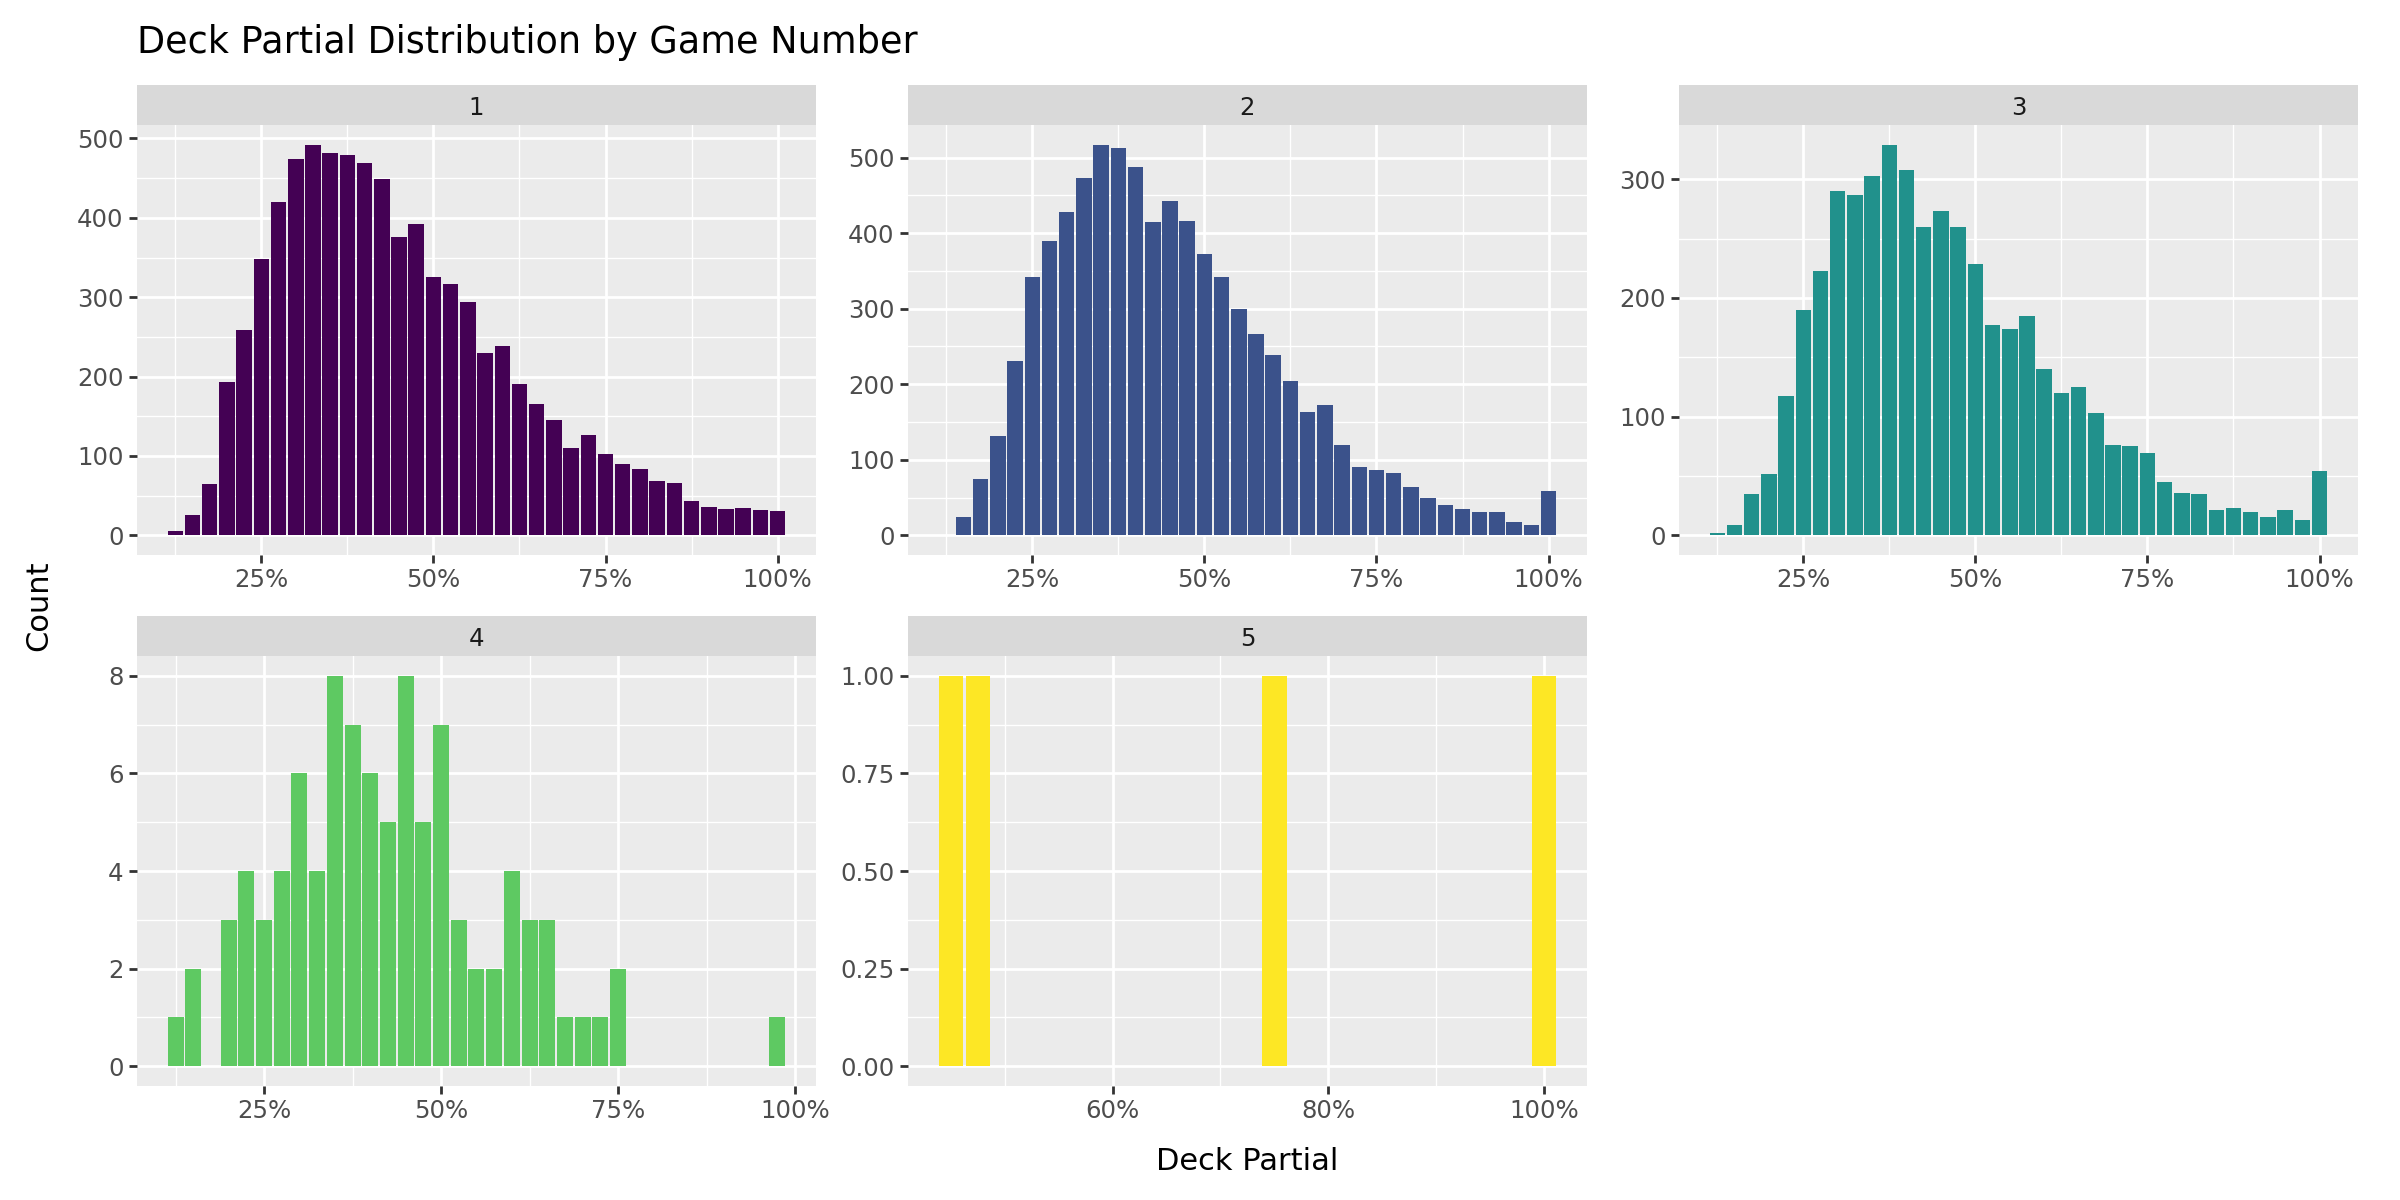

In [448]:
dodt_dp_plot_df = (
    featured_cards_df
    .select("game_id", "game_number", "player", "player_deck_partial")
    .unique()
)

(
    ggplot(
        dodt_dp_plot_df,
        aes(x="player_deck_partial", fill="game_number")
    )
    + geom_bar()
    + scale_fill_continuous(guide=None)
    + scale_x_continuous(labels=lambda x: [f"{(label*100):.0f}%" for label in x])
    + facet_wrap("game_number", scales="free")
    + labs(
        title="Deck Partial Distribution by Game Number",
        x="Deck Partial",
        y="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left"),
    )
)

The distributions are pretty consistent. Game 4 seems to have a greater mean, but that makes sense because the kind of deck's that tend to draw may be more stallish. That said, let's narrow down the statistics for the deck partial at game 1:

In [449]:
print(
    dodt_dp_plot_df
    .group_by("game_number")
    .agg(
        n=pl.col("player_deck_partial").len(),
        mean=pl.col("player_deck_partial").mean().round(3),
        p1=pl.col("player_deck_partial").quantile(.01),
        p5=pl.col("player_deck_partial").quantile(.05),
        p25=pl.col("player_deck_partial").quantile(.25),
        p50=pl.col("player_deck_partial").quantile(.50),
        p75=pl.col("player_deck_partial").quantile(.75)
    )
    .sort("game_number")
)

shape: (5, 8)
┌─────────────┬──────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ game_number ┆ n    ┆ mean  ┆ p1    ┆ p5    ┆ p25   ┆ p50   ┆ p75   │
│ ---         ┆ ---  ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   │
│ i64         ┆ u32  ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ f64   ┆ f64   │
╞═════════════╪══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 1           ┆ 7690 ┆ 0.452 ┆ 0.175 ┆ 0.225 ┆ 0.325 ┆ 0.425 ┆ 0.55  │
│ 2           ┆ 7660 ┆ 0.452 ┆ 0.175 ┆ 0.225 ┆ 0.325 ┆ 0.425 ┆ 0.55  │
│ 3           ┆ 4694 ┆ 0.462 ┆ 0.2   ┆ 0.25  ┆ 0.325 ┆ 0.425 ┆ 0.575 │
│ 4           ┆ 96   ┆ 0.426 ┆ 0.15  ┆ 0.2   ┆ 0.325 ┆ 0.425 ┆ 0.5   │
│ 5           ┆ 4    ┆ 0.669 ┆ 0.45  ┆ 0.45  ┆ 0.475 ┆ 0.75  ┆ 0.75  │
└─────────────┴──────┴───────┴───────┴───────┴───────┴───────┴───────┘


The median is at 42%. Based on our model's performance curve, a 40% deck partial should give us a model accuracy of about 90%. But, there's some caveats. That performance curve was based on the model predicting out-of-sample decks, within the deck classes that the model is aware of. There's going to be deck types in our gfwl data that the model would have no idea about. This should make the accuracy a bit lower but atleast we know what to expect.

### Deck Type Confidence

Let's follow this up with an analysis on the model's prediction confidence. In the [deck_model_demo notebook](../deck_model_demo/README.md), we looked at examples sorted by confidence. It's small sample, but typically when the model is confident (90%+), it tends to be accurate - to the point that it tends to correct mislableings from our training data. 

However, confidence thresholds for an "Other" class is going to vary. Let's first look at the confidence's distribution:

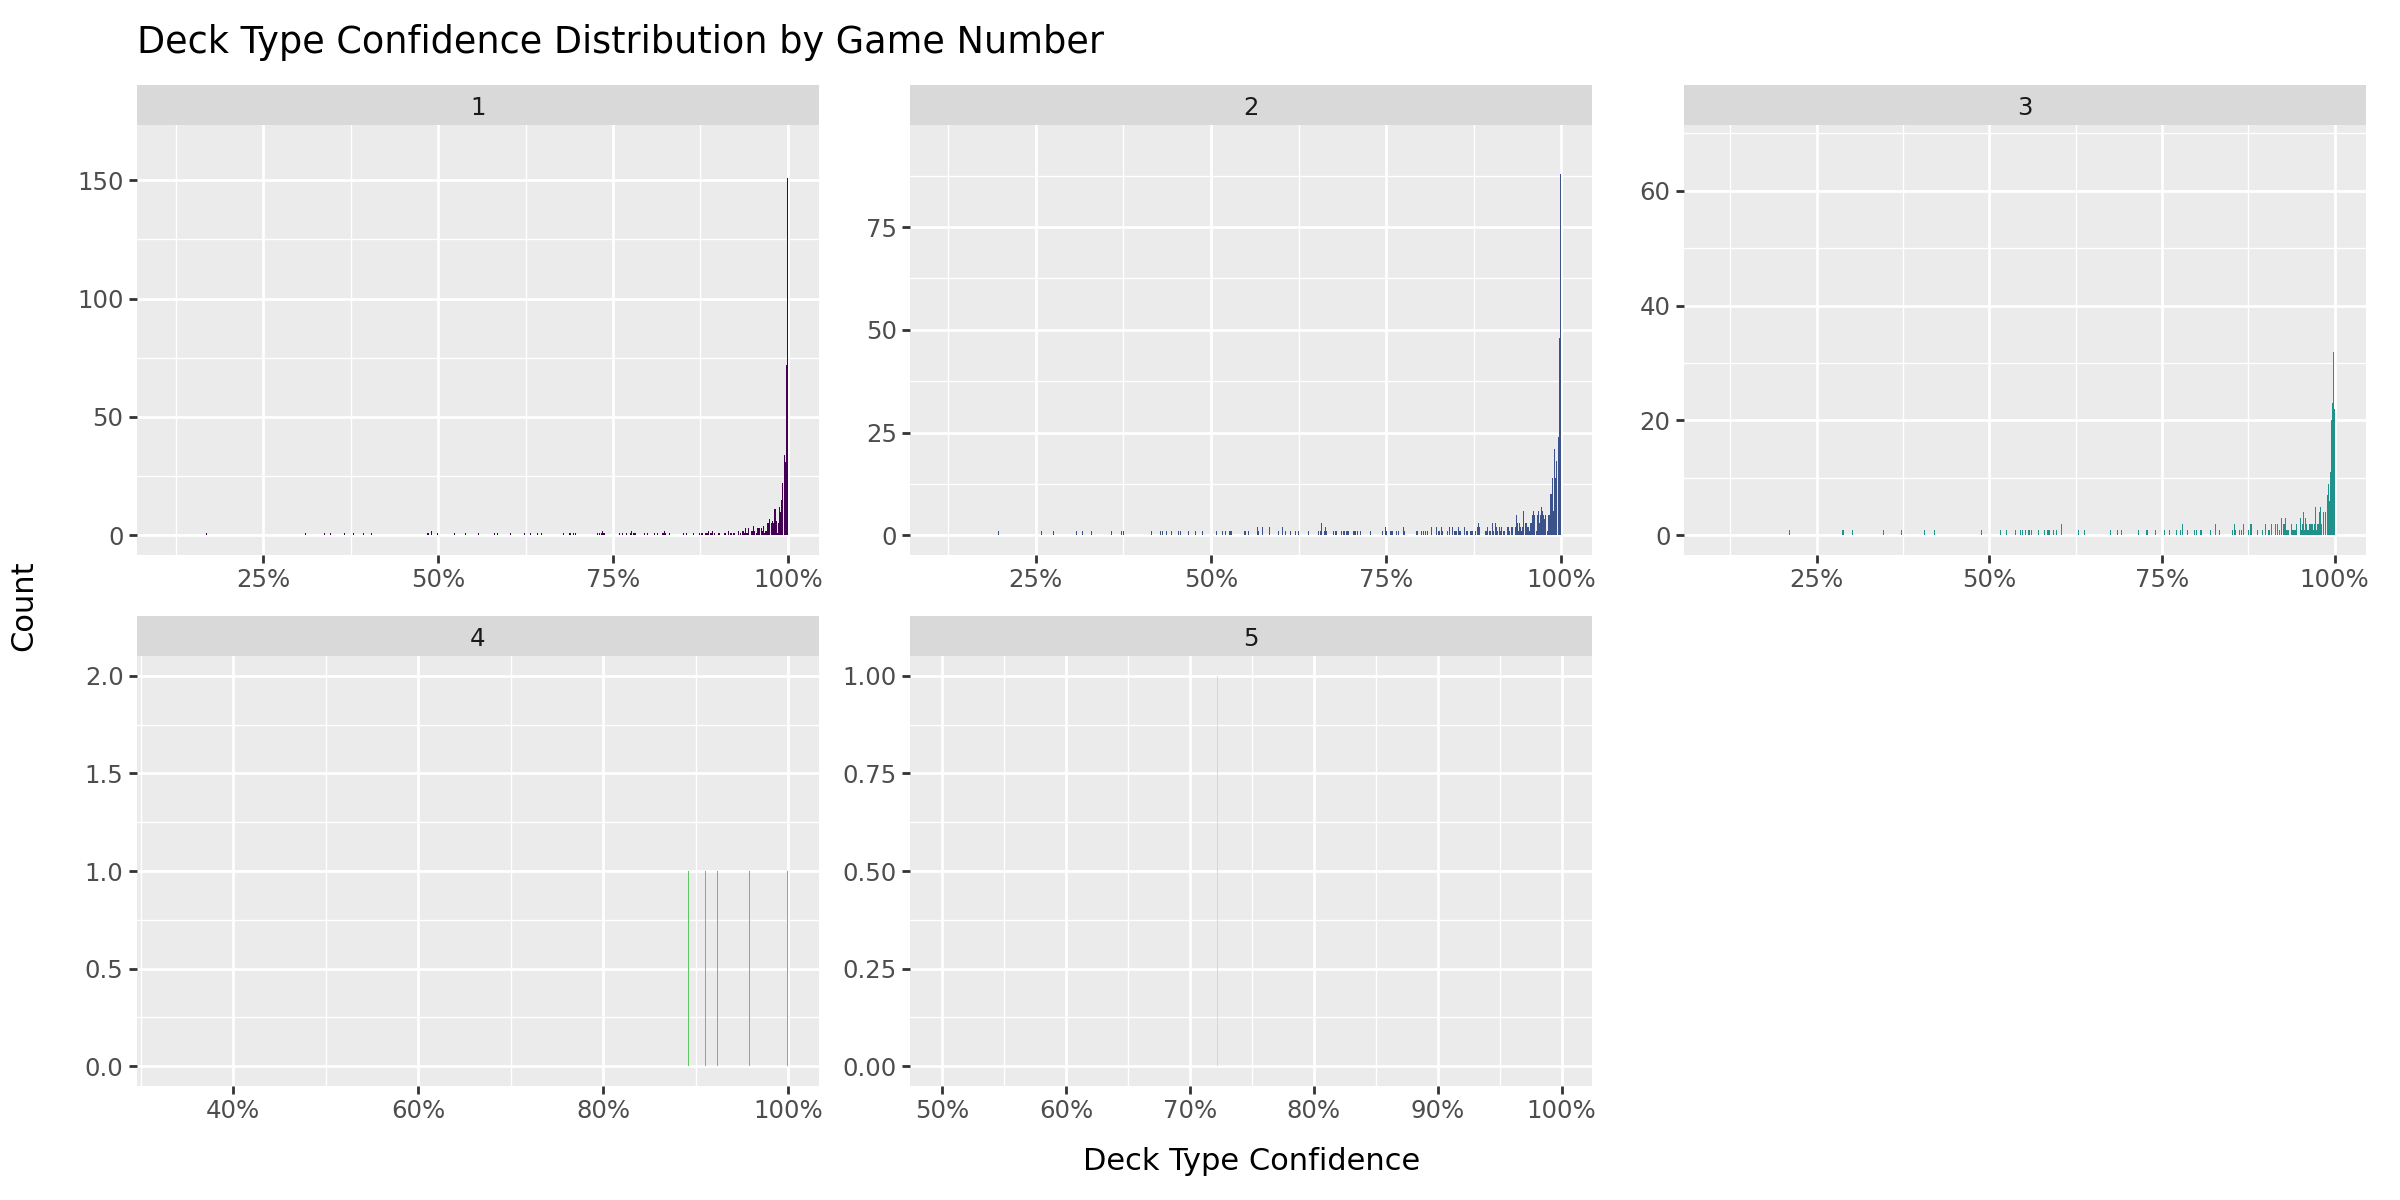

In [450]:
# We don't need to unpivot on player and opp confidence because opp's data are also in player columns
dodt_dtc_plot_df = (
    games_df
    .select("game_id", "game_number", "player_deck_type_confidence")
)

(
    ggplot(
        dodt_dtc_plot_df,
        aes(x="player_deck_type_confidence", fill="game_number")
    )
    + geom_bar()
    + scale_fill_continuous(guide=None)
    + scale_x_continuous(labels=lambda x: [f"{(label*100):.0f}%" for label in x])
    + facet_wrap("game_number", scales="free")
    + labs(
        title="Deck Type Confidence Distribution by Game Number",
        x="Deck Type Confidence",
        y="Count"
    )
    + theme(
        figure_size=(12, 6),
        title=element_text(ha="left"),
        axis_title=element_text(ha="center")
    )
)

The deck type confidence has a strong left skewed distribution. Let's look at the numbers:

In [451]:
print(
    dodt_dtc_plot_df
    .group_by("game_number")
    .agg(
        n=pl.col("player_deck_type_confidence").len(),
        mean=pl.col("player_deck_type_confidence").mean().round(3),
        p1=pl.col("player_deck_type_confidence").quantile(.01),
        p5=pl.col("player_deck_type_confidence").quantile(.05),
        p25=pl.col("player_deck_type_confidence").quantile(.25),
        p50=pl.col("player_deck_type_confidence").quantile(.50),
        p75=pl.col("player_deck_type_confidence").quantile(.75)
    )
    .sort("game_number")
)

shape: (5, 8)
┌─────────────┬──────┬───────┬────────┬────────┬────────┬────────┬────────┐
│ game_number ┆ n    ┆ mean  ┆ p1     ┆ p5     ┆ p25    ┆ p50    ┆ p75    │
│ ---         ┆ ---  ┆ ---   ┆ ---    ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ i64         ┆ u32  ┆ f64   ┆ f64    ┆ f64    ┆ f64    ┆ f64    ┆ f64    │
╞═════════════╪══════╪═══════╪════════╪════════╪════════╪════════╪════════╡
│ 1           ┆ 7690 ┆ 0.936 ┆ 0.3495 ┆ 0.5955 ┆ 0.9558 ┆ 0.9921 ┆ 0.9981 │
│ 2           ┆ 7660 ┆ 0.903 ┆ 0.2916 ┆ 0.5224 ┆ 0.8935 ┆ 0.9822 ┆ 0.9964 │
│ 3           ┆ 4694 ┆ 0.908 ┆ 0.3007 ┆ 0.5257 ┆ 0.9025 ┆ 0.9835 ┆ 0.9967 │
│ 4           ┆ 96   ┆ 0.893 ┆ 0.4521 ┆ 0.5375 ┆ 0.8638 ┆ 0.9764 ┆ 0.9963 │
│ 5           ┆ 4    ┆ 0.805 ┆ 0.4991 ┆ 0.4991 ┆ 0.7222 ┆ 0.9992 ┆ 0.9992 │
└─────────────┴──────┴───────┴────────┴────────┴────────┴────────┴────────┘


### Partial and Confidence Regression

Let's see the relationship between these features.

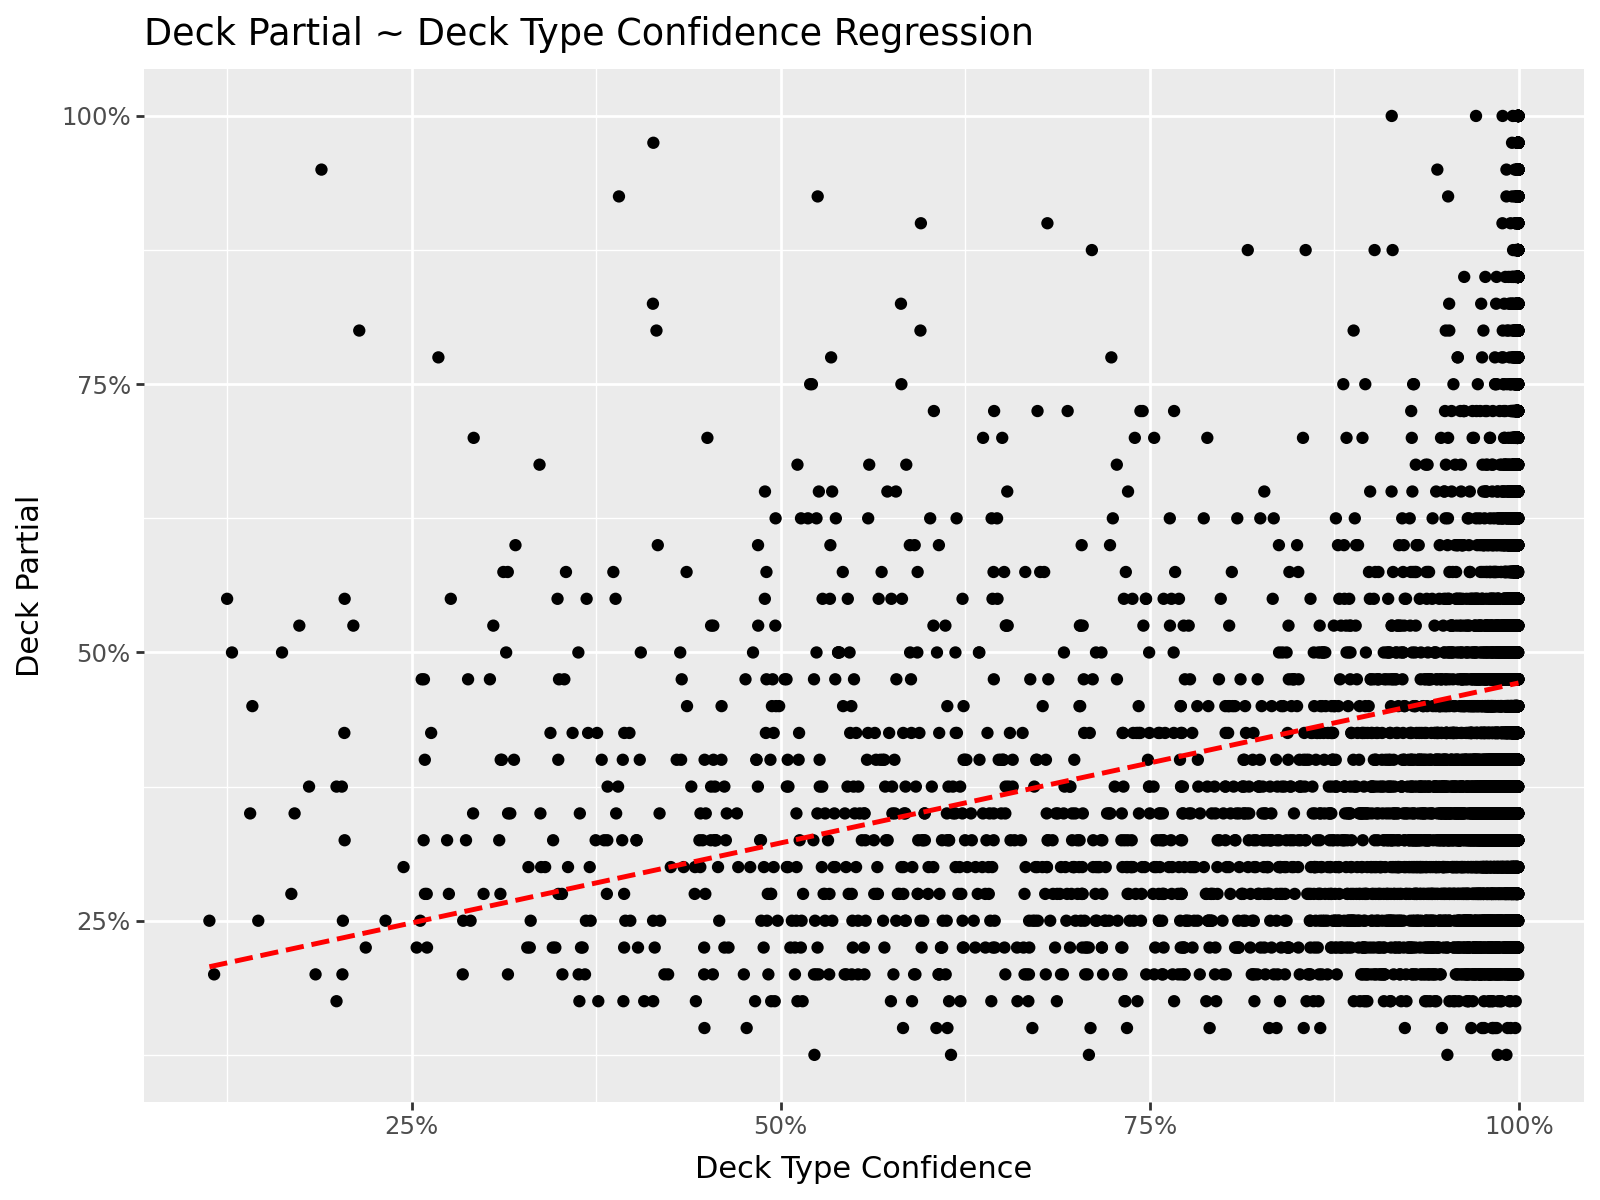

In [452]:
dodt_pcr_plot_df = (
    featured_cards_df
    .filter(pl.col("game_number") == 1)
    .select("game_id", "player_deck_type_confidence", "player_deck_partial")
    .unique()
)

(
    ggplot(
        dodt_pcr_plot_df,
        aes(x="player_deck_type_confidence", y="player_deck_partial")
    )
    + geom_point()
    + geom_smooth(method="lm", se=False, color="red", linetype="dashed")
    + scale_x_continuous(labels=lambda x: [f"{(label*100):.0f}%" for label in x])
    + scale_y_continuous(labels=lambda x: [f"{(label*100):.0f}%" for label in x])
    + labs(
        title="Deck Partial ~ Deck Type Confidence Regression",
        x="Deck Type Confidence",
        y="Deck Partial"
    )
    + theme(
        figure_size=(8, 6),
        plot_title=element_text(ha="left")
    )
)

There's a positive relationship but big residuals at higher confidence levels. Can't just use this regression model to predict deck partial at a specific deck type confidence, and then use that predicted deck partial to guage model accuracy.

Instead, we'll have to look at the data case-by-case, from low confidence, and see what to expect and what a good 'Other' threshold would be.

### Interactive Confidence Session

**THIS SECTION IS NOT AVAILABLE THROUGH THE README, ONLY VIDEO DEMONSTRATION**

Let's actually take a look at how lower confidence ranges impact prediction accuracy with this interactive session.

First, let's create our `print_low_confidence_games` function. 

In [453]:
# from IPython.display import clear_output

# # Base confidence df for print_low_confidence_games function
# dodt_ics_base_df = (
#     featured_cards_df
#     .filter(pl.col("game_number") == 1)
#     .select("game_id", "player", "player_deck_type", "player_deck_type_confidence", "player_card_name", "player_card_amount", "player_deck_partial")
#     .rename(lambda col: re.sub("player_", "", col))
#     .with_columns(
#         id=pl.concat_str(pl.col("game_id"), pl.col("player"), separator="_")
#     )
#     .drop("game_id")
#     .sort("deck_type_confidence")
# )


# def print_low_confidence_games() -> None:
#     ids = dodt_ics_base_df.select("id").unique(maintain_order=True)["id"].to_list()
    
#     for game in range(1, len(ids)+1):
#         clear_output(wait=True)
        
#         id = ids[game]
#         with pl.Config(tbl_rows=-1, set_tbl_width_chars=500, fmt_str_lengths=100):
#             print(
#                 f"{game} of {len(ids)} games",
#                 dodt_ics_base_df
#                 .filter(pl.col("id") == id)
#                 .filter(pl.col("player") == pl.col("player").first())
#                 .drop("id"),
#                 sep="\n"
#             )
        
#         cmd = input("Press Enter to continue or type 'cancel' to cancel: ")
#         if cmd.strip().lower() == 'cancel':
#             print("Loop canceled.")
#             break

In [454]:
# print_low_confidence_games()

Given what we've looked at so far between deck partial and confidence, let's define "Other" as decks with a confidence lower than 50%.

Let's go ahead and adjust deck type with the new "Other" class.

In [455]:
# Final cards dataframe for rest of analysis
final_cards_df = (
    featured_cards_df
    .with_columns(
        player_deck_type=pl.when(pl.col("player_deck_type_confidence") <= .5)
            .then(pl.lit("Other"))
            .otherwise(pl.col("player_deck_type")),
        player_match_deck_type=pl.when(pl.col("player_match_deck_type_conf") <= .5)
            .then(pl.lit("Other"))
            .otherwise(pl.col("player_match_deck_type")),
        opp_deck_type=pl.when(pl.col("opp_deck_type_confidence") <= .5)
            .then(pl.lit("Other"))
            .otherwise(pl.col("opp_deck_type_confidence")),
        opp_match_deck_type=pl.when(pl.col("opp_match_deck_type_conf") <= .5)
            .then(pl.lit("Other"))
            .otherwise(pl.col("opp_match_deck_type"))
    )
)

print(
    final_cards_df
    .select("player", "player_deck_type", "player_deck_type_confidence")
    .filter(pl.col("player_deck_type_confidence") <= .5)
    .head(2)
)

shape: (2, 3)
┌────────┬──────────────────┬─────────────────────────────┐
│ player ┆ player_deck_type ┆ player_deck_type_confidence │
│ ---    ┆ ---              ┆ ---                         │
│ str    ┆ str              ┆ f64                         │
╞════════╪══════════════════╪═════════════════════════════╡
│ Alisae ┆ Other            ┆ 0.4917                      │
│ Alisae ┆ Other            ┆ 0.4917                      │
└────────┴──────────────────┴─────────────────────────────┘


Let's also update the games_df to the final_games_df.

In [456]:
columns_to_change = ["player_deck_type", "player_match_deck_type", "opp_deck_type", "opp_match_deck_type"]

# Final games dataframe
final_games_df = (
    games_df
    .drop(columns_to_change)
    .join(
        other=final_cards_df
            .select("game_id", *columns_to_change)
            .unique("game_id"),
        on="game_id",
        how="left"
    )
)

## Exploratory Data Analysis

### Match and Game Count

In [457]:
eda_mgc_base_df = (
    final_cards_df
    .select("season", "replay_url", "game_number")
    .unique()
)

eda_mgc_game_count = (
    eda_mgc_base_df
    .group_by("season", "game_number")
    .len("count")
    .with_columns(
        game_number=pl.concat_str(pl.lit("g"), pl.col("game_number"), pl.lit("_count"))
    )
    .pivot(
        on="game_number",
        index="season",
        values="count"
    )
    .select("season", "g1_count", "g2_count", "g3_count", "g4_count", "g5_count")
)

print(
    eda_mgc_base_df
    .unique(["season", "replay_url"])
    .group_by("season")
    .len("match_count")
    .join(
        eda_mgc_game_count,
        on="season",
        how="left"
    )
    .with_columns(
        total_game_count=pl.sum_horizontal(cs.contains("g"))
    )
    .sort("season")
)


shape: (6, 8)
┌────────┬─────────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────────────┐
│ season ┆ match_count ┆ g1_count ┆ g2_count ┆ g3_count ┆ g4_count ┆ g5_count ┆ total_game_count │
│ ---    ┆ ---         ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---              │
│ i64    ┆ u32         ┆ u32      ┆ u32      ┆ u32      ┆ u32      ┆ u32      ┆ u32              │
╞════════╪═════════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════════════╡
│ 1      ┆ 559         ┆ 559      ┆ 554      ┆ 342      ┆ 9        ┆ null     ┆ 1464             │
│ 2      ┆ 820         ┆ 820      ┆ 816      ┆ 474      ┆ 12       ┆ 1        ┆ 2123             │
│ 3      ┆ 640         ┆ 640      ┆ 639      ┆ 396      ┆ 5        ┆ null     ┆ 1680             │
│ 4      ┆ 647         ┆ 647      ┆ 646      ┆ 413      ┆ 10       ┆ null     ┆ 1716             │
│ 5      ┆ 642         ┆ 642      ┆ 641      ┆ 395      ┆ 8        ┆ 1        ┆ 1687           

### Deck Type Match Count

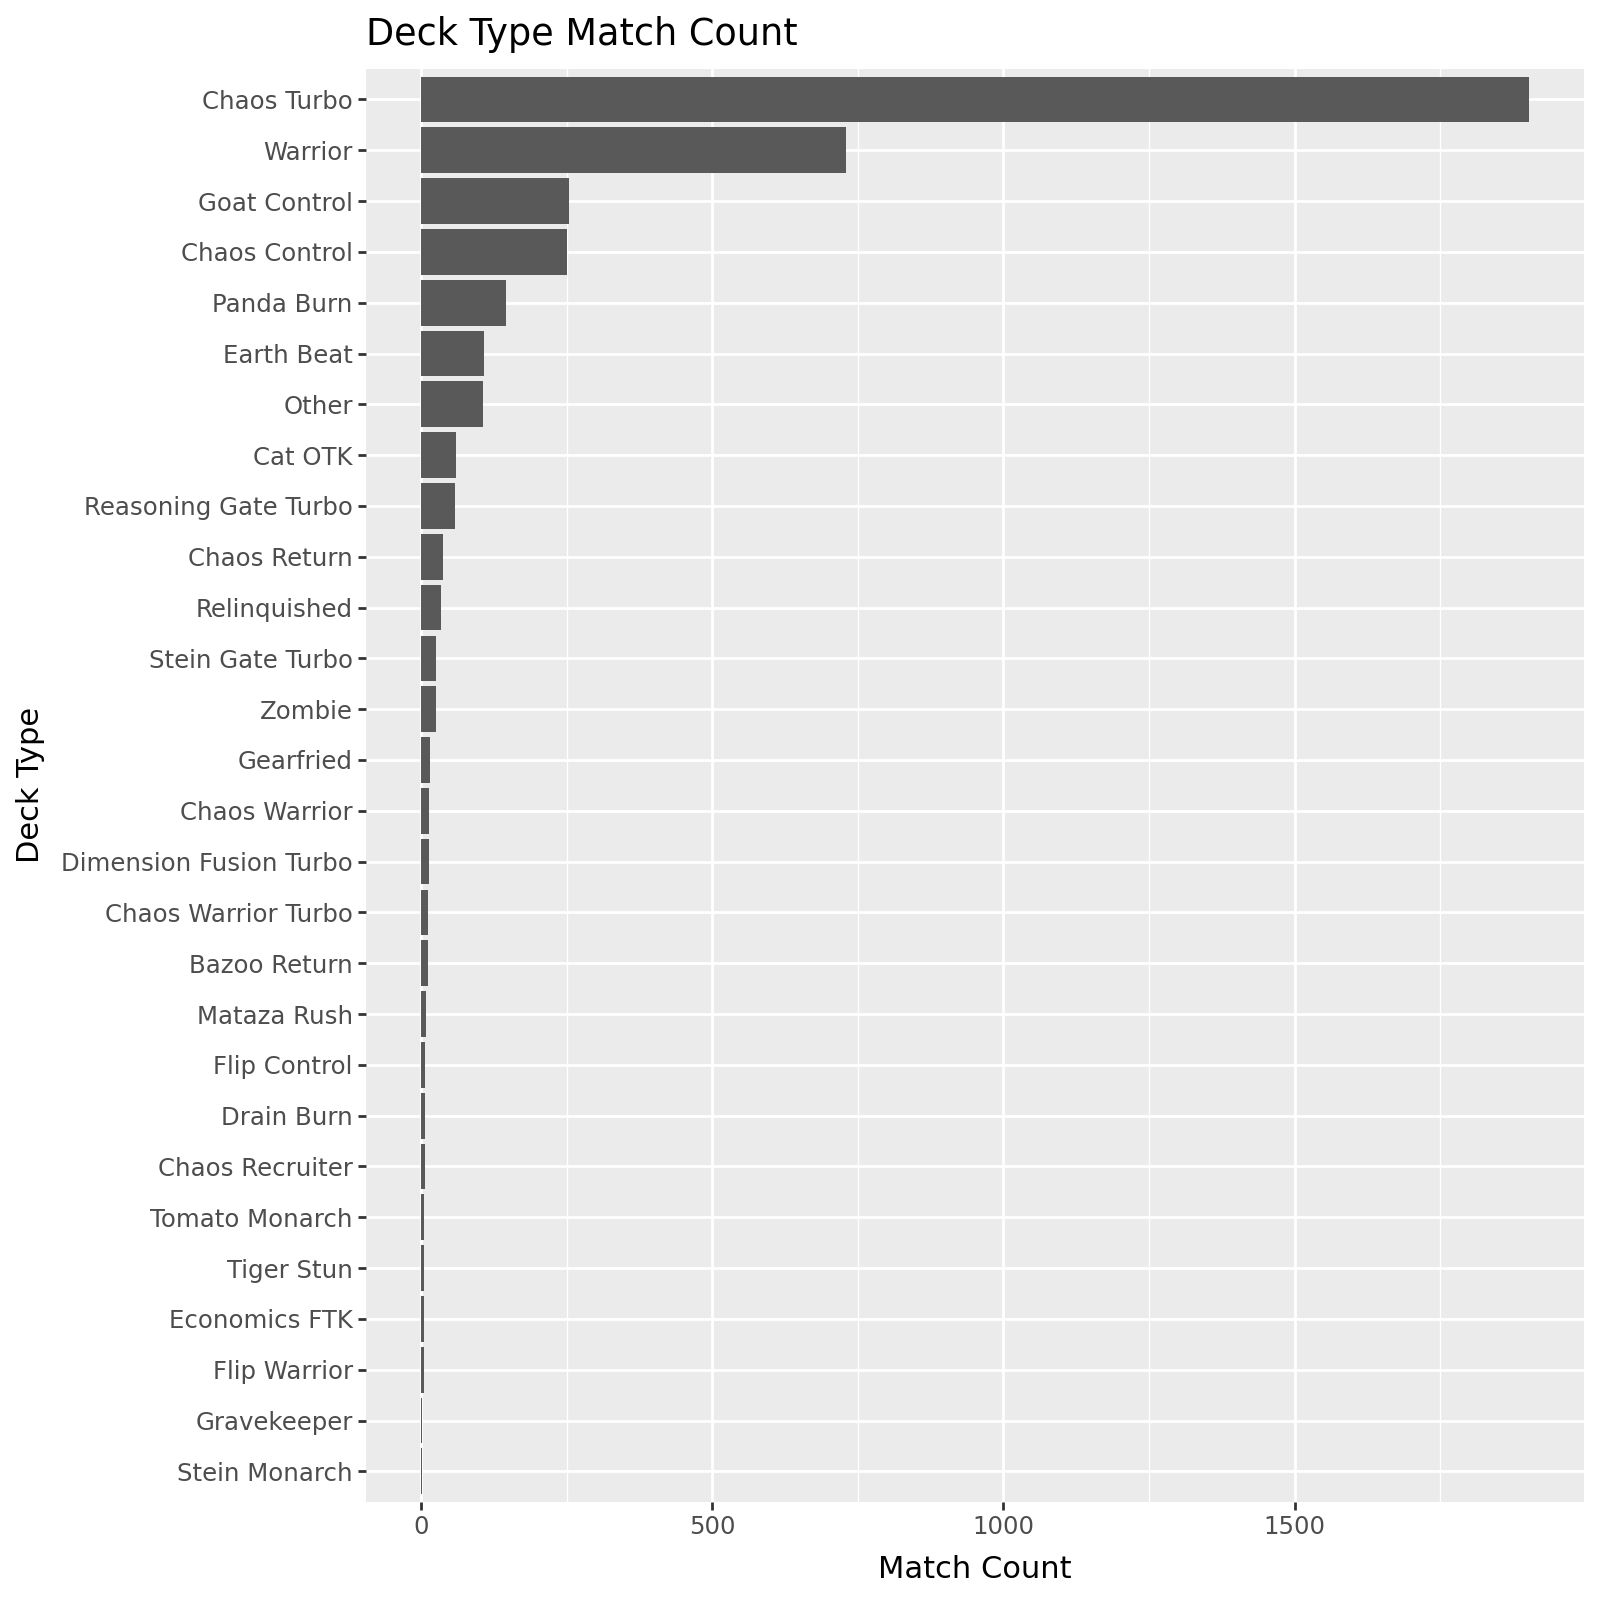

In [458]:
eda_dtmc_plot_df = (
    final_cards_df
    .select("replay_url", "player_match_deck_type")
    .unique("replay_url")
    .group_by("player_match_deck_type")
    .len("count")
    .sort("count", descending=True)
)

(
    ggplot(
        eda_dtmc_plot_df,
        aes(x="reorder(player_match_deck_type, count)", y="count")
    )
    + geom_col()
    + coord_flip()
    + labs(
        title="Deck Type Match Count",
        x="Deck Type",
        y="Match Count"
    )
    + theme(
        figure_size=(8, 8),
        title=element_text(ha="left"),
        axis_title_x=element_text(ha="center")
    )
)

### Deck Type Match Count Across Seasons

Deck class count throughout seasons, normalized by season count.

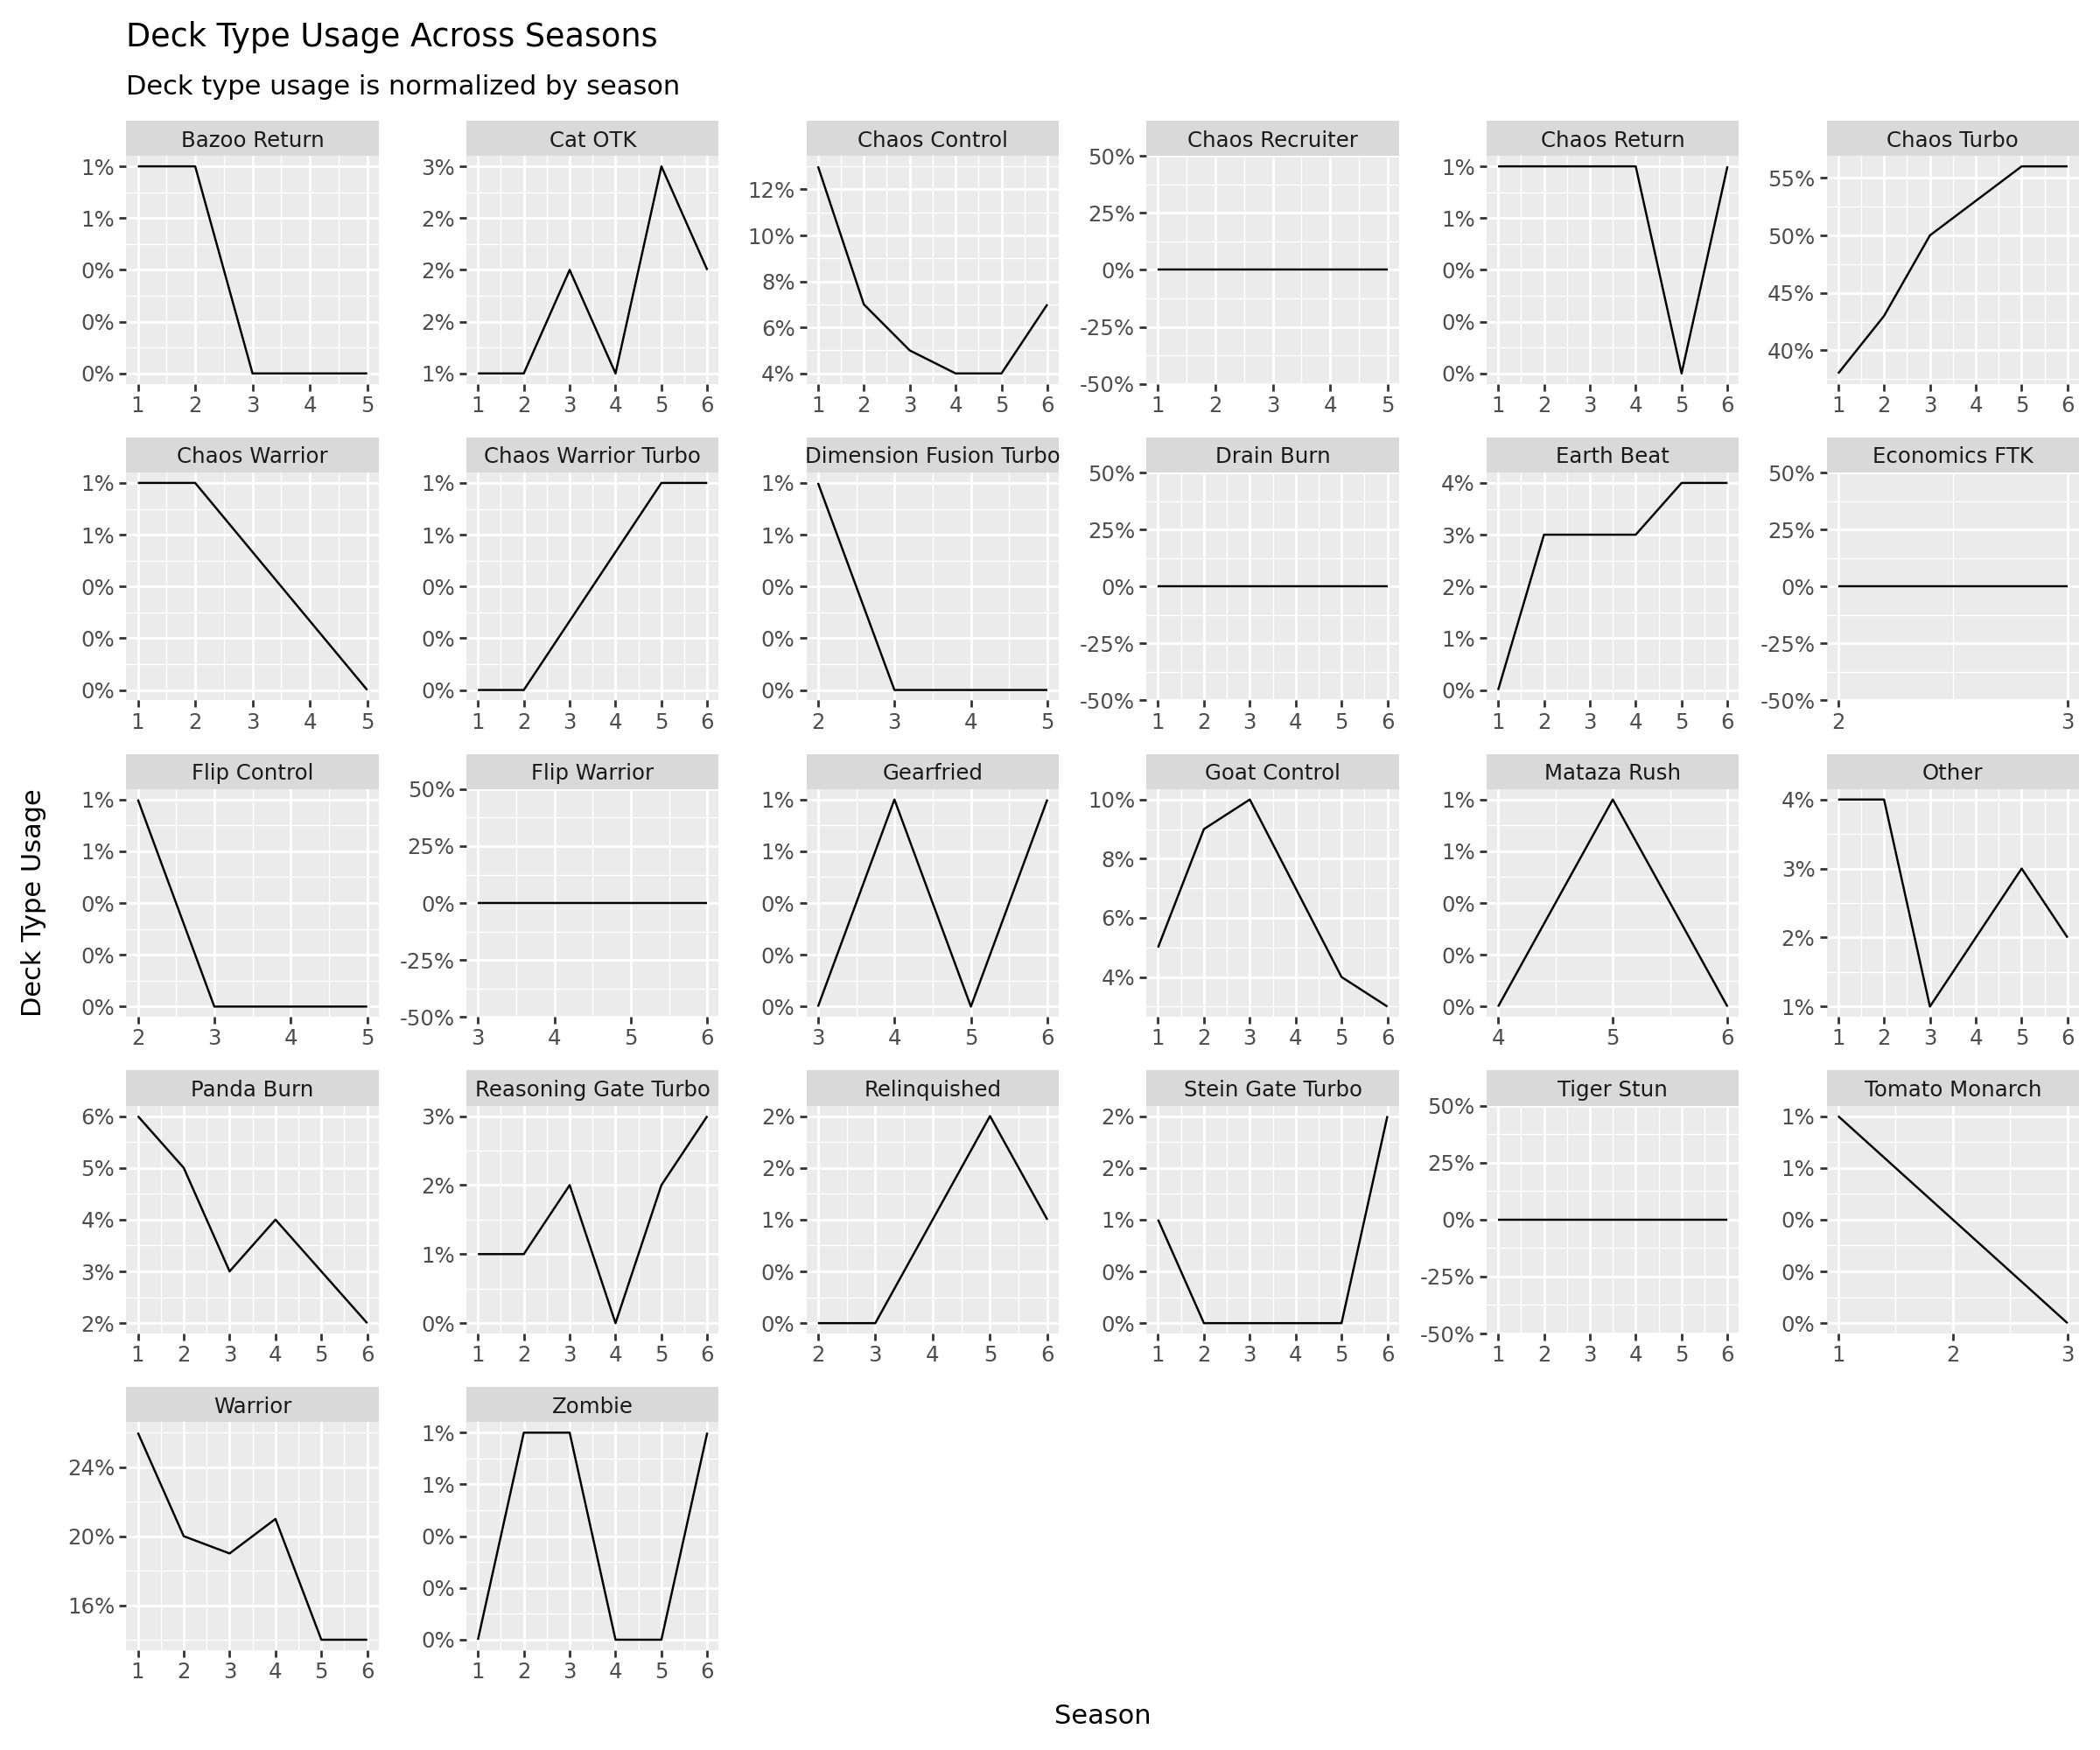

In [459]:
eda_dtmcas_plot_df = (
    final_cards_df
    .select("replay_url", "season", "player_match_deck_type")
    .unique("replay_url")
    .group_by("season", "player_match_deck_type")
    .len("count")
    .sort(["season", "count"], descending=[False, True])
    .with_columns(
        season_total=pl.sum("count").over(pl.col("season"))
    )
    .with_columns(
        pct_of_season=(pl.col("count")/pl.col("season_total")).round(2)
    )
    .filter(pl.col("player_match_deck_type").count().over("player_match_deck_type") > 1)
)

(
    ggplot(
        eda_dtmcas_plot_df,
        aes(x="season", y="pct_of_season")
    )
    + geom_line()
    + scale_x_continuous(breaks=range(1, 7))
    + scale_y_continuous(labels=lambda x: [f"{(label*100):.0f}%" for label in x])
    + facet_wrap("player_match_deck_type", scales="free")
    + labs(
        title="Deck Type Usage Across Seasons",
        subtitle="Deck type usage is normalized by season",
        x="Season",
        y="Deck Type Usage"
    )
    + theme(
        figure_size=(12, 10)
    )
)

## Win Rate Calculations

Before hopping into win rate eda, there's a pressing problem: sample size. Let's walk over our options for dealing with this.

### Remove Low Samples

This is the most straightforward one but defining the sample threshold is tricky if there's big differences in relative sizes. For example, we can safely filter out samples lower than 10. However, if I'm looking at calculations where the sample of one thing is 500 and the other is 50, the 50's variance will stand out. Yet, at 50 samples there's enough information there to not get filtered out.

### Laplace Smoothing

Mostly to help deal with 0-frequency problems. In other words, *useful* if your issue is with samples in the single digits.

### Wilson Score Interval

Doesn't calculate an adjusted win rate, but gives 95% confidence bounds of the *true* win rate. For example, a deck has a win rate of 50% with low sample, there could be wide bounds between 25% and 75% whereas something with a higher sample could be between 49% and 51%.

Aside from adding some perspective on variance, the conservative use-case is to use the lower bound as a safe estimate for the win rate. But a few problems:
- If the win rate is <=50%, the lower bound would go lower than that while we might expect uncertainty to go more towards 50%.
- You can gauge the relative variance of low sample calculations by just looking at the sample size. So, you can already tell if something is likely to have more variance and the preciseness of the bounds aren't necessary.

### Bayesian Estimation

In Bayesian estimation, you combine a prior belief about the win rate with the likelihood of observing the data to compute a posterior distribution. This posterior distribution reflects your updated belief about the win rate after accounting for the observed data.

### What We'll Use

This is a simplistic method that incorporates elements from bayesian estimation. Basically, we have a prior belief that the win rate should be around 50% and `K` is how strong we'll weight that 50% based on what sample size we think the calculations are more accurate.

$$
\text{Adjusted Win Rate} = \frac{\text{Wins} + K \cdot 0.5}{\text{Count} + K}
$$


In [460]:
def adjusted_win_rate(wins: int, count: int, K: int = 50) -> float:
    if count == 0:
        return 0.5
    
    adj_winrate = (wins + K * 0.5) / (count + K)
    return round(adj_winrate * 100, 2)

Here's a practical example of how this function effects win rate as the sample size changes:

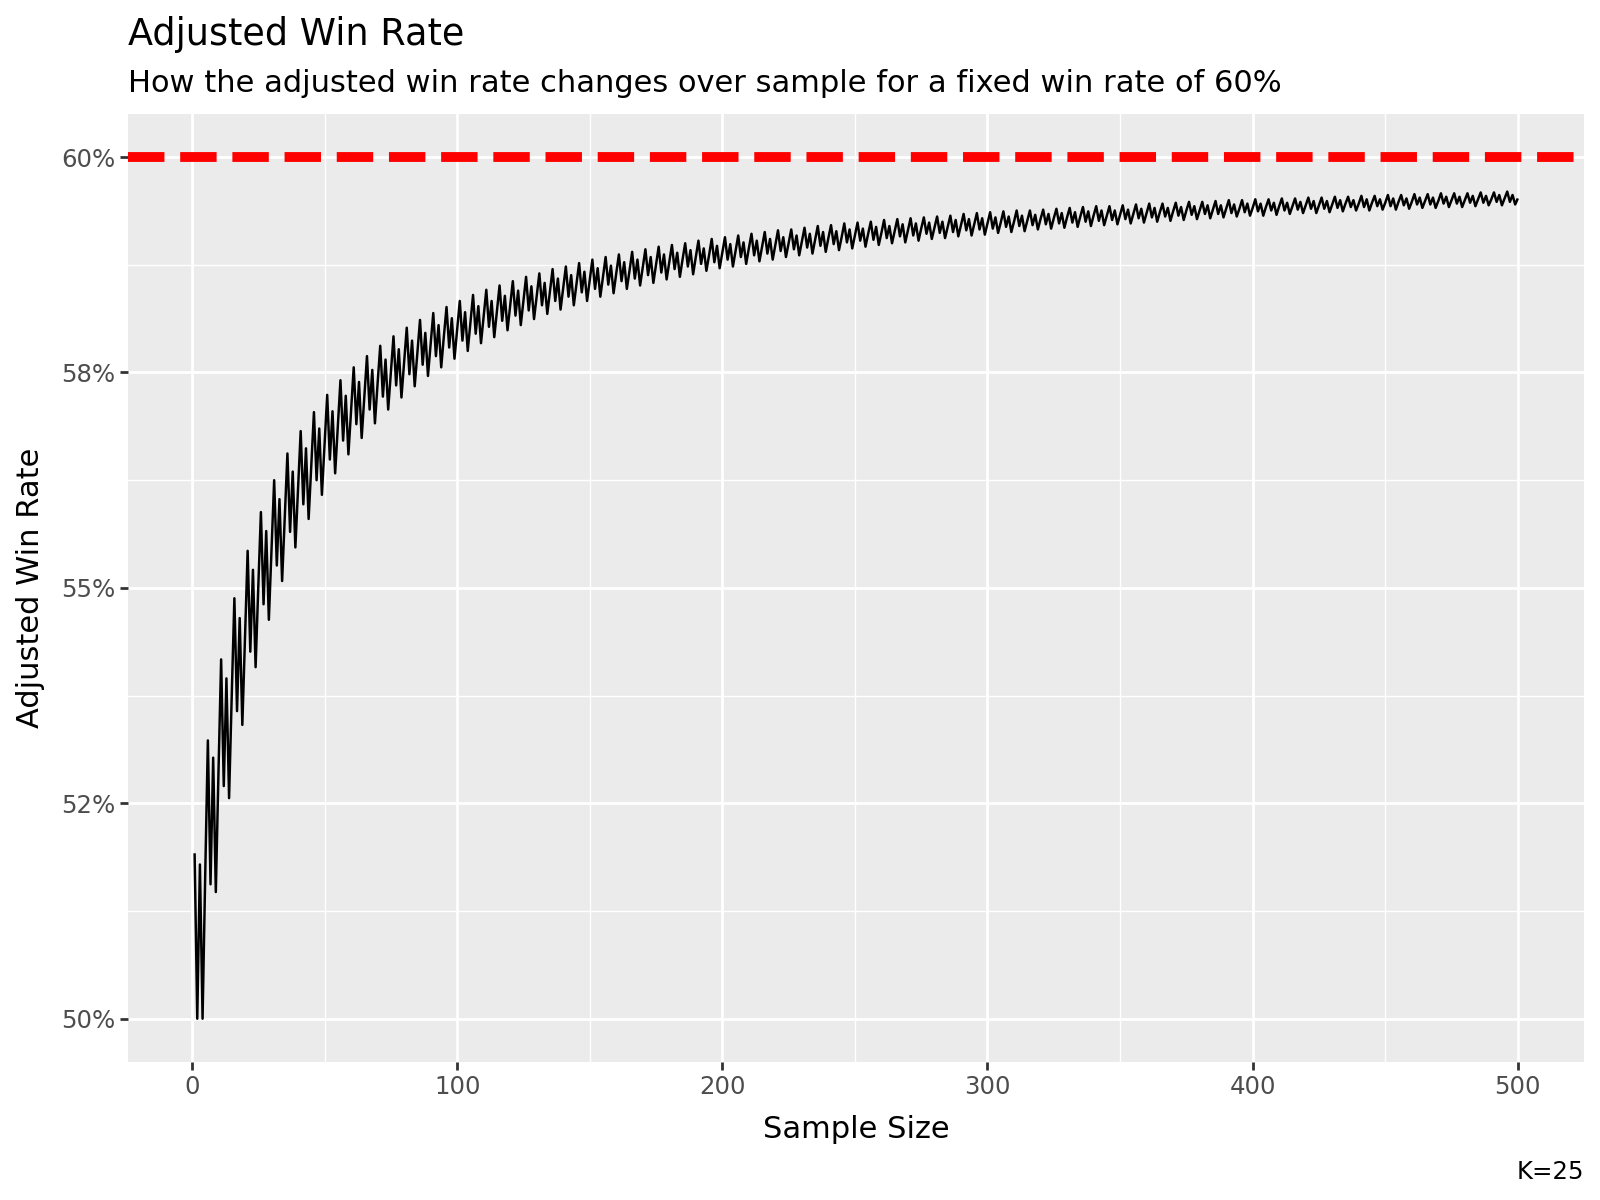

In [461]:
max_sample_size = 500
fixed_win_rate = 0.6
k = 25

sample_sizes = range(1, max_sample_size+1)
wins = [round(size * fixed_win_rate) for size in sample_sizes]

wwc_wwu_plot_df = pl.DataFrame(
    {
        "sample_size": sample_sizes,
        "wins": wins,
        "fixed_win_rate": [fixed_win_rate] * len(sample_sizes),
        "adjusted_win_rate": [
            adjusted_win_rate(w, s, k) for w, s in zip(wins, sample_sizes)
        ]
    }
)

(
    ggplot(
        wwc_wwu_plot_df,
        aes(x="sample_size", y="adjusted_win_rate")
    )
    + geom_line()
    + geom_hline(yintercept=60, color="red", size=2, linetype="dashed")
    + scale_y_continuous(labels=lambda x: [f"{label:.0f}%" for label in x])
    + labs(
        title="Adjusted Win Rate",
        subtitle=f"How the adjusted win rate changes over sample for a fixed win rate of {(fixed_win_rate*100):.0f}%",
        x="Sample Size",
        y="Adjusted Win Rate",
        caption=f"K={k}"
    )
    + theme(
        figure_size=(8, 6)
    )
)

## Deck Type Match Win Rate

### Non-Mirror

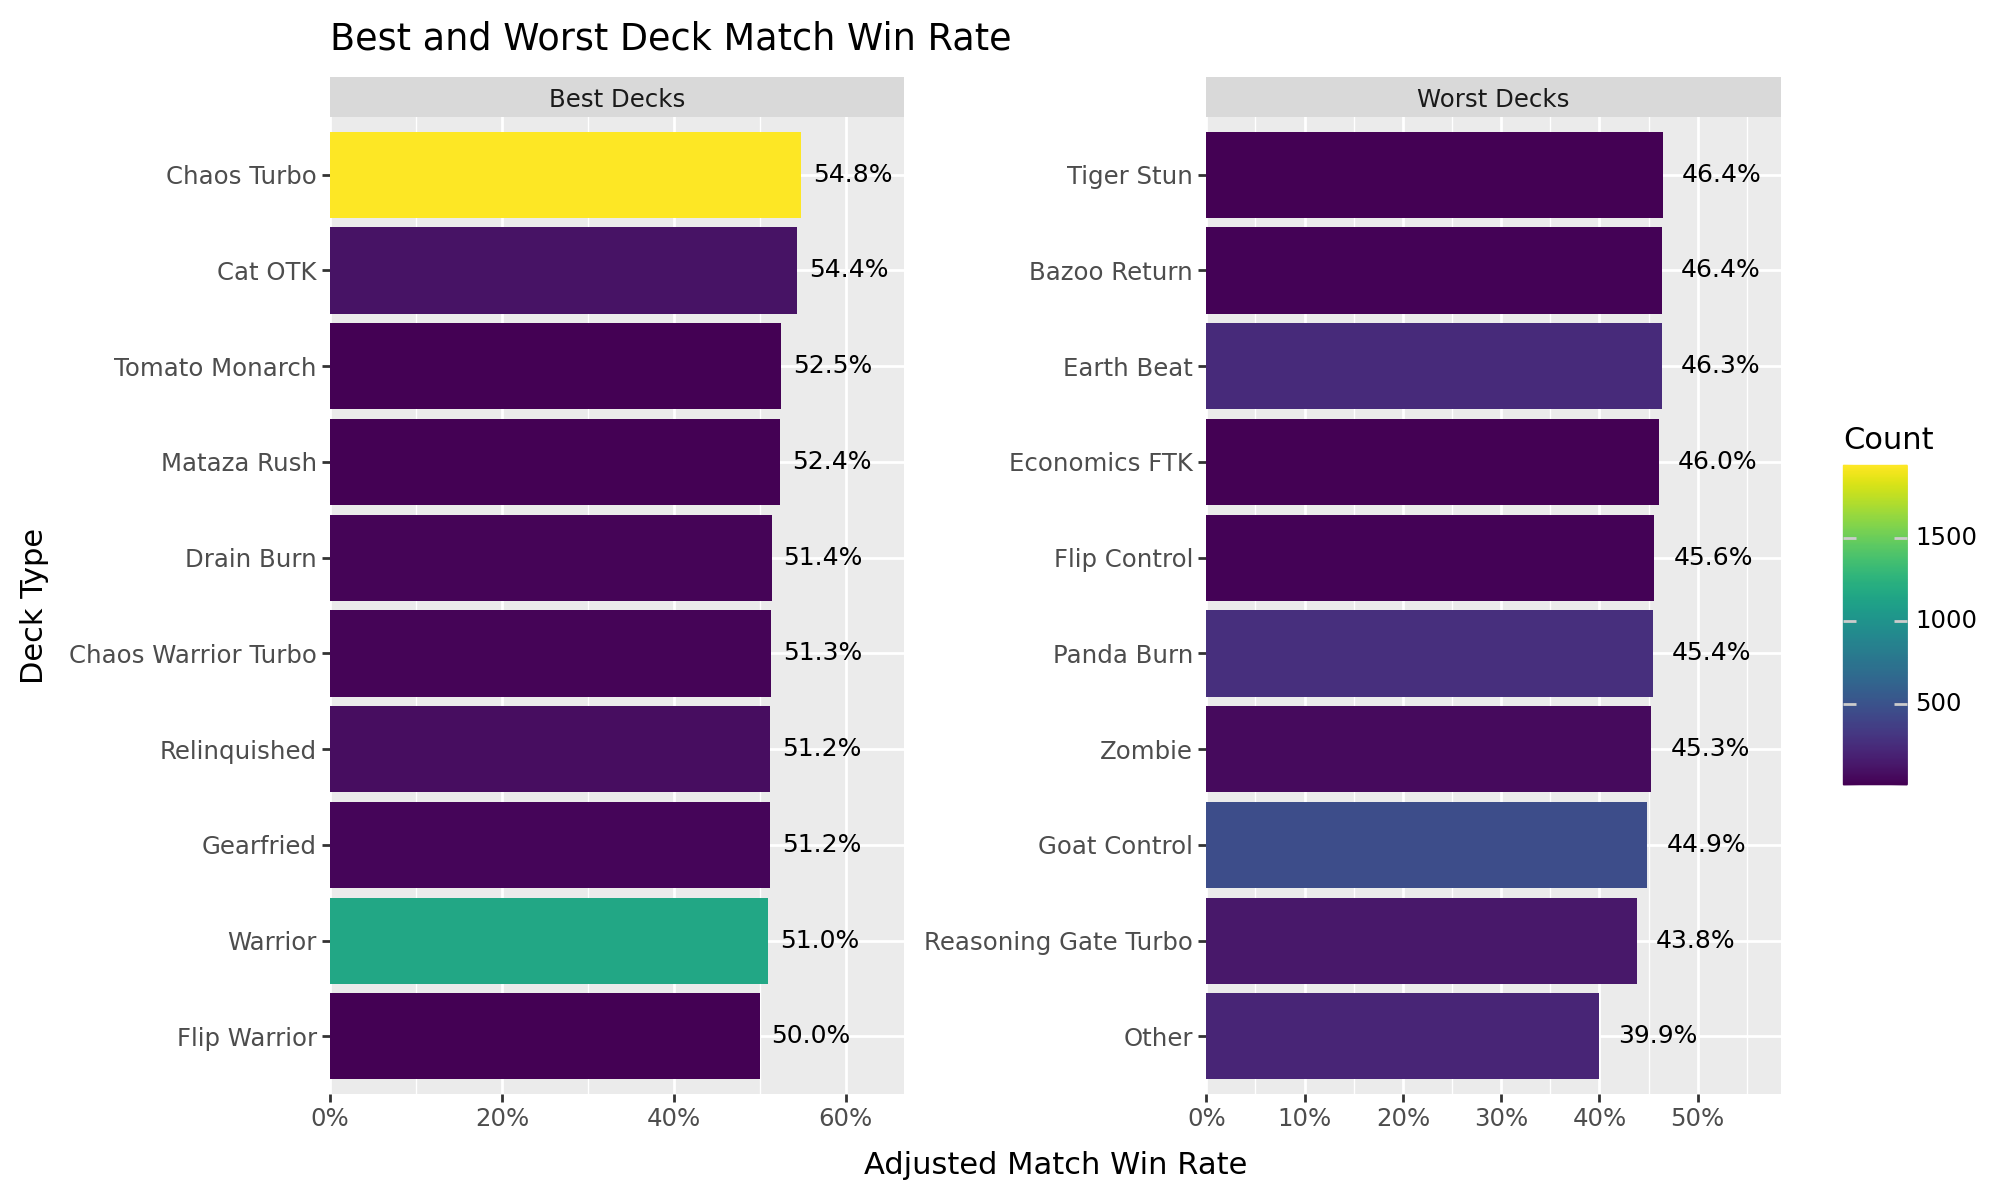

In [462]:
dtmwr_nm_base_df = (
    final_cards_df
    .group_by("replay_url", "player_won_match")
    .first()
    .filter(pl.col("player_match_deck_type") != pl.col("opp_match_deck_type"))
    .group_by("player_match_deck_type")
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        win_rate=((pl.col("win")/pl.col("count"))*100).round(2),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda x: adjusted_win_rate(x["win"], x["count"]),
            return_dtype=float
        ),
        opp_match_deck_type=pl.lit("*Non-Mirror")
    )
    .sort("adj_win_rate", descending=True)
)

dtmwr_nm_plot_df = reorder_within(
    pl.concat([
        dtmwr_nm_base_df
        .head(10)
        .with_columns(group=pl.lit("Best Decks")),
        dtmwr_nm_base_df
        .tail(10)
        .with_columns(group=pl.lit("Worst Decks"))
    ]),
    x="player_match_deck_type",
    by="adj_win_rate",
    within="group"
).to_pandas()

# Order group for Best Decks to be on the left side
dtmwr_nm_plot_df["group"] = pd.Categorical(
    values=[group for group in dtmwr_nm_plot_df["group"].to_list()],
    categories=["Best Decks", "Worst Decks"],
    ordered=True
)

(
    ggplot(
        dtmwr_nm_plot_df,
        aes(x="reorder(player_match_deck_type_ordered, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.1f}%",
        nudge_y=6,
        size=9
    )
    + scale_x_discrete(labels=remove_suffix)
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 6)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Best and Worst Deck Match Win Rate",
        x="Deck Type",
        y="Adjusted Match Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(10, 6),
        plot_title=element_text(ha="left"),
    )
)

### Most Lopsided Matchups

In [463]:
# Create matchups_base_df for other matchups section
matchups_base_df = (
    final_cards_df
    .select("replay_url", cs.contains("match_") & ~cs.matches("conf|went"), "player_won_match")
    .unique(["replay_url", "player_won_match"])
    .group_by(cs.contains("deck_type"))
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        matchup=pl.concat_str(pl.col("player_match_deck_type"), pl.col("opp_match_deck_type"), separator=" vs "),
        win_rate=((pl.col("win")/pl.col("count"))*100).round(2),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
    .sort("matchup")
)

with pl.Config(tbl_width_chars=200):
    print(
        matchups_base_df
        .head(4)
    )

shape: (4, 7)
┌────────────────────────┬─────────────────────┬─────┬───────┬───────────────────────────────┬──────────┬──────────────┐
│ player_match_deck_type ┆ opp_match_deck_type ┆ win ┆ count ┆ matchup                       ┆ win_rate ┆ adj_win_rate │
│ ---                    ┆ ---                 ┆ --- ┆ ---   ┆ ---                           ┆ ---      ┆ ---          │
│ str                    ┆ str                 ┆ u32 ┆ u32   ┆ str                           ┆ f64      ┆ f64          │
╞════════════════════════╪═════════════════════╪═════╪═══════╪═══════════════════════════════╪══════════╪══════════════╡
│ Bazoo Return           ┆ Cat OTK             ┆ 1   ┆ 1     ┆ Bazoo Return vs Cat OTK       ┆ 100.0    ┆ 50.98        │
│ Bazoo Return           ┆ Chaos Control       ┆ 0   ┆ 1     ┆ Bazoo Return vs Chaos Control ┆ 0.0      ┆ 49.02        │
│ Bazoo Return           ┆ Chaos Turbo         ┆ 4   ┆ 9     ┆ Bazoo Return vs Chaos Turbo   ┆ 44.44    ┆ 49.15        │
│ Bazoo Return    

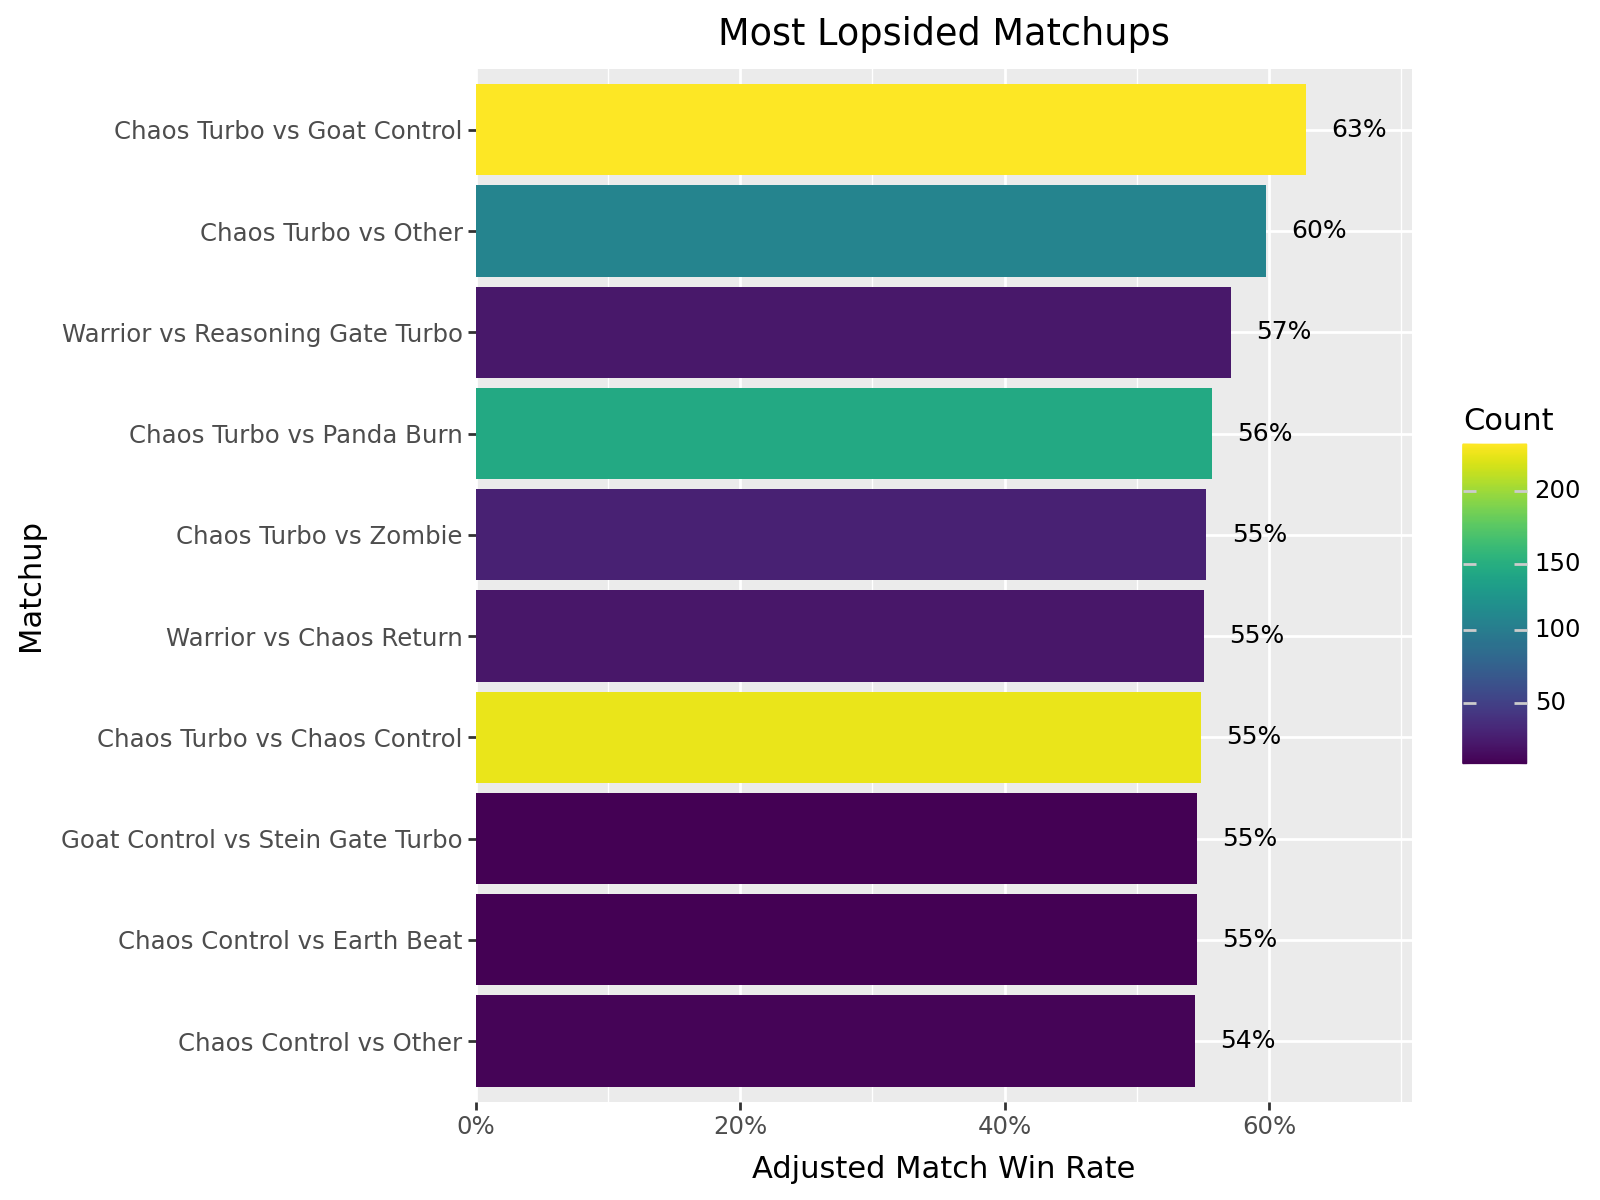

In [464]:
dtmwr_mlm_plot_df = (
    matchups_base_df
    .filter(pl.col("player_match_deck_type") != pl.col("opp_match_deck_type"))
    .sort("adj_win_rate", descending=True)
    .head(10)
)

(
    ggplot(
        dtmwr_mlm_plot_df,
        aes(x="reorder(matchup, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.0f}%",
        nudge_y=4,
        size=9
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 4)
    )
    + labs(
        title="Most Lopsided Matchups",
        x="Matchup",
        y="Adjusted Match Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(8, 6)
    )
)

### Matchup Matrix

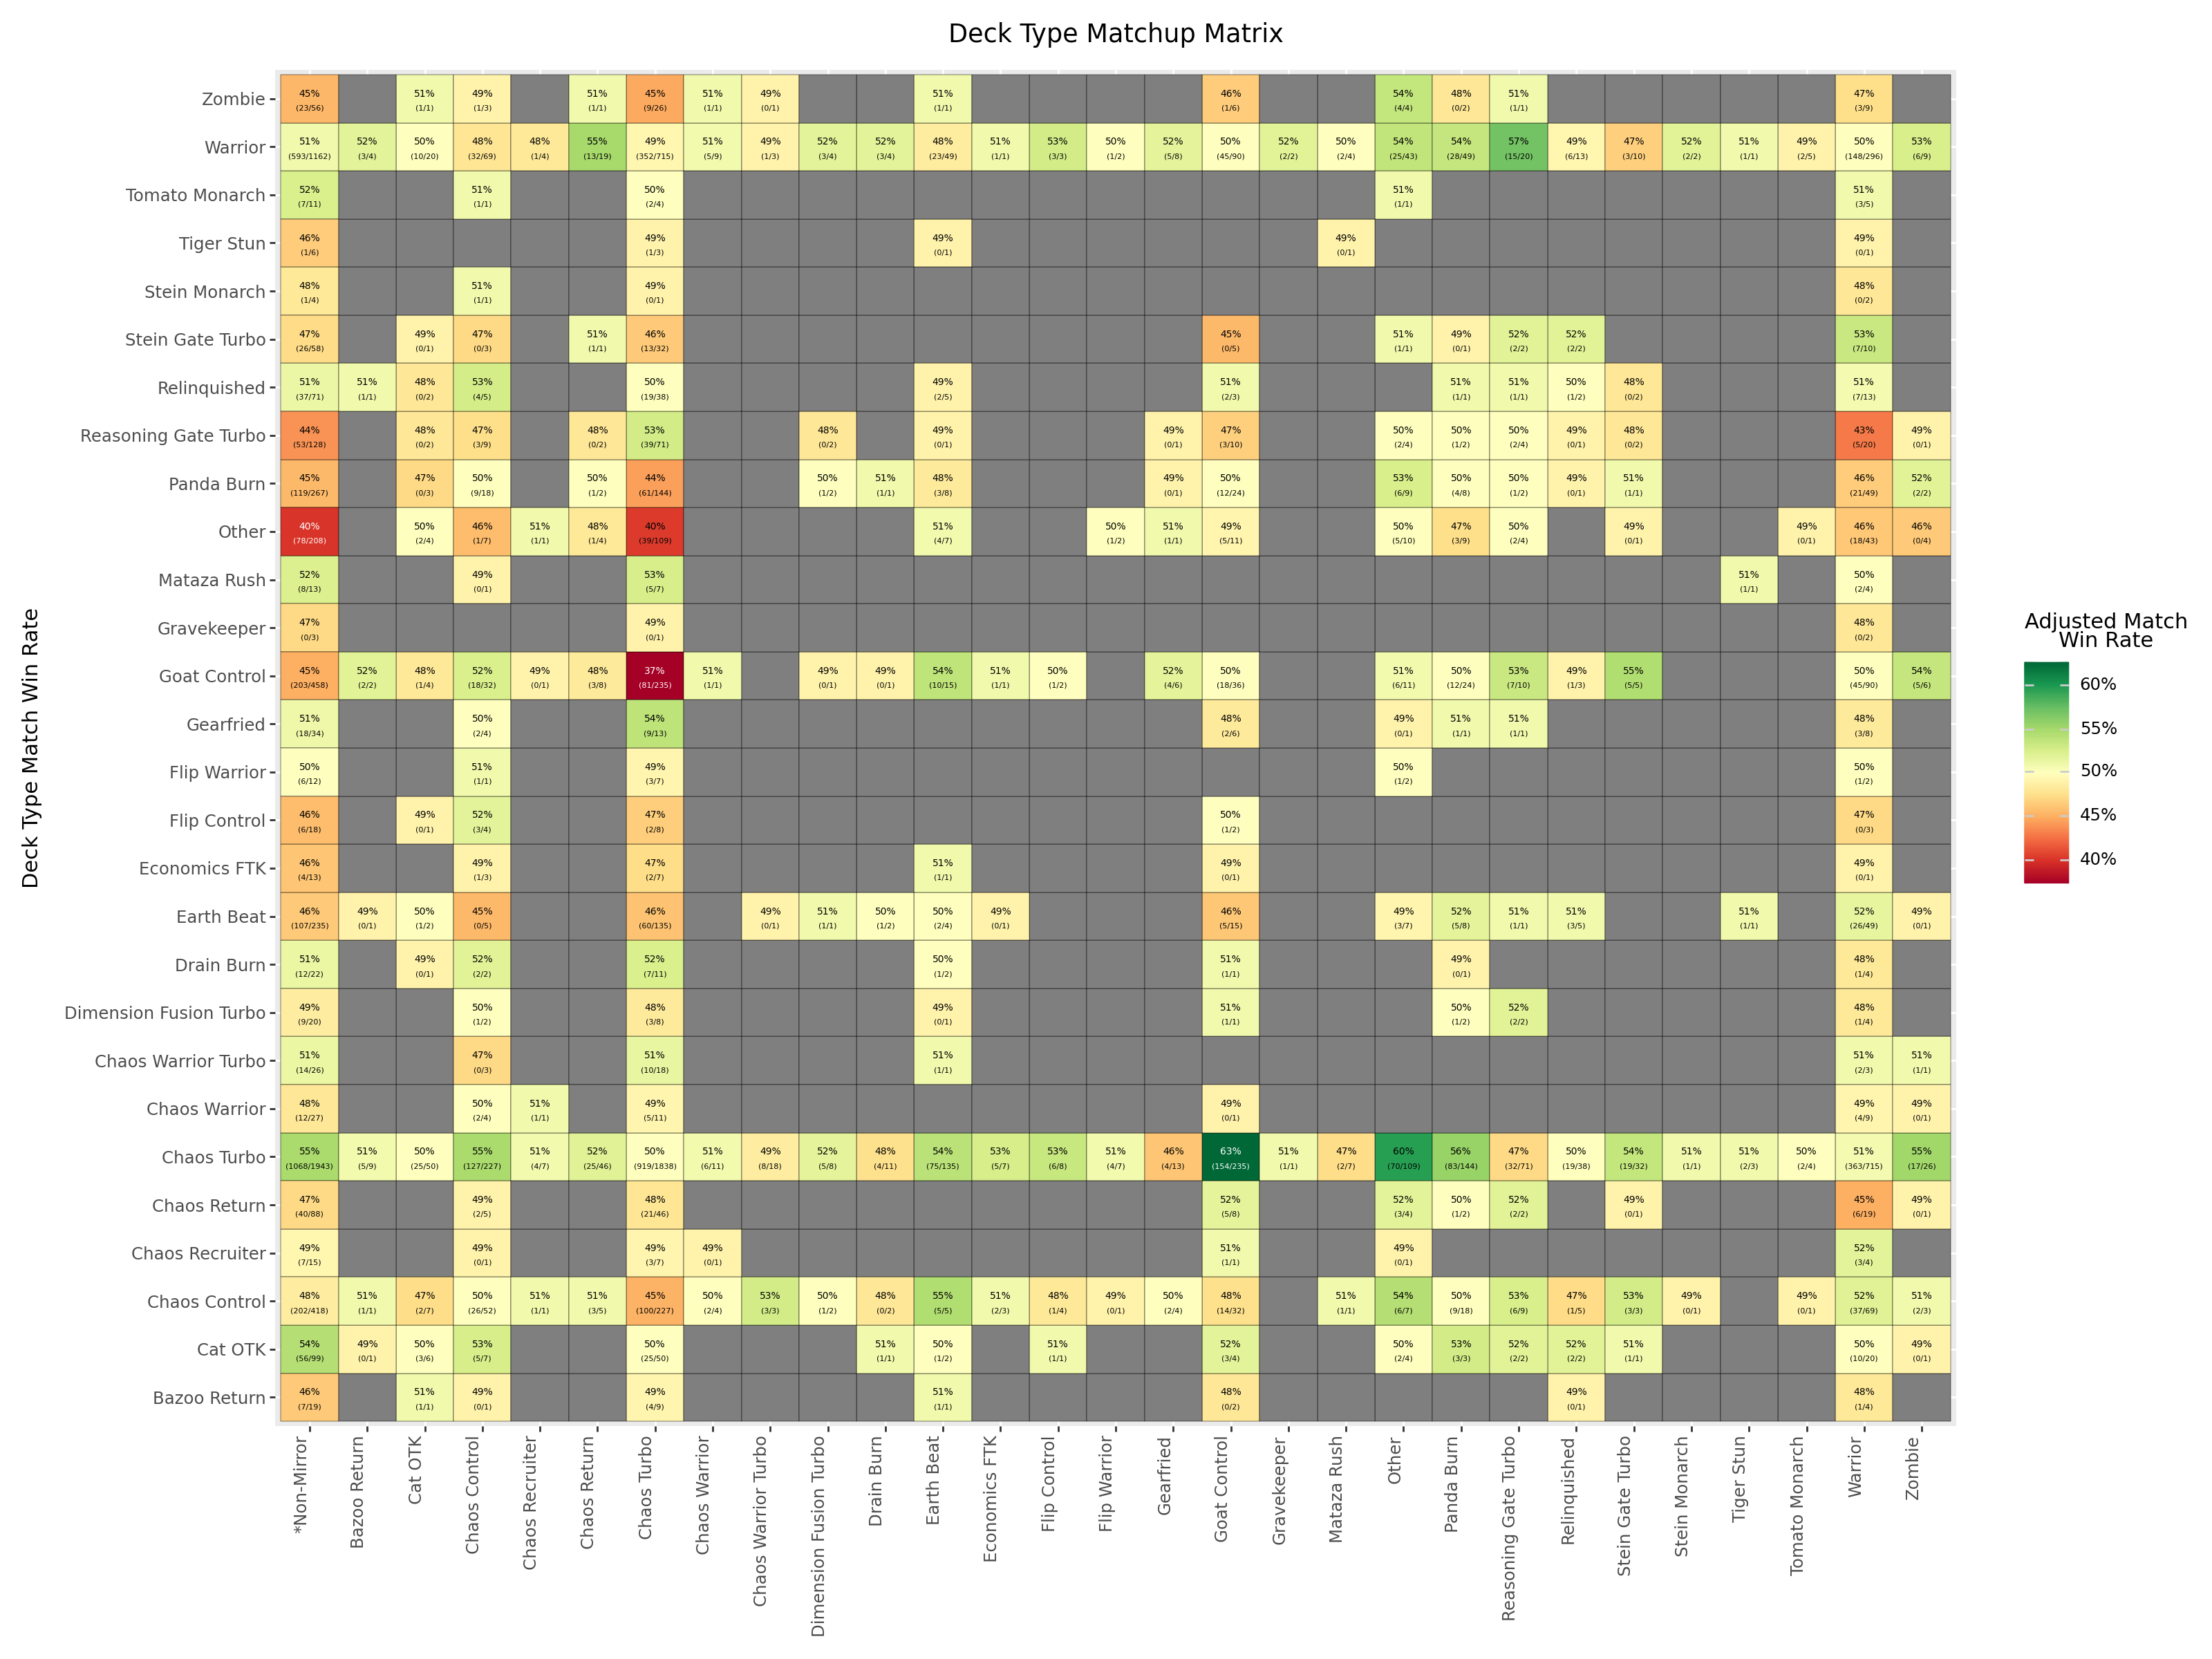

In [465]:
# Pivot a few times to fill empty matchups with nulls to style in chart
dtmwr_mm_base_df = (
    matchups_base_df
    .pivot(
        on="opp_match_deck_type",
        index="player_match_deck_type",
        values="adj_win_rate"
    )
    .unpivot(
        on=cs.exclude("player_match_deck_type"),
        index="player_match_deck_type",
        variable_name="opp_match_deck_type",
        value_name="adj_win_rate"
    )
    .join(
        matchups_base_df.drop("adj_win_rate"),
        on=["player_match_deck_type", "opp_match_deck_type"],
        how="left"
    )
    .pipe(lambda df: df.select(sorted(df.columns))) # Reorder columns to match concat
)

# Concat non-mirror data with matchups data
dtmwr_mm_plot_df = (
    pl.
    concat([
        (
            dtmwr_nm_base_df
            .with_columns(
                matchup=pl.concat_str(cs.contains("deck_type"))
            )
            .pipe(lambda df: df.select(sorted(df.columns)))
        ),
        dtmwr_mm_base_df
    ])
    .with_columns(
        text_color=pl.when(pl.col("adj_win_rate") >= 60)
            .then(pl.lit("low"))
            .when(pl.col("adj_win_rate") >= 40)
            .then(pl.lit("high"))
            .when(pl.col("adj_win_rate") > 0)
            .then(pl.lit("low"))
            .otherwise(pl.lit("none")),
        score=pl.concat_str(pl.col("win"), pl.col("count"), separator="/")
    )
)

(
    ggplot(
        dtmwr_mm_plot_df,
        aes(x="opp_match_deck_type", y="player_match_deck_type", fill="adj_win_rate")
    )
    + geom_tile(color="black")
    + scale_fill_continuous(
        cmap_name="RdYlGn", 
        labels=lambda x: [f"{label:.0f}%" for label in x]
    )
    + geom_text(
        aes(label="adj_win_rate", color="text_color"),
        format_string="{:.0f}%",
        nudge_y=.1, 
        size=5, 
        show_legend=False,
        na_rm=True
    )
    + geom_text(
        aes(label="score", color="text_color"),
        format_string="({:})",
        nudge_y=-.2,
        size=4,
        show_legend=False,
        na_rm=True
    )
    + scale_color_manual(["black", "white", "red"])
    + labs(
        title="Deck Type Matchup Matrix",
        x="",
        y="Deck Type Match Win Rate",
        fill="Adjusted Match\nWin Rate",
    )
    + theme(
        figure_size=(16, 12),  
        axis_text_x=element_text(angle=90, hjust=1)
    )
)

### Most Improved Matchups Across Seasons

Most improved matchup win rate from season 1 to 6.

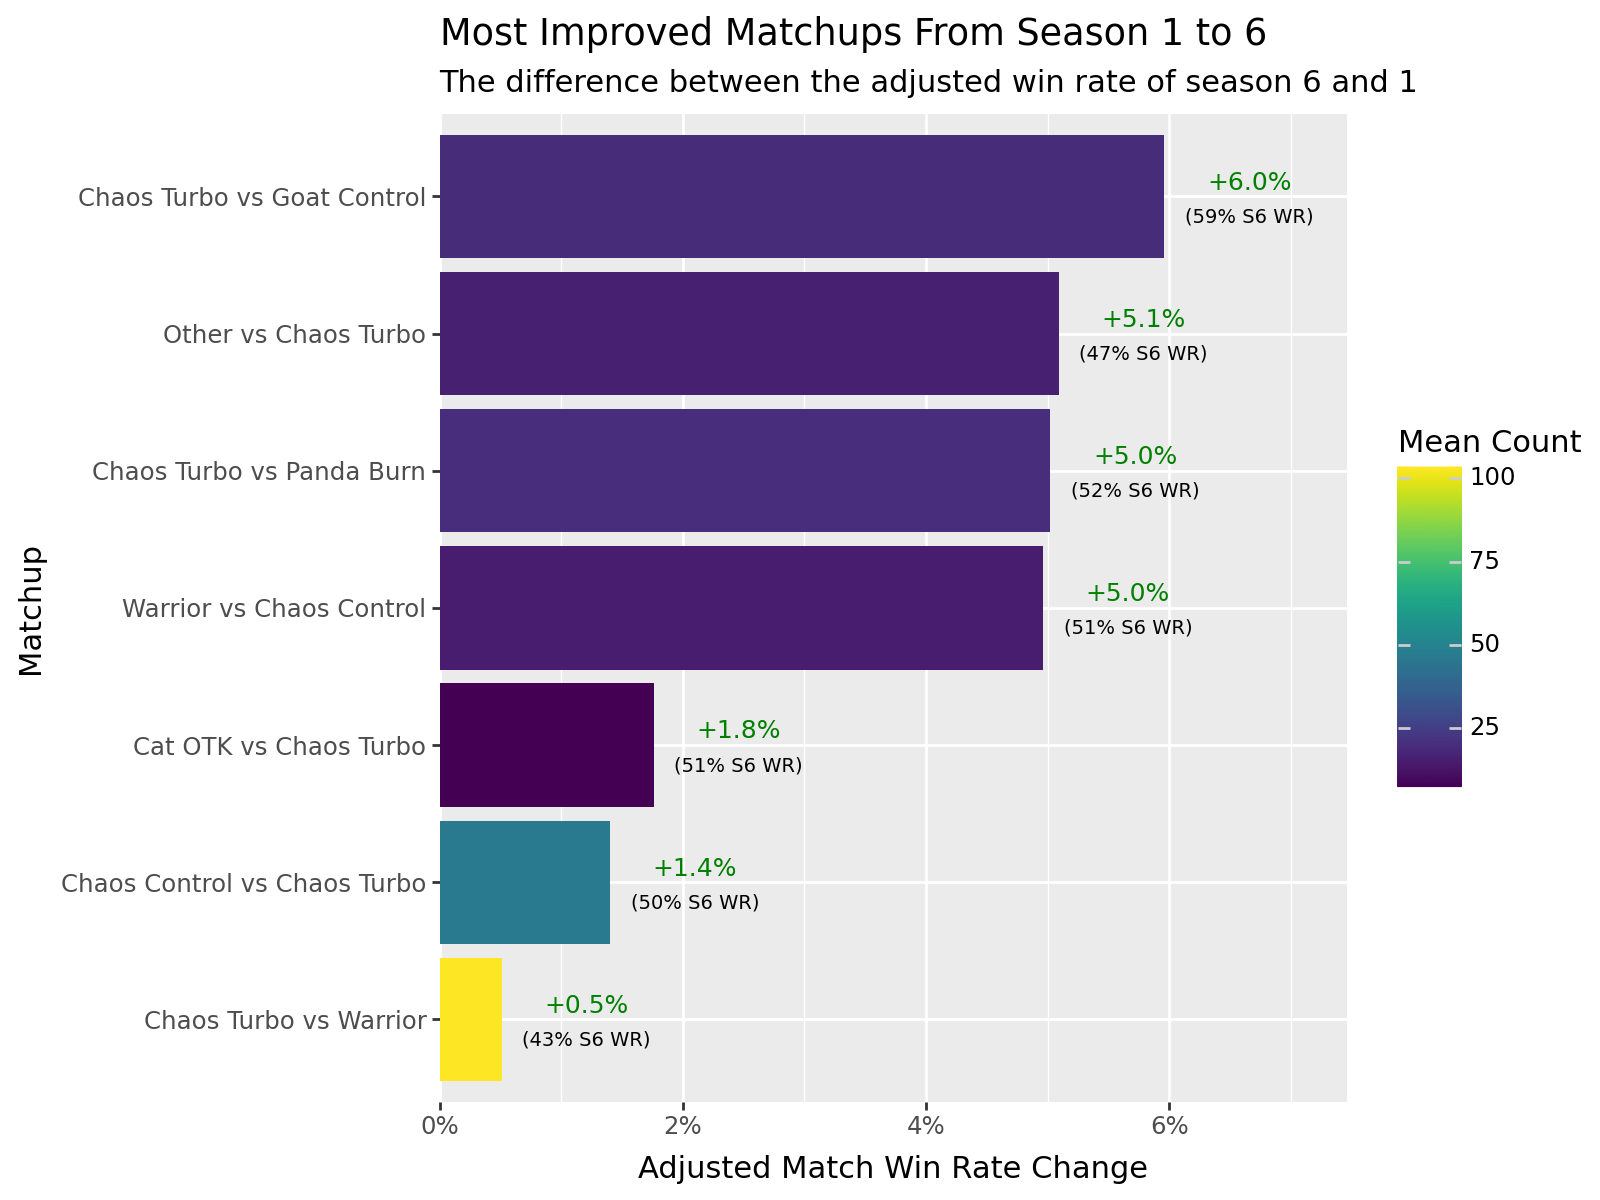

In [466]:
# Create matchups table but by season
matchups_by_season_base_df = (
    final_cards_df
    .select("season", "replay_url", cs.contains("match") & ~cs.contains("conf"))
    .unique(["replay_url", "player_won_match"])
    .group_by("season", cs.contains("match_deck_type"))
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        matchup=pl.concat_str(pl.col("player_match_deck_type"), pl.col("opp_match_deck_type"), separator=" vs "),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]), 
            return_dtype=float
        )
    )
)

dtmwr_mimas_s16_plot_df = (
    matchups_by_season_base_df
    .filter(pl.col("season").is_in([1, 6]), pl.col("count") >= 5)
    .with_columns(
        season=pl.concat_str(pl.lit("s"), pl.col("season"))
    )
    .pivot(
        on="season",
        index="matchup",
        values=["adj_win_rate", "count"]
    )
    .drop_nulls()
    .with_columns(
        wr_pos_diff=(pl.col("adj_win_rate_s6") - pl.col("adj_win_rate_s1")).round(2),
        mean_count=pl.mean_horizontal(cs.contains("count"))
    )
    .filter(pl.col("wr_pos_diff") > 0)
    .sort("wr_pos_diff", descending=True)
    .head(10)
)

(
    ggplot(
        dtmwr_mimas_s16_plot_df,
        aes(x="reorder(matchup, wr_pos_diff)", y="wr_pos_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_y_continuous(labels=lambda x: [f"{label:.0f}%" for label in x], expand=(0, 0, 0, .8))
    + geom_text(
        aes(label="wr_pos_diff"),
        format_string="+{:.1f}%",
        nudge_x=.1,
        nudge_y=.7,
        size=9,
        color="green"
    )
    + geom_text(
        aes(label="adj_win_rate_s6"),
        format_string="({:.0f}% S6 WR)",
        nudge_x=-.15,
        nudge_y=.7,
        size=7
    )
    + labs(
        title="Most Improved Matchups From Season 1 to 6",
        subtitle="The difference between the adjusted win rate of season 6 and 1",
        x="Matchup",
        y="Adjusted Match Win Rate Change",
        fill="Mean Count"
    )
    + theme(
        figure_size=(8, 6),
    )
)

Most improved matchups from season 5 to 6.

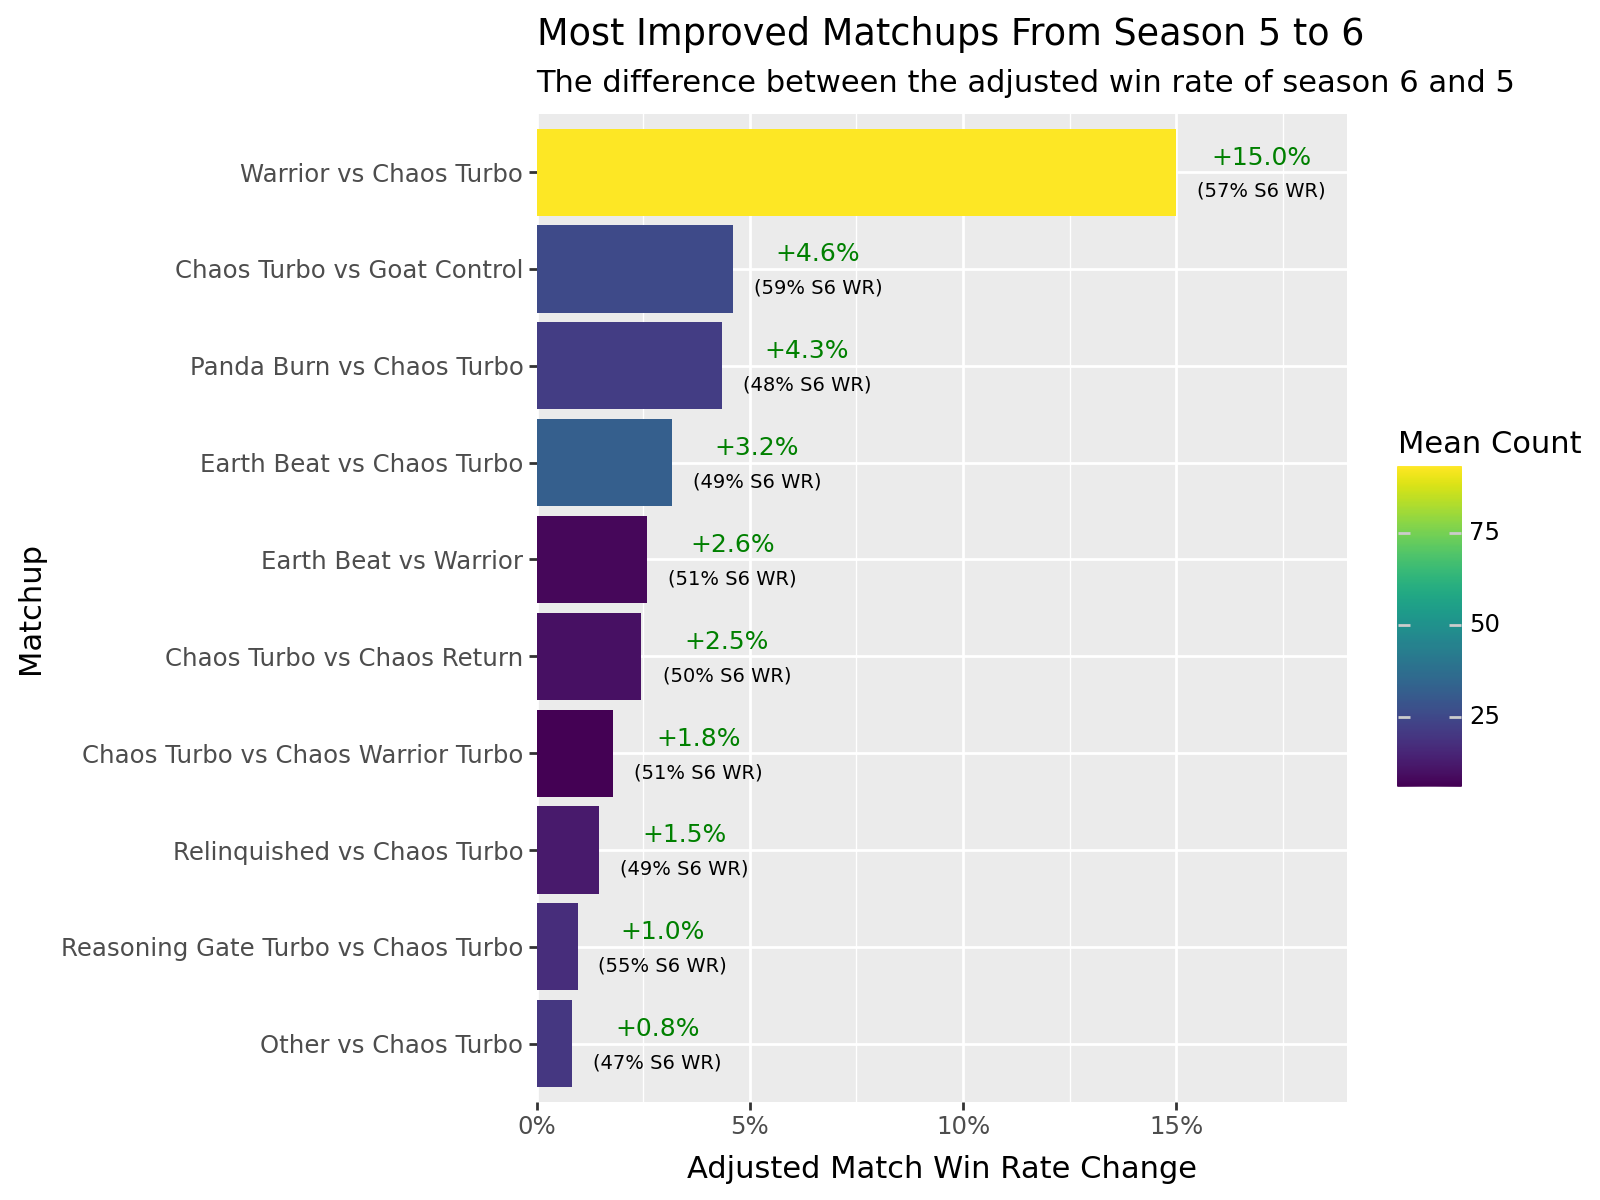

In [467]:
dtmwr_mimas_s56_plot_df = (
    matchups_by_season_base_df
    .filter(pl.col("season").is_in([5, 6]), pl.col("count") >= 5)
    .with_columns(
        season=pl.concat_str(pl.lit("s"), pl.col("season"))
    )
    .pivot(
        on="season",
        index="matchup",
        values=["adj_win_rate", "count"]
    )
    .drop_nulls()
    .with_columns(
        wr_pos_diff=(pl.col("adj_win_rate_s6") - pl.col("adj_win_rate_s5")).round(2),
        mean_count=pl.mean_horizontal(cs.contains("count"))
    )
    .filter(pl.col("wr_pos_diff") > 0)
    .sort("wr_pos_diff", descending=True)
    .head(10)
)

(
    ggplot(
        dtmwr_mimas_s56_plot_df,
        aes(x="reorder(matchup, wr_pos_diff)", y="wr_pos_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x], 
        expand=(0, 0, 0, 2)
    )
    + geom_text(
        aes(label="wr_pos_diff"),
        format_string="+{:.1f}%",
        nudge_x=.15,
        nudge_y=2,
        size=9,
        color="green"
    )
    + geom_text(
        aes(label="adj_win_rate_s6"),
        format_string="({:.0f}% S6 WR)",
        nudge_x=-.2,
        nudge_y=2,
        size=7
    )
    + labs(
        title="Most Improved Matchups From Season 5 to 6",
        subtitle="The difference between the adjusted win rate of season 6 and 5",
        x="Matchup",
        y="Adjusted Match Win Rate Change",
        fill="Mean Count"
    )
    + theme(
        figure_size=(8, 6),
    )
)

## Deck Type Game Win Rate

### Best Matchups When Going First

First, let's look at the distirbution of matchups game win rate going first vs second.

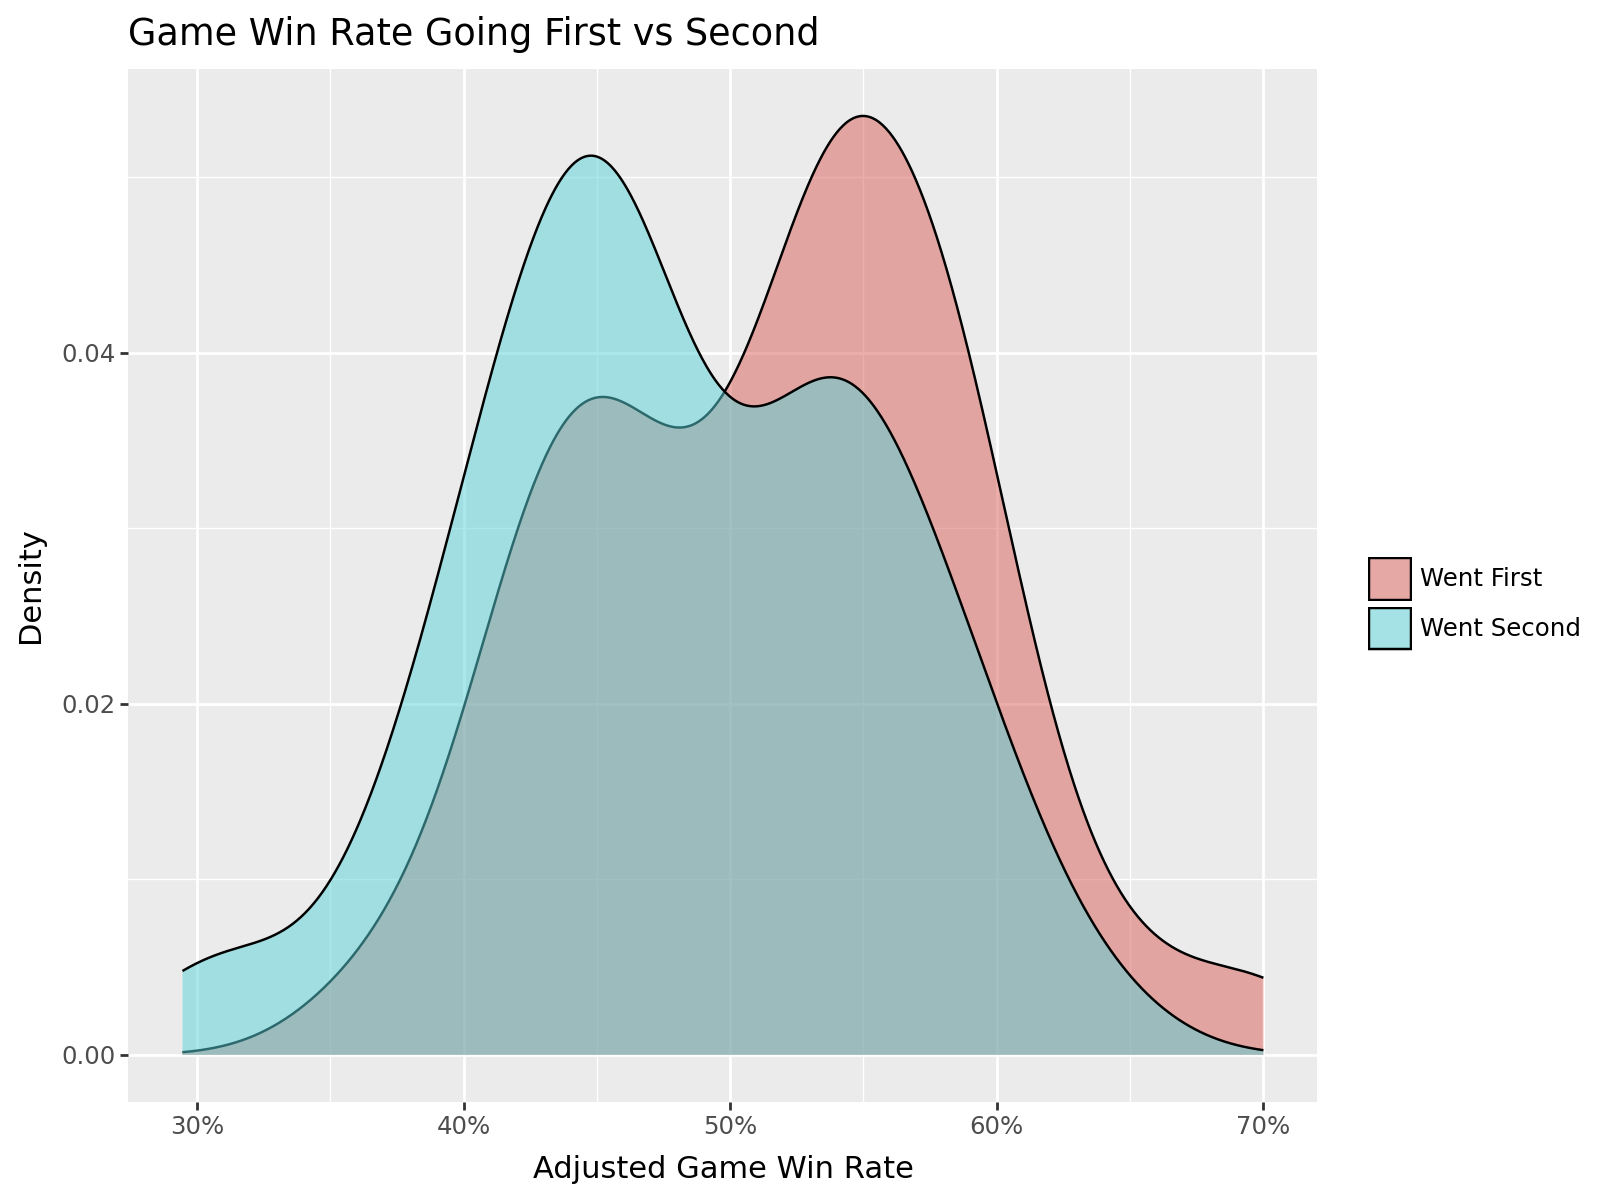

In [468]:
dtgwr_bmwgf_base_df = (
    final_cards_df
    .select("season", "replay_url", cs.contains("match") & ~cs.contains("conf"))
    .unique(["replay_url", "player_won_match"])
    .group_by("player_match_went_first", cs.contains("deck_type"))
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        matchup=pl.concat_str(pl.col("player_match_deck_type"), pl.col("opp_match_deck_type"), separator=" vs "),
        matchup_id=pl.concat_list(cs.contains("deck_type")).list.sort(),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], 10),
            return_dtype=pl.Float64
        ),
        went_first=pl.when(pl.col("player_match_went_first"))
            .then(pl.lit("went_first"))
            .otherwise(pl.lit("went_second"))
    )
    .pivot(
        on="went_first",
        index=["matchup", "matchup_id"],
        values=["adj_win_rate", "count"]
    )
    .drop_nulls()
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_wf_diff=(pl.col("adj_win_rate_went_first") - pl.col("adj_win_rate_went_second")).round(2),
        same_deck=pl.col("matchup_id").map_elements(lambda x: x[0] == x[1], return_dtype=bool)
    )
    .filter(~pl.col("same_deck"))
    .unique("matchup_id")
    .select(pl.exclude(["same_deck", "matchup_id"]))
)

dtgwr_density_plot_df = (
    dtgwr_bmwgf_base_df
    .unpivot(
        on=cs.contains("adj_win_rate")
    )
    .with_columns(
        variable=pl.when(pl.col("variable").str.contains("first"))
            .then(pl.lit("Went First"))
            .otherwise(pl.lit("Went Second"))
    )
)

(
    ggplot(
        dtgwr_density_plot_df,
        aes(x="value", fill="variable")
    )  
    + geom_density(alpha=0.5) 
    + scale_x_continuous(labels=lambda x: [f"{label:.0f}%" for label in x])
    + labs(
        title="Game Win Rate Going First vs Second",
        x="Adjusted Game Win Rate",
        y="Density",
        fill=""
    )
    + theme(
        figure_size=(8, 6),
        plot_title=element_text(ha="left")
    )
)

Next, let's prepare our next feature: `wr_wf_diff`, which is the difference between "went first" vs "went second" game win rate. 

Since we're calculating this across matchups, let's see the relationship between sample size and our new feature.

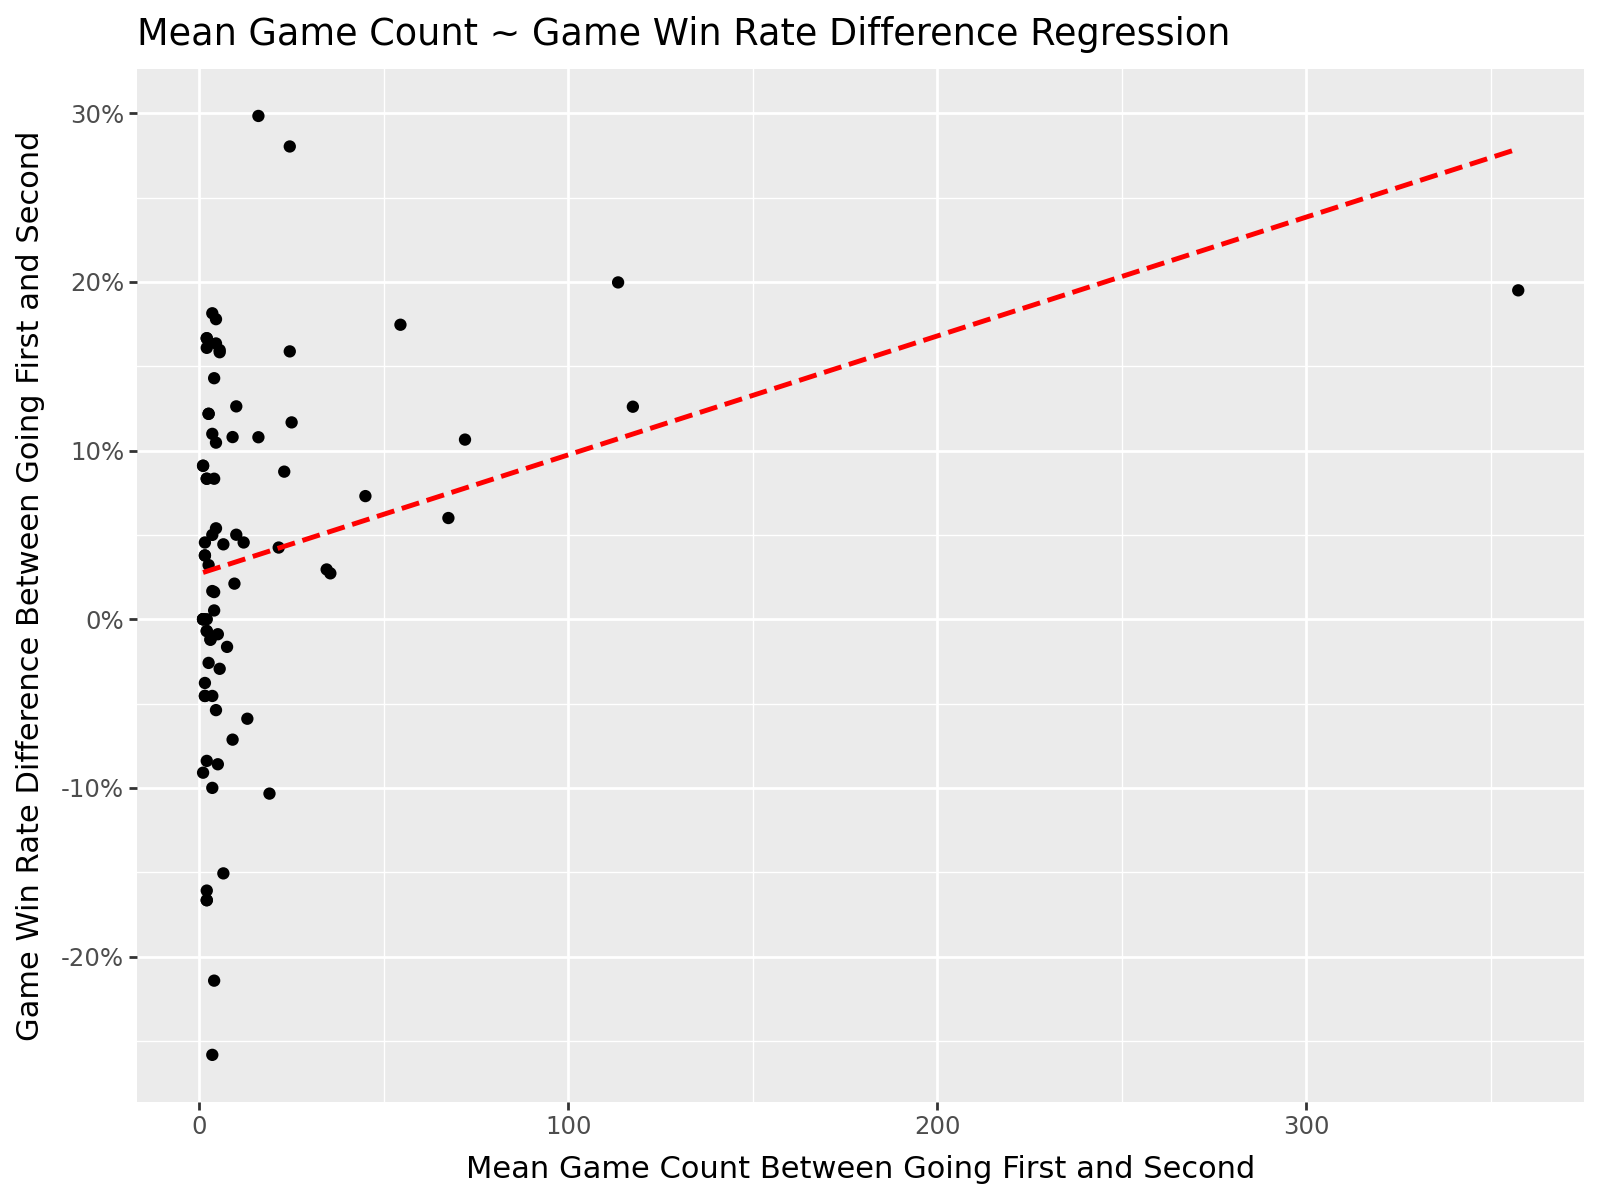

In [469]:
(
    ggplot(
        dtgwr_bmwgf_base_df,
        aes(x="mean_count", y="wr_wf_diff")
    )
    + geom_point()
    + geom_smooth(method="lm", se=False, color="red", linetype="dashed")
    + scale_y_continuous(labels=lambda x: [f"{label:.0f}%" for label in x])
    + labs(
        title="Mean Game Count ~ Game Win Rate Difference Regression",
        x="Mean Game Count Between Going First and Second",
        y="Game Win Rate Difference Between Going First and Second"
    )
    + theme(
        figure_size=(8, 6),
        plot_title=element_text(ha="left")
    )
)

With that out the way, let's finally look at the matchups whose win rate is very impacted by going first vs second.

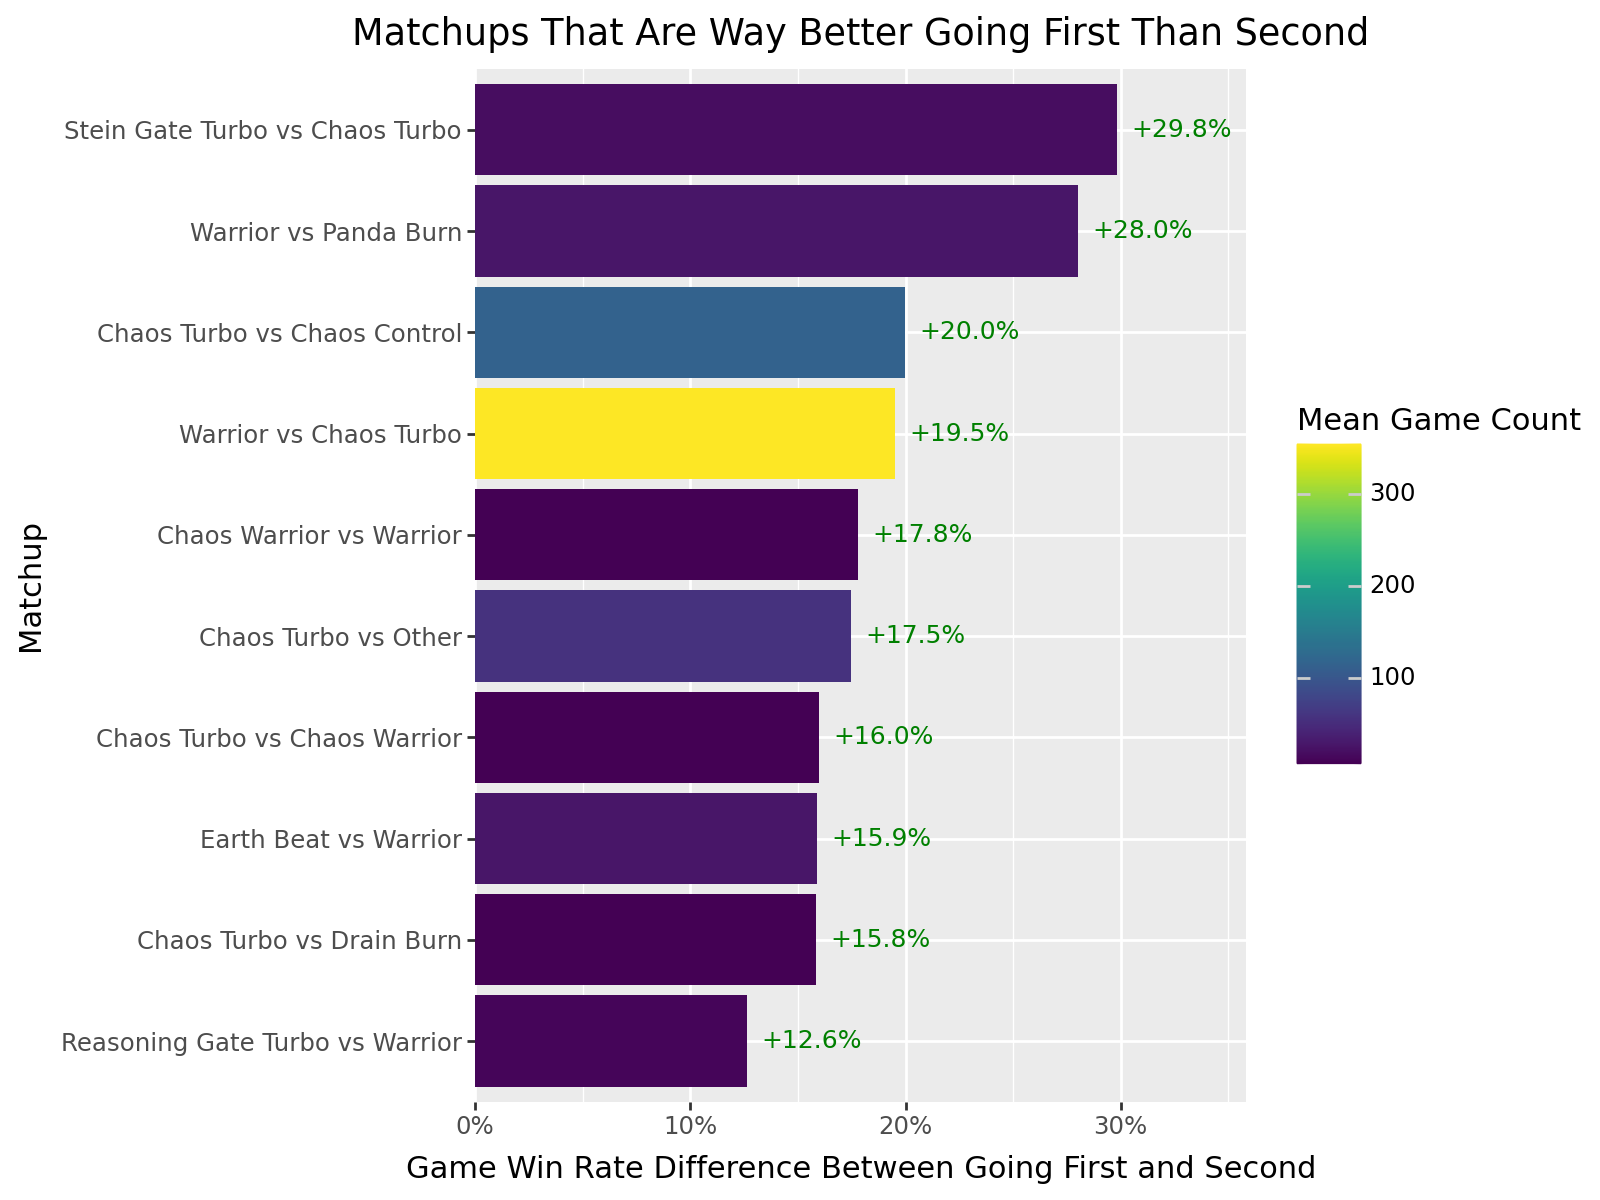

In [470]:
dtgwr_bmwgf_plot_df = (
    dtgwr_bmwgf_base_df
    .filter(pl.col("count_went_first") >= 5, pl.col("count_went_first") >= 5)
    .sort("wr_wf_diff", descending=True)
    .head(10)
)

(
    ggplot(
        dtgwr_bmwgf_plot_df,
        aes(x="reorder(matchup, wr_wf_diff)", y="wr_wf_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="wr_wf_diff"),
        format_string="+{:.1f}%",
        nudge_y=3,
        size=9,
        color="green"
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 3)
    )
    + labs(
        title="Matchups That Are Way Better Going First Than Second",
        x="Matchup",
        y="Game Win Rate Difference Between Going First and Second",
        fill="Mean Game Count"
    )
    + theme(
        figure_size=(8, 6)
    )
)

### Best Matchups Preside vs Postside

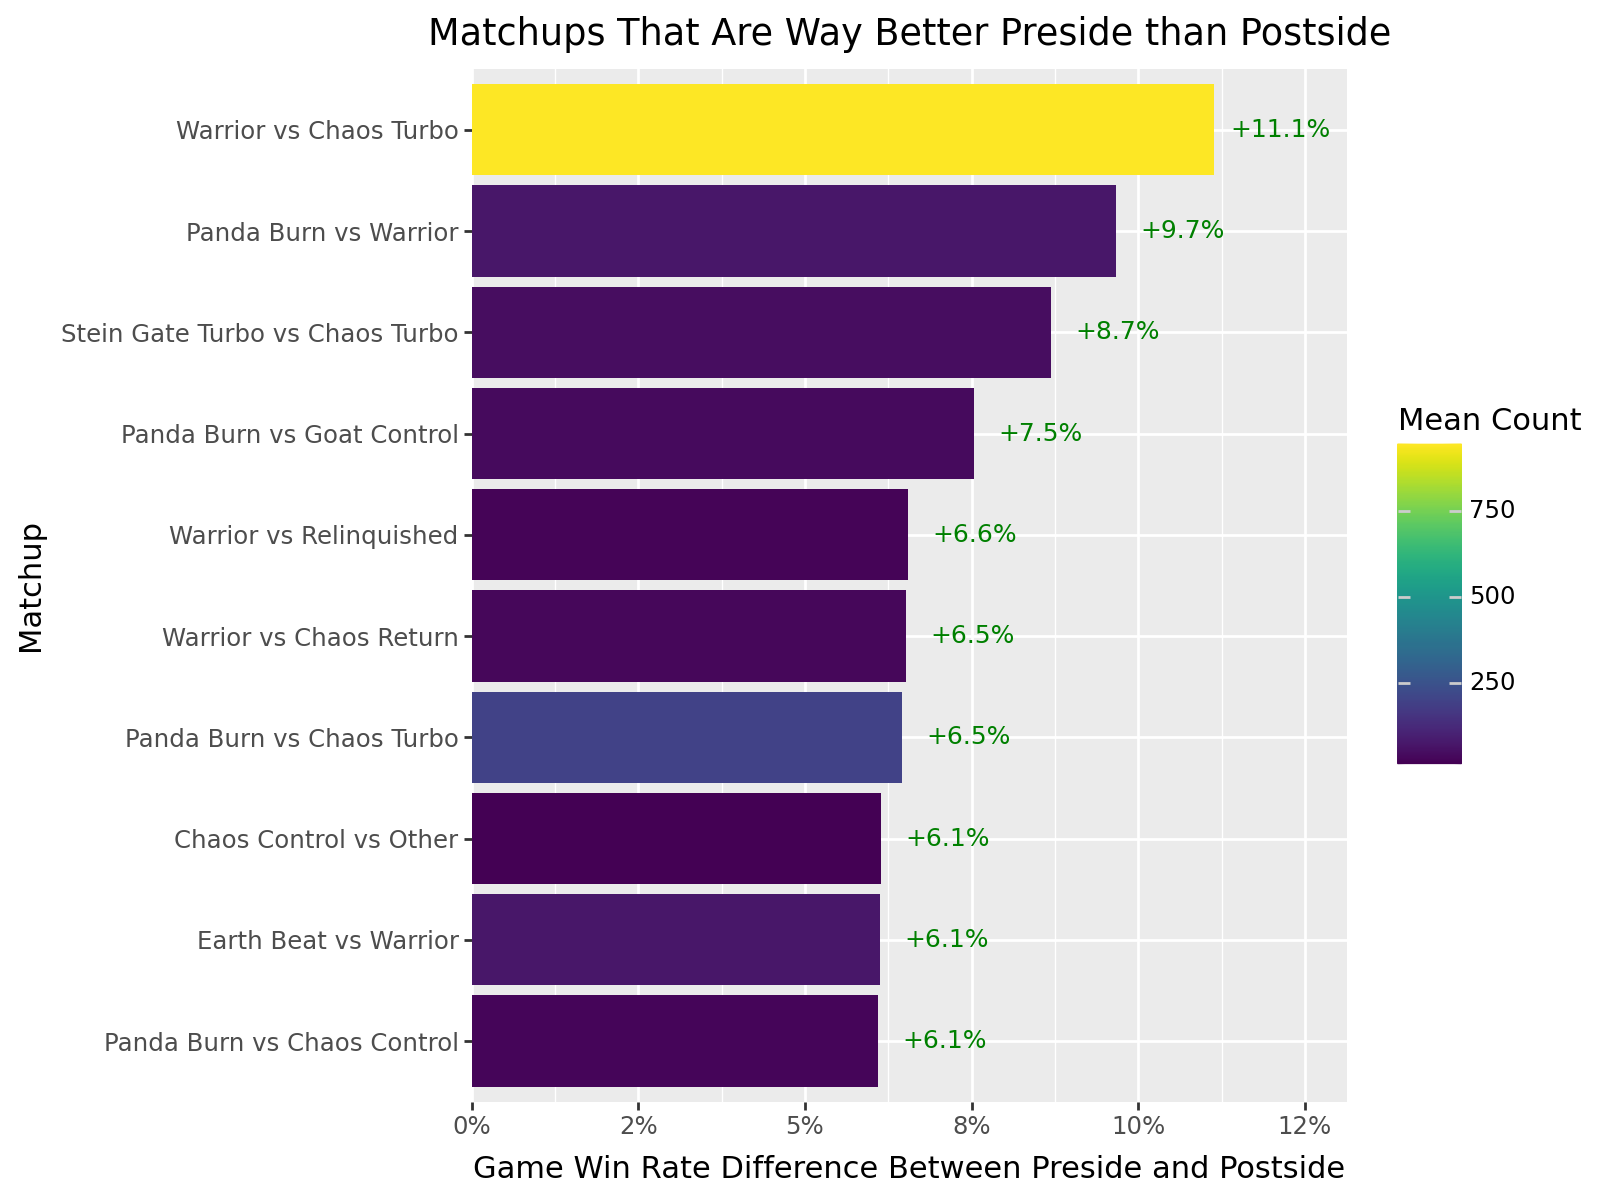

In [ ]:
dtgwr_bmpvp_plot_df = (
    final_cards_df
    .select("replay_url", "game_number", cs.contains("match") & ~cs.matches("conf"), "player_won", "side_type")
    .unique(["replay_url", "game_number", cs.contains("deck_type")])
    .filter(pl.col("player_match_deck_type") != pl.col("opp_match_deck_type"))
    .group_by("side_type", cs.contains("deck_type"))
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
    .pivot(
        on="side_type",
        index=cs.contains("deck_type"),
        values=["count", "adj_win_rate"]
    )
    .with_columns(
        matchup=pl.concat_str(pl.col("player_match_deck_type"), pl.col("opp_match_deck_type"), separator=" vs "),
        wr_ps_diff=pl.col("adj_win_rate_preside") - pl.col("adj_win_rate_postside"),
        mean_count=pl.mean_horizontal(cs.contains("count"))
    )
    .filter(pl.col("count_preside") >= 5, pl.col("count_postside") >= 5)
    .top_k(10, by="wr_ps_diff")
)

(
    ggplot(
        dtgwr_bmpvp_plot_df,
        aes(x="reorder(matchup, wr_ps_diff)", y="wr_ps_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="wr_ps_diff"),
        format_string="+{:.1f}%",
        nudge_y=1,
        size=9,
        color="green"
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 1)
    )
    + labs(
        title="Matchups That Are Way Better Preside than Postside",
        x="Matchup",
        y="Game Win Rate Difference Between Preside and Postside",
        fill="Mean Count"
    )
    + theme(
        figure_size=(8, 6)
    )
)

## Card Game Win Rate

### Best and Worst Cards

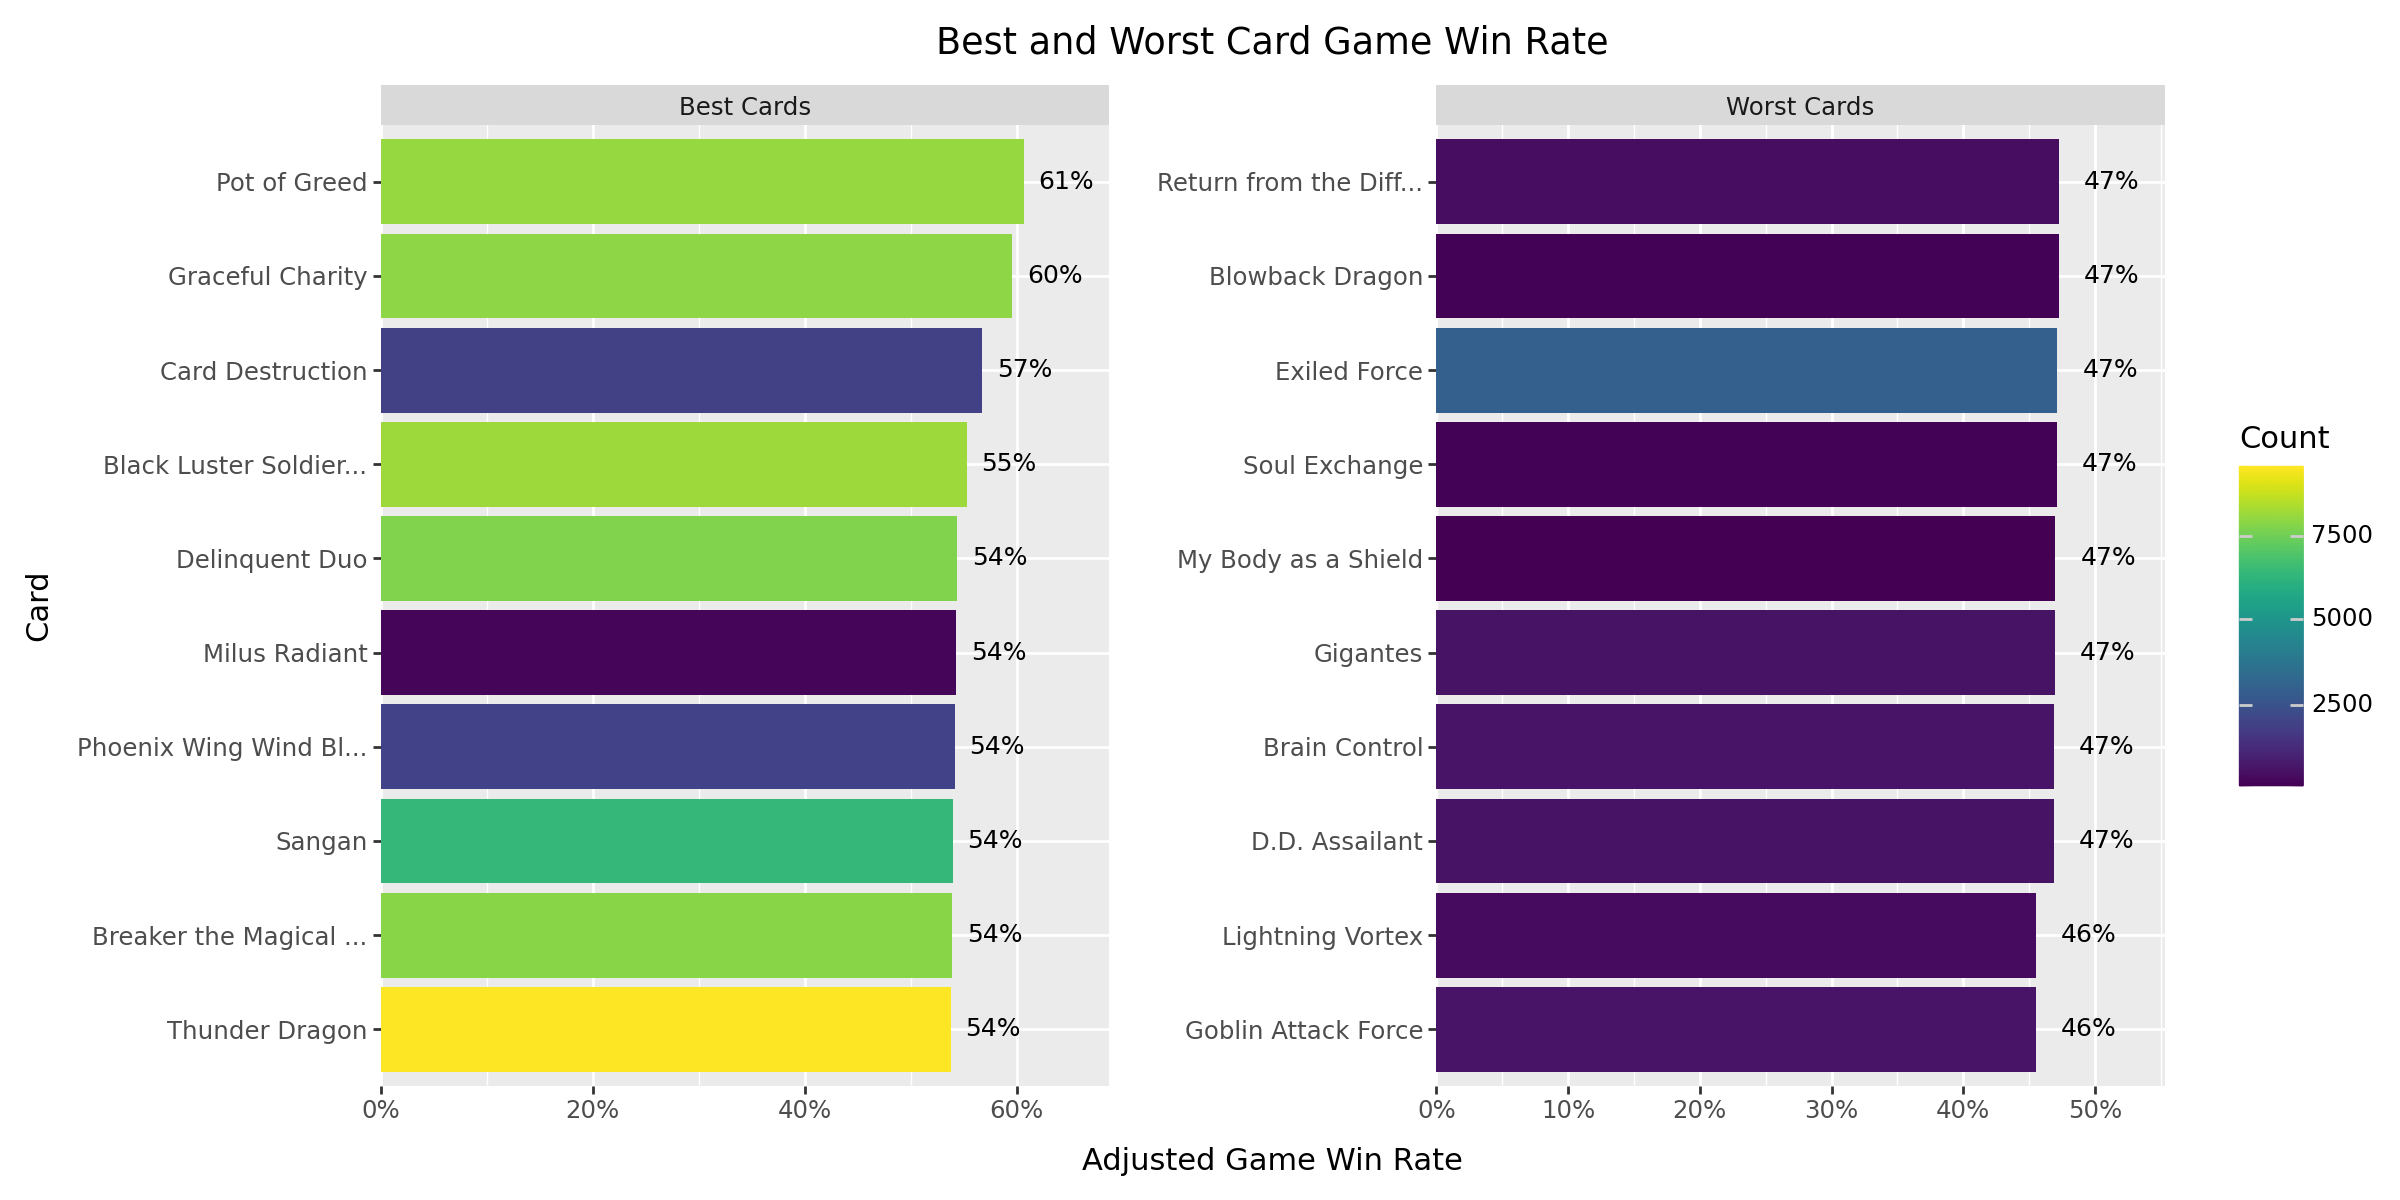

In [472]:
cwr_bawc_base_df = (
    final_cards_df
    .group_by("player_card_name")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], 250),
            return_dtype=float
        )
    )
)

cwr_bawc_plot_df = reorder_within(
    pl
    .concat([
        cwr_bawc_base_df
            .with_columns(group=pl.lit("Best Cards"))
            .top_k(k=10, by="adj_win_rate"),
        cwr_bawc_base_df
            .with_columns(group=pl.lit("Worst Cards"))
            .top_k(k=10, by="adj_win_rate", reverse=True),
    ]),
    x="player_card_name",
    by="adj_win_rate",
    within="group"
).to_pandas()

# Reorder groups so that Best Cards is to the left
cwr_bawc_plot_df["group"] = pd.Categorical(
    values=[value for value in cwr_bawc_plot_df["group"]],
    categories=["Best Cards", "Worst Cards"],
    ordered=True
)

(
    ggplot(
        cwr_bawc_plot_df,
        aes(x="reorder(player_card_name_ordered, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.0f}%",
        nudge_y=4,
        size=9
    )
    + scale_x_discrete(
        labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)]
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 4)
    )
    + labs(
        title="Best and Worst Card Game Win Rate",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + facet_wrap("group", scales="free")
    + theme(
        figure_size=(12, 6)
    )
)

### Best and Worst Cards When Going First

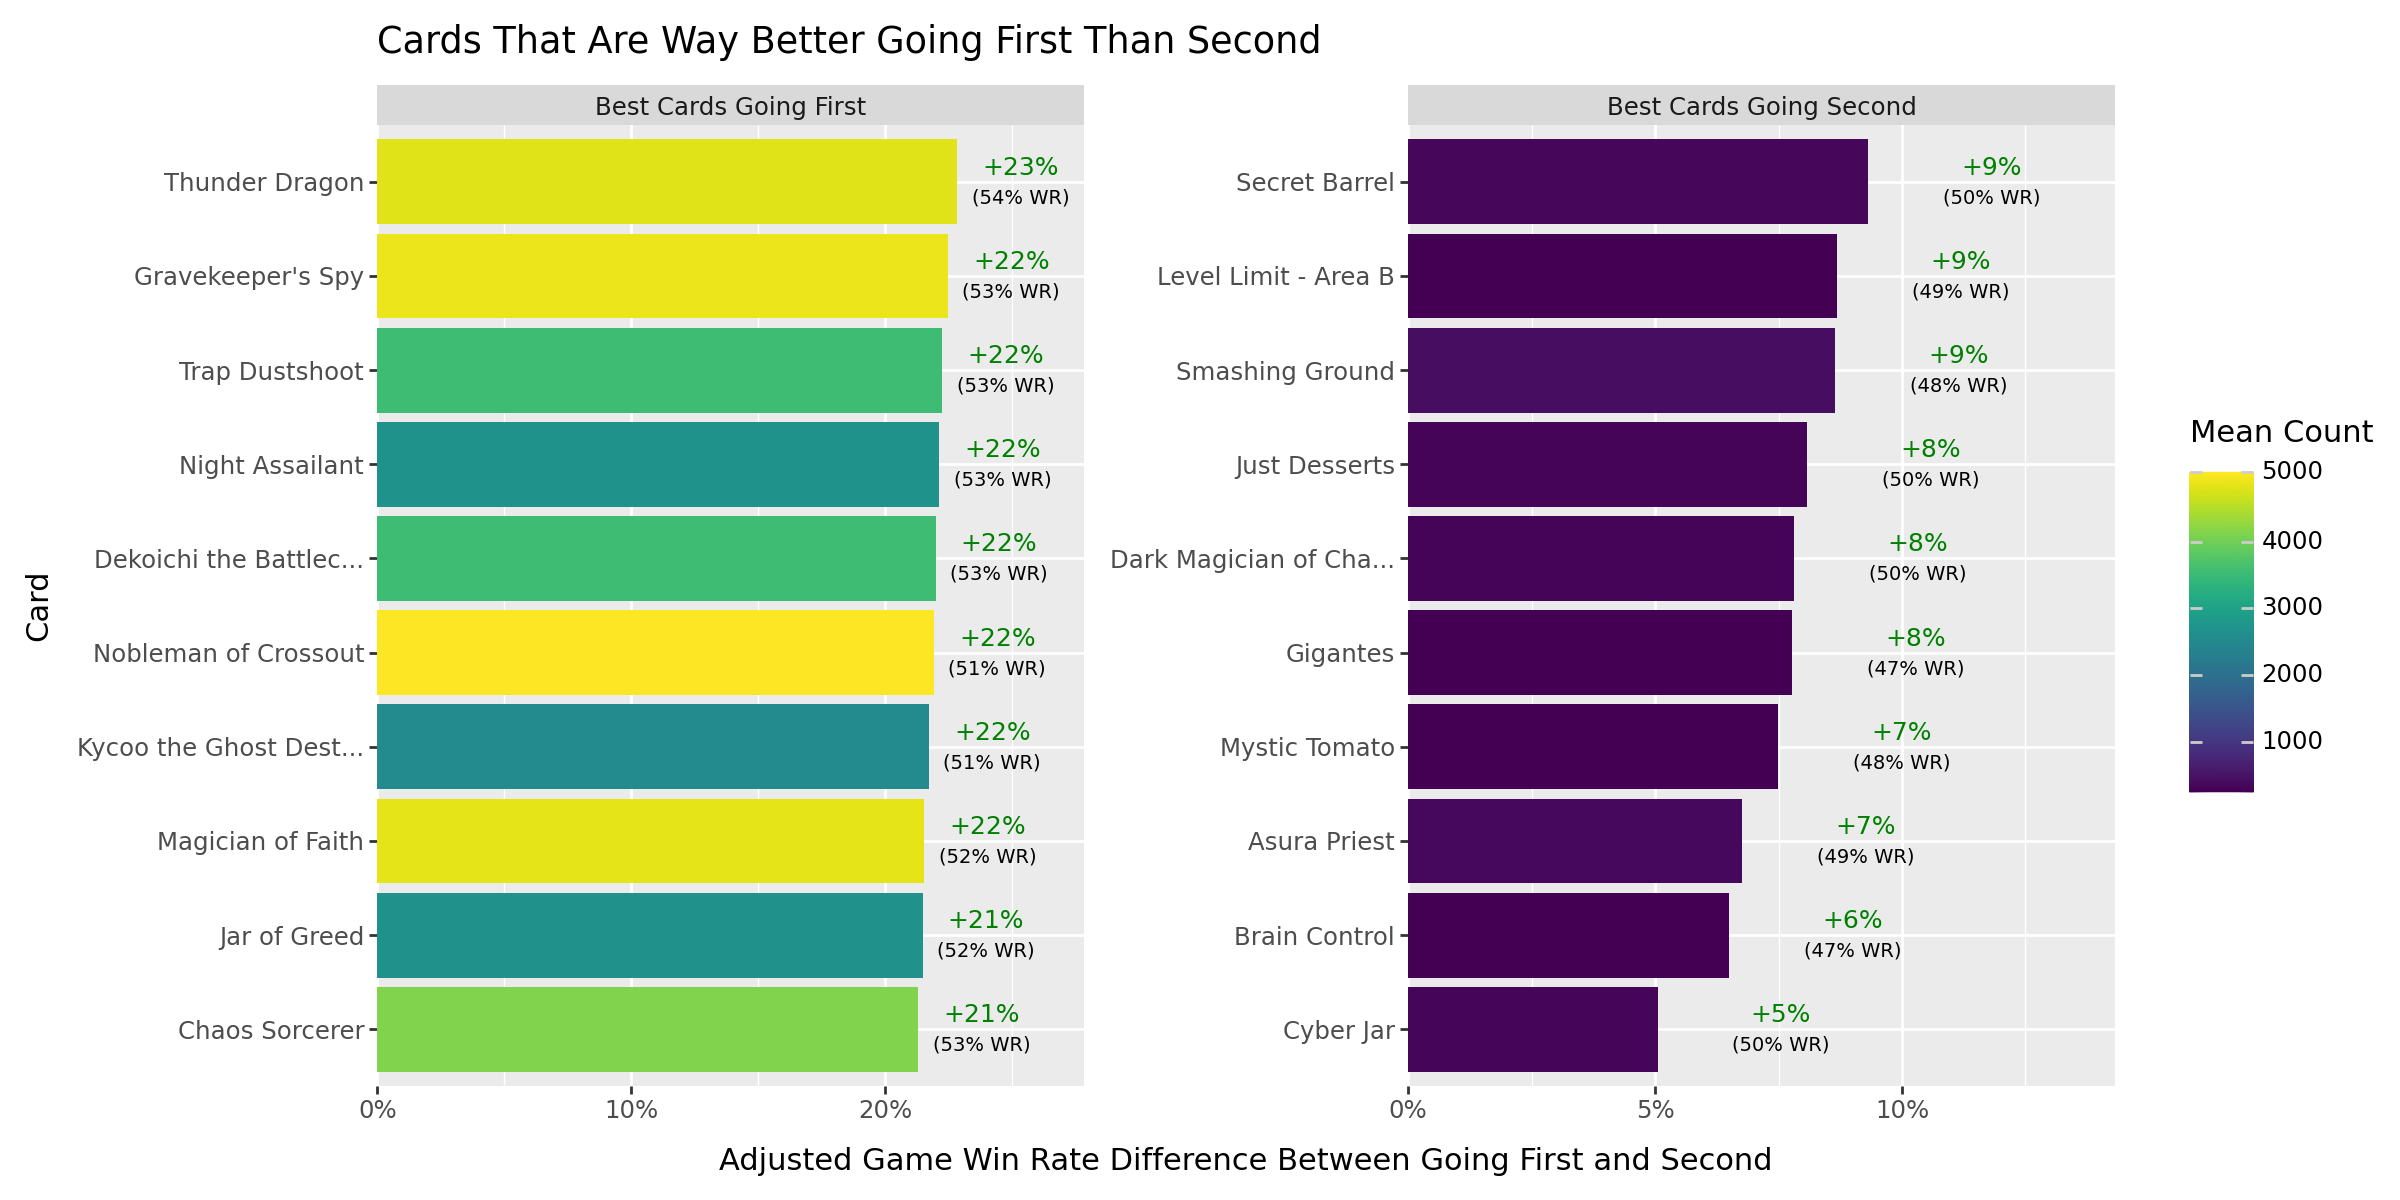

In [473]:
cwr_bawcwgf_base_df = (
    final_cards_df
    .group_by("player_card_name", "player_went_first")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], K=250),
            return_dtype=float
        ),
        player_went_first=pl.when(pl.col("player_went_first"))
            .then(pl.lit("went_first"))
            .otherwise(pl.lit("went_second"))
    )
    .pivot(
        on="player_went_first",
        index="player_card_name",
        values=["count", "adj_win_rate"]
    )
    .drop_nulls()
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_wf_diff=pl.col("adj_win_rate_went_first") - pl.col("adj_win_rate_went_second")
    )
    .filter(pl.col("mean_count") >= 250)
    .join(
        cwr_bawc_base_df.select("player_card_name", "adj_win_rate"),
        on="player_card_name",
        how="left"
    )
    .sort("wr_wf_diff", descending=True)
)

cwr_bawcwgf_plot_df = reorder_within(
    pl.concat([
        cwr_bawcwgf_base_df
            .with_columns(group=pl.lit("Best Cards Going First"))
            .top_k(k=10, by="wr_wf_diff"),
        cwr_bawcwgf_base_df
            .with_columns(group=pl.lit("Best Cards Going Second"))
            .top_k(k=10, by="wr_wf_diff", reverse=True)
    ]),
    x="player_card_name",
    by="wr_wf_diff",
    within="group"
).to_pandas()

# Reorder groups so that Best Cards Going First is to the left
cwr_bawcwgf_plot_df["group"] = pd.Categorical(
    values=[value for value in cwr_bawcwgf_plot_df["group"]],
    categories=["Best Cards Going First", "Best Cards Going Second"],
    ordered=True
)

(
    ggplot(
        cwr_bawcwgf_plot_df,
        aes(x="reorder(player_card_name_ordered, wr_wf_diff)", y="wr_wf_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="wr_wf_diff"),
        format_string="+{:.0f}%",
        nudge_x=.15,
        nudge_y=2.5,
        size=9,
        color="green"
    )
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="({:.0f}% WR)",
        nudge_x=-.17,
        nudge_y=2.5,
        size=7
    )
    + scale_x_discrete(
        labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)]
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 2.5)
    )
    + labs(
        title="Cards That Are Way Better Going First Than Second",
        x="Card",
        y="Adjusted Game Win Rate Difference Between Going First and Second",
        fill="Mean Count"
    )
    + facet_wrap("group", scales="free")
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

### Best and Worst Cards Preside

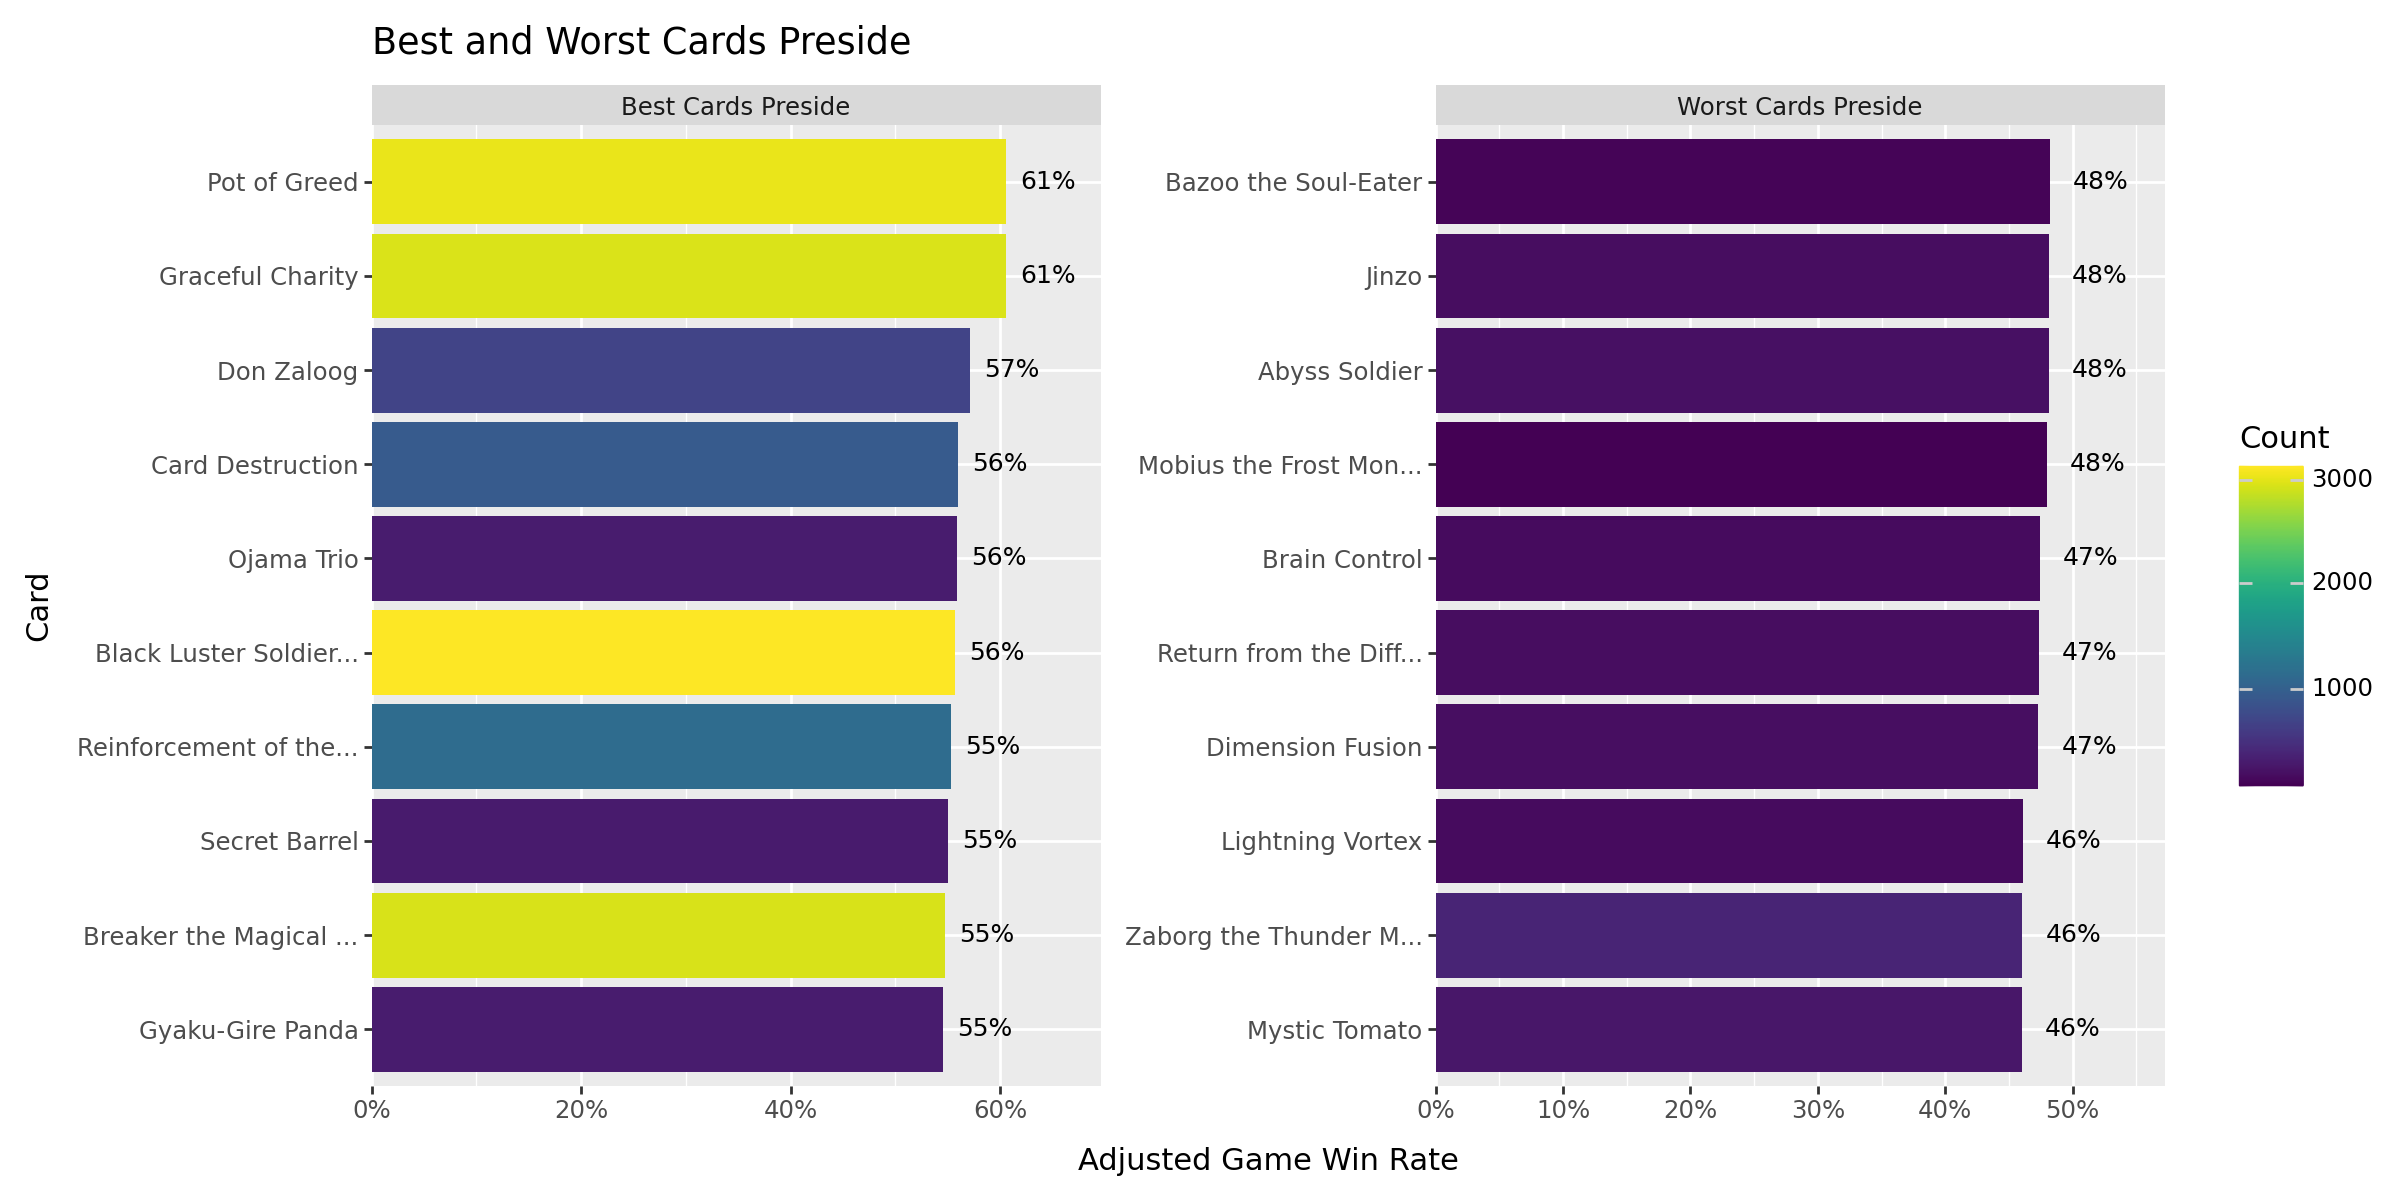

In [493]:
cwr_bawc_base_df = (
    final_cards_df
    .group_by("player_card_name", "side_type")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], K=250),
            return_dtype=float
        )
    )
    .sort("adj_win_rate", descending=True)
)

cwr_bawc_preside_plot_df = reorder_within(
    pl.concat([
        cwr_bawc_base_df
            .filter(pl.col("side_type") == "preside")
            .group_by("side_type")
            .head(10)
            .with_columns(group=pl.lit("Best Cards Preside")),
            
        cwr_bawc_base_df
            .filter(pl.col("side_type") == "preside")
            .group_by("side_type")
            .tail(10)
            .with_columns(group=pl.lit("Worst Cards Preside"))
    ]),
    x="player_card_name",
    by="adj_win_rate",
    within="group"
).to_pandas()

# Reorder groups so that Best Cards Preside is to the left
cwr_bawc_preside_plot_df["group"] = pd.Categorical(
    values=[value for value in cwr_bawc_preside_plot_df["group"]],
    categories=["Best Cards Preside", "Worst Cards Preside"],
    ordered=True
)

(
    ggplot(
        cwr_bawc_preside_plot_df,
        aes(x="reorder(player_card_name_ordered, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.0f}%",
        nudge_y=4,
        size=9
    )
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 5)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Best and Worst Cards Preside",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

### Best and Worst Cards Postside

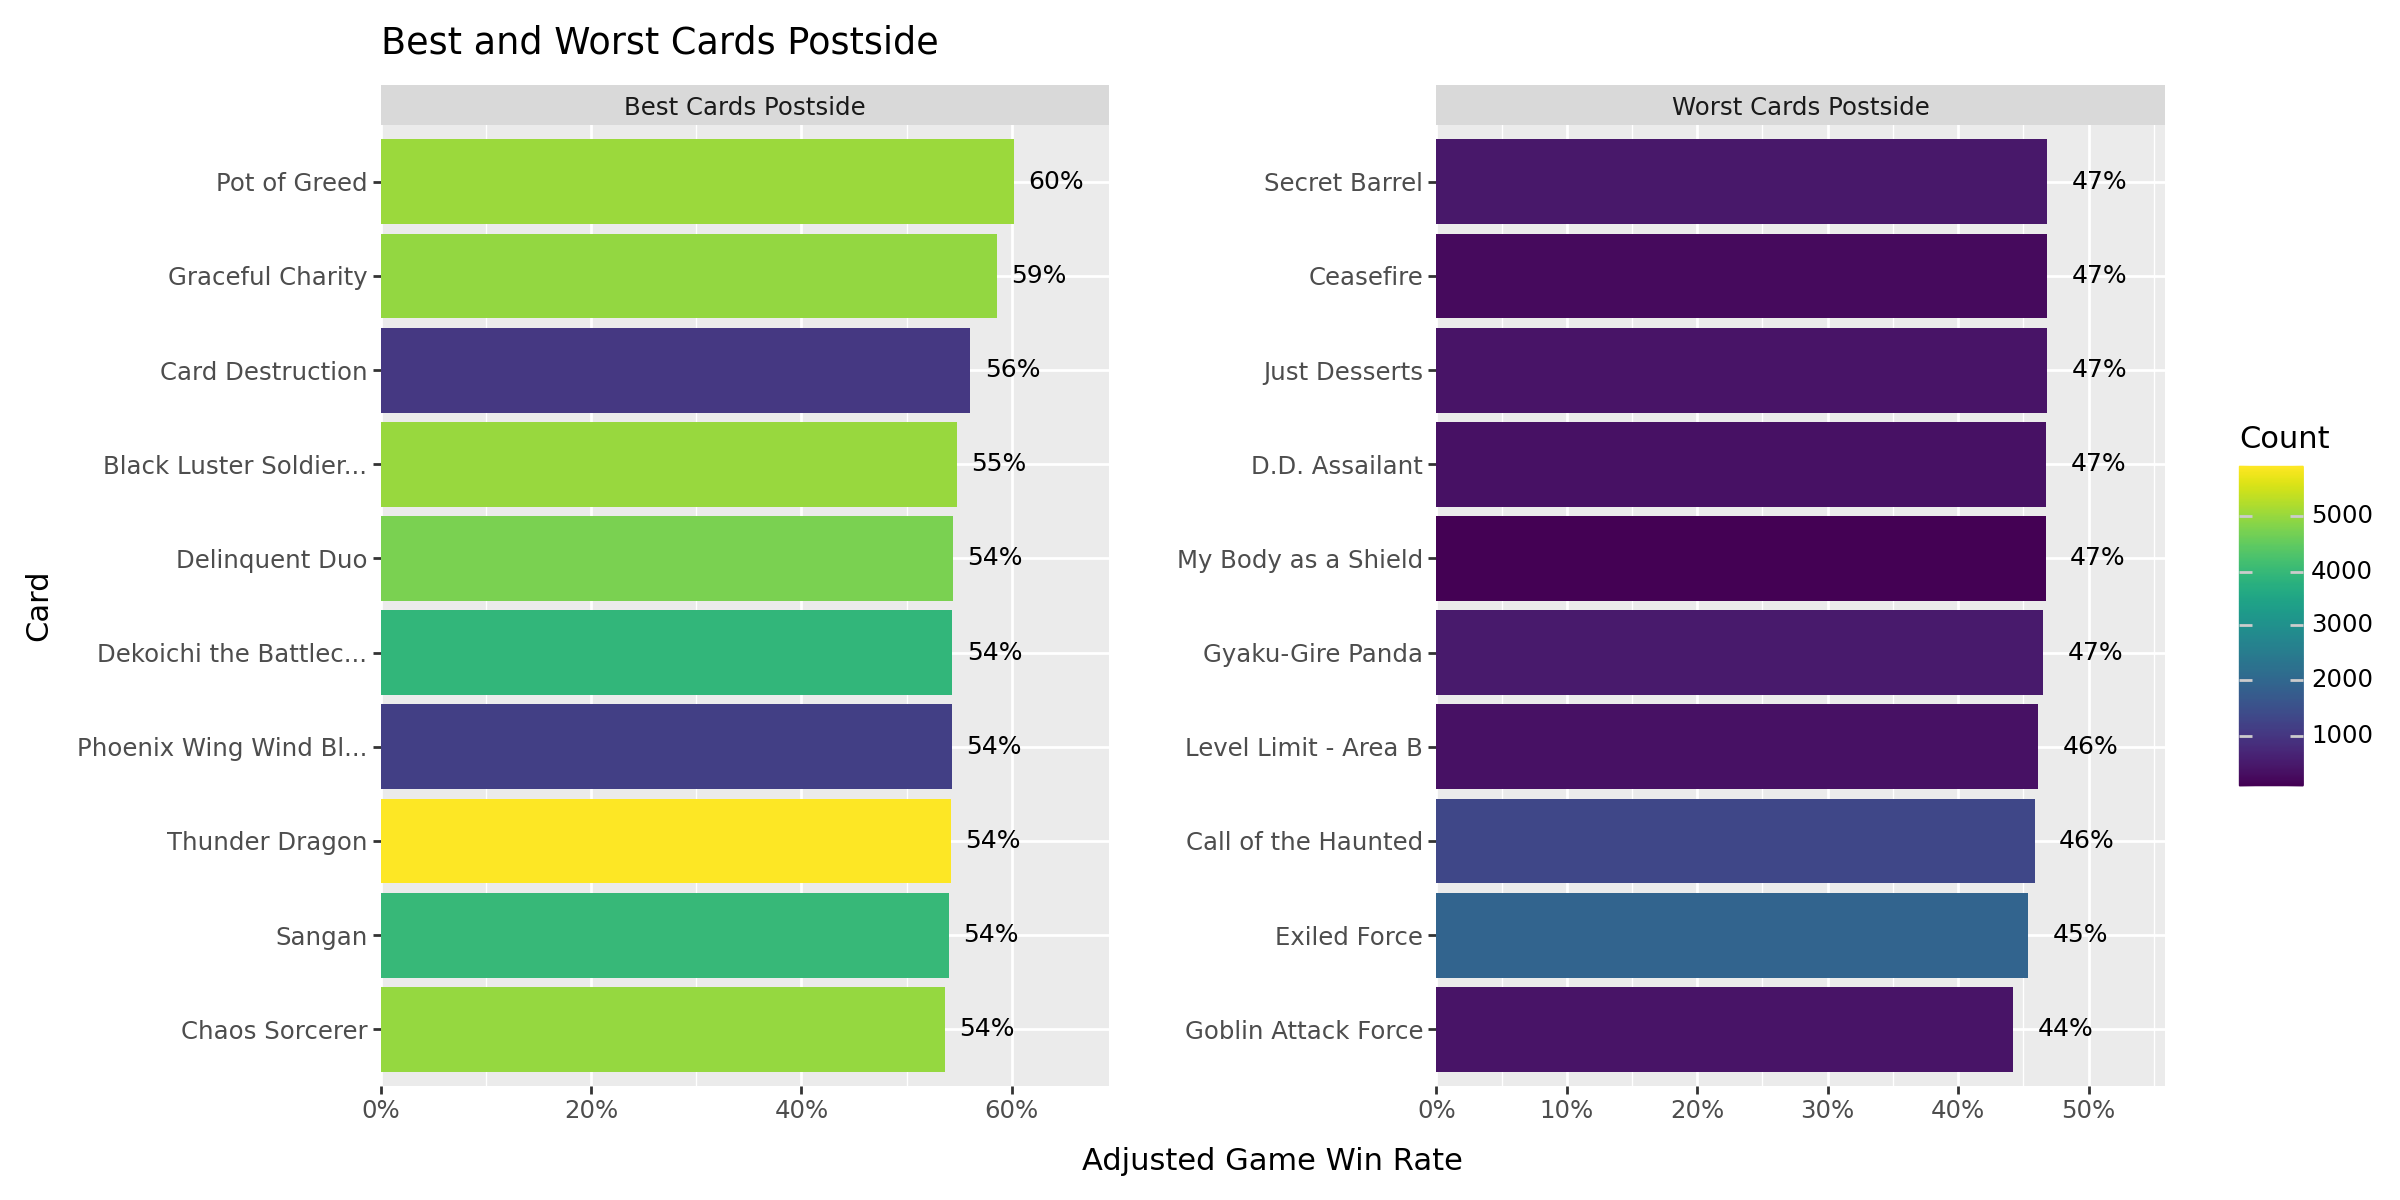

In [494]:

cwr_bawc_postside_plot_df = reorder_within(
    pl.concat([
        cwr_bawc_base_df
            .filter(pl.col("side_type") == "postside")
            .group_by("side_type")
            .head(10)
            .with_columns(group=pl.lit("Best Cards Postside")),
            
        cwr_bawc_base_df
            .filter(pl.col("side_type") == "postside")
            .group_by("side_type")
            .tail(10)
            .with_columns(group=pl.lit("Worst Cards Postside"))
    ]),
    x="player_card_name",
    by="adj_win_rate",
    within="group"
).to_pandas()

# Reorder groups so that Best Cards Postside is to the left
cwr_bawc_postside_plot_df["group"] = pd.Categorical(
    values=[value for value in cwr_bawc_postside_plot_df["group"]],
    categories=["Best Cards Postside", "Worst Cards Postside"],
    ordered=True
)

(
    ggplot(
        cwr_bawc_postside_plot_df,
        aes(x="reorder(player_card_name_ordered, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.0f}%",
        nudge_y=4,
        size=9
    )
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 5)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Best and Worst Cards Postside",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

### Best Cards Preside vs Postside

Unlike the past preside vs postside charts, this one takes the *same* cards and measures it's performance preside vs postside. In other words, it's a card's preside win rate minus it's postside win rate. 

The major difference is that in the previous charts, you would mostly just see *good* or *bad* cards in general, eg. trinities being common in best cards or basic cards from high win rate decks. Here, you would see which cards falls off the hardest postside.

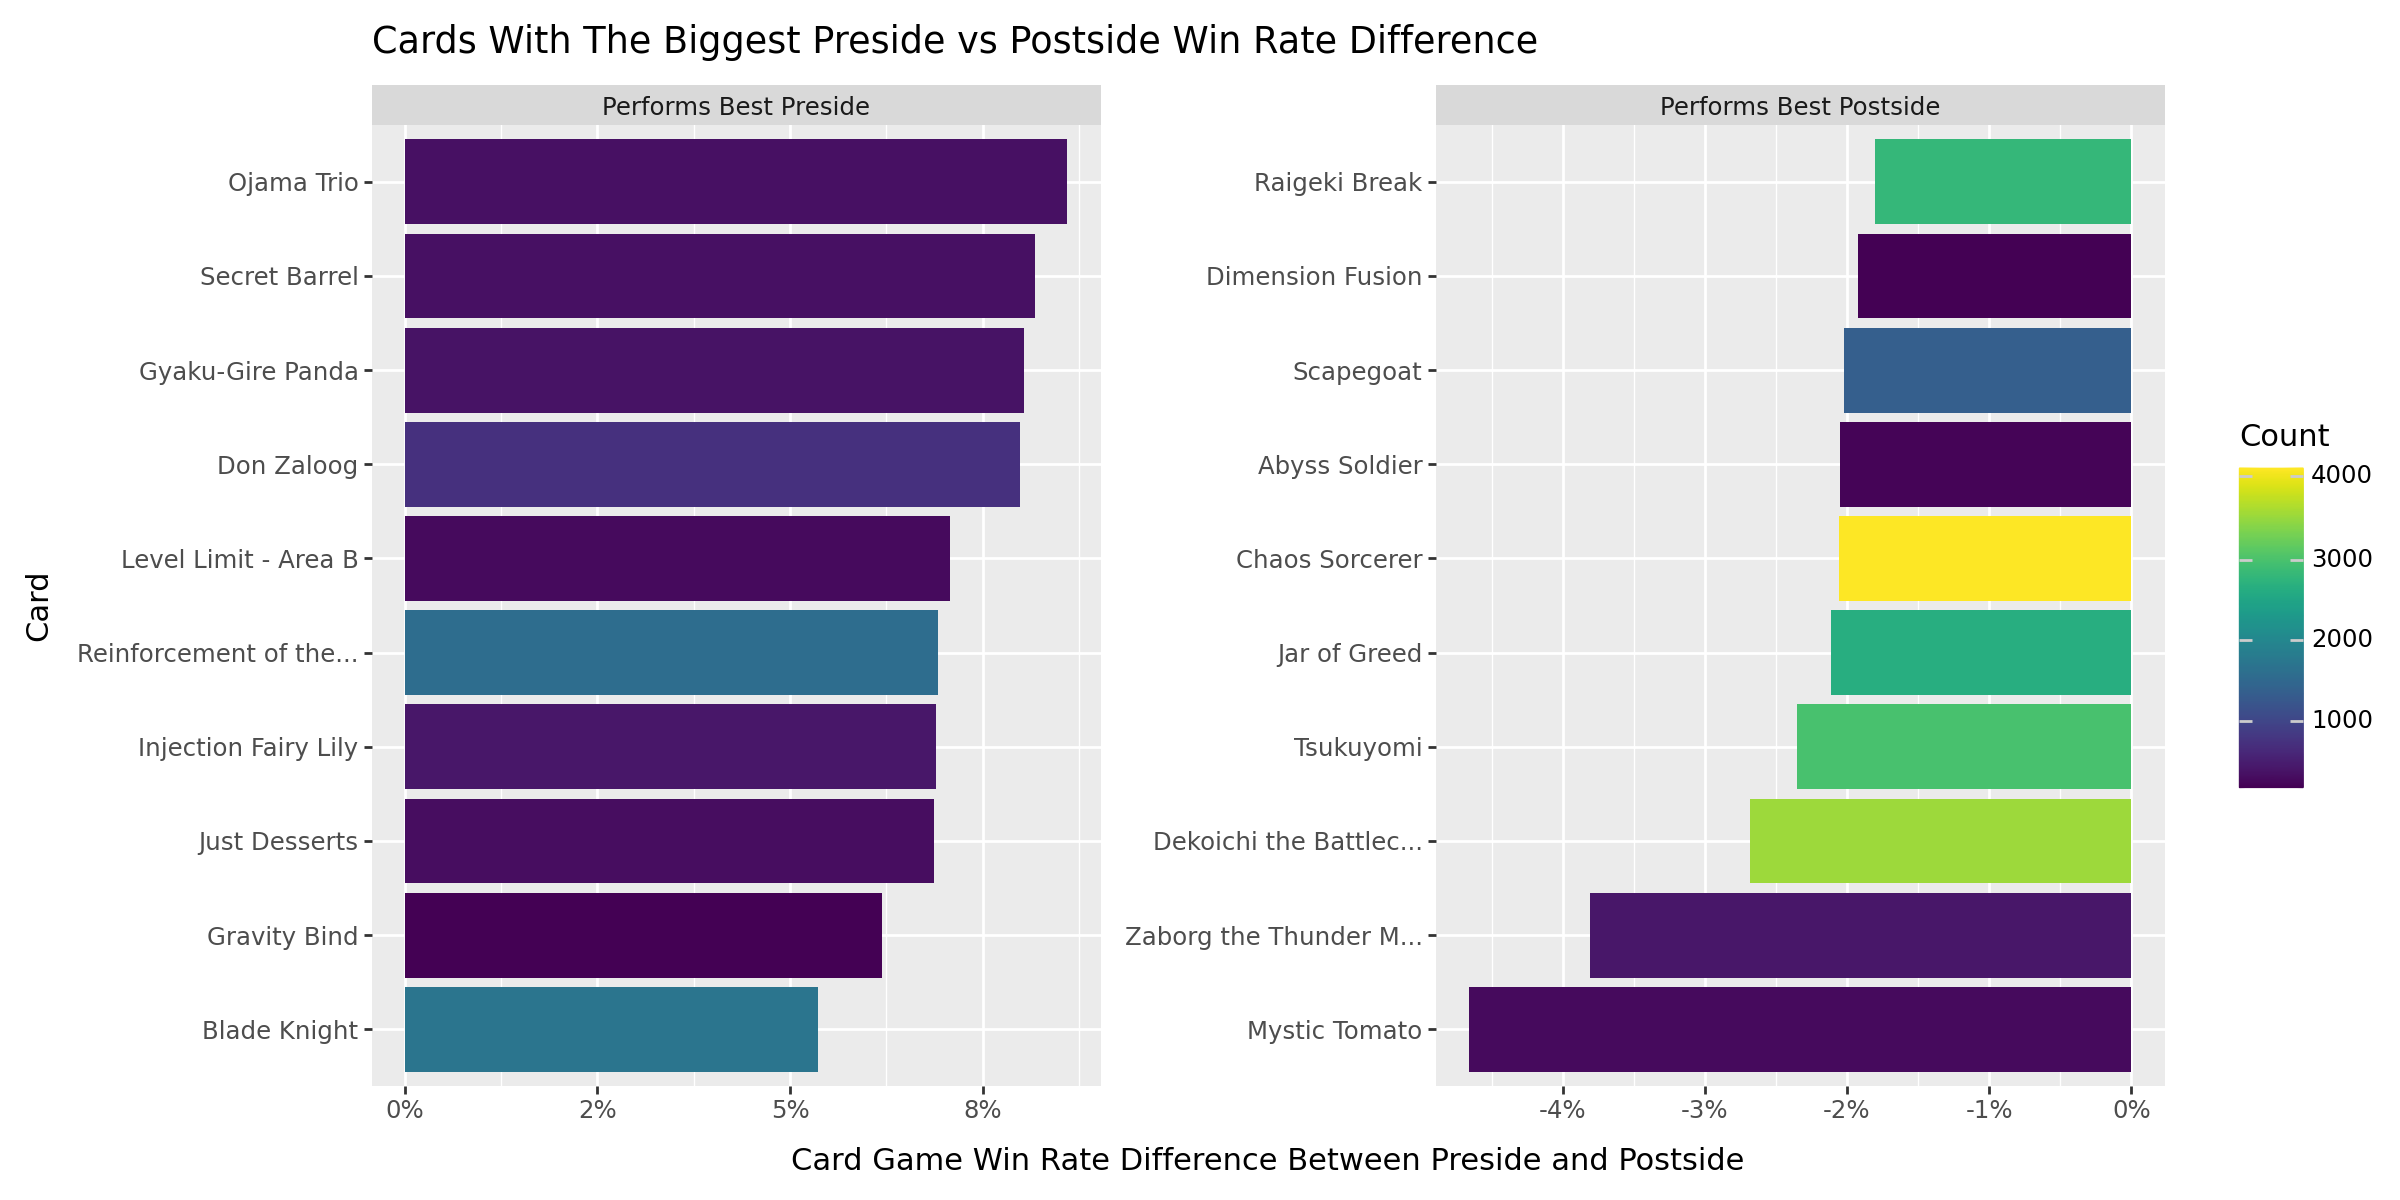

In [476]:
cwr_bcpvp_base_df = (
    cwr_bawc_base_df
    .filter(pl.col("count") >= 100)
    .pivot(
        on="side_type",
        index="player_card_name",
        values=["count", "adj_win_rate"]
    )
    .drop_nulls()
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_pvp_diff=pl.col("adj_win_rate_preside") - pl.col("adj_win_rate_postside")
    )
)

cwr_bcpvp_plot_df = pl.concat([
    cwr_bcpvp_base_df
        .top_k(k=10, by="wr_pvp_diff")
        .with_columns(group=pl.lit("Performs Best Preside")),
    cwr_bcpvp_base_df
        .top_k(k=10, by="wr_pvp_diff", reverse=True)
        .with_columns(group=pl.lit("Performs Best Postside"))
]).to_pandas()

# Reorder columns
cwr_bcpvp_plot_df["group"] = pd.Categorical(
    values=[value for value in cwr_bcpvp_plot_df["group"]],
    categories=["Performs Best Preside", "Performs Best Postside"],
    ordered=True
)

(
    ggplot(
        cwr_bcpvp_plot_df,
        aes(x="reorder(player_card_name, wr_pvp_diff)", y="wr_pvp_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in x])
    + scale_y_continuous(labels=lambda x: [f"{label:.0f}%" for label in x])
    + facet_wrap("group", scales="free")
    + labs(
        title="Cards With The Biggest Preside vs Postside Win Rate Difference",
        x="Card",
        y="Card Game Win Rate Difference Between Preside and Postside",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

## Chaos Turbo Analysis

### Best and Worst Matchups

First, let's make the base Chaos Turbo table.

In [477]:
cta_base_df = (
    final_cards_df
    .filter(pl.col("player_match_deck_type") == "Chaos Turbo", pl.col("opp_match_deck_type") != "Chaos Turbo")
    .select("replay_url", "season", "game_number", cs.contains("match") & ~cs.contains("conf"))
    .unique(["replay_url", "season", "game_number", "player_won_match"])
    .sort(["replay_url", "game_number"])
)

with pl.Config(fmt_str_lengths=200, tbl_width_chars=200):
    print(
        cta_base_df
        .head(2)
    )

shape: (2, 7)
┌────────────────────────────────────────────┬────────┬─────────────┬────────────────────────┬─────────────────────┬──────────────────┬─────────────────────────┐
│ replay_url                                 ┆ season ┆ game_number ┆ player_match_deck_type ┆ opp_match_deck_type ┆ player_won_match ┆ player_match_went_first │
│ ---                                        ┆ ---    ┆ ---         ┆ ---                    ┆ ---                 ┆ ---              ┆ ---                     │
│ str                                        ┆ i64    ┆ i64         ┆ str                    ┆ str                 ┆ bool             ┆ bool                    │
╞════════════════════════════════════════════╪════════╪═════════════╪════════════════════════╪═════════════════════╪══════════════════╪═════════════════════════╡
│ https://duelingbook.com/replay?id=37142193 ┆ 1      ┆ 1           ┆ Chaos Turbo            ┆ Other               ┆ true             ┆ true                    │
│ https://duel

Now, the best and worst matchups for Chaos Turbo.

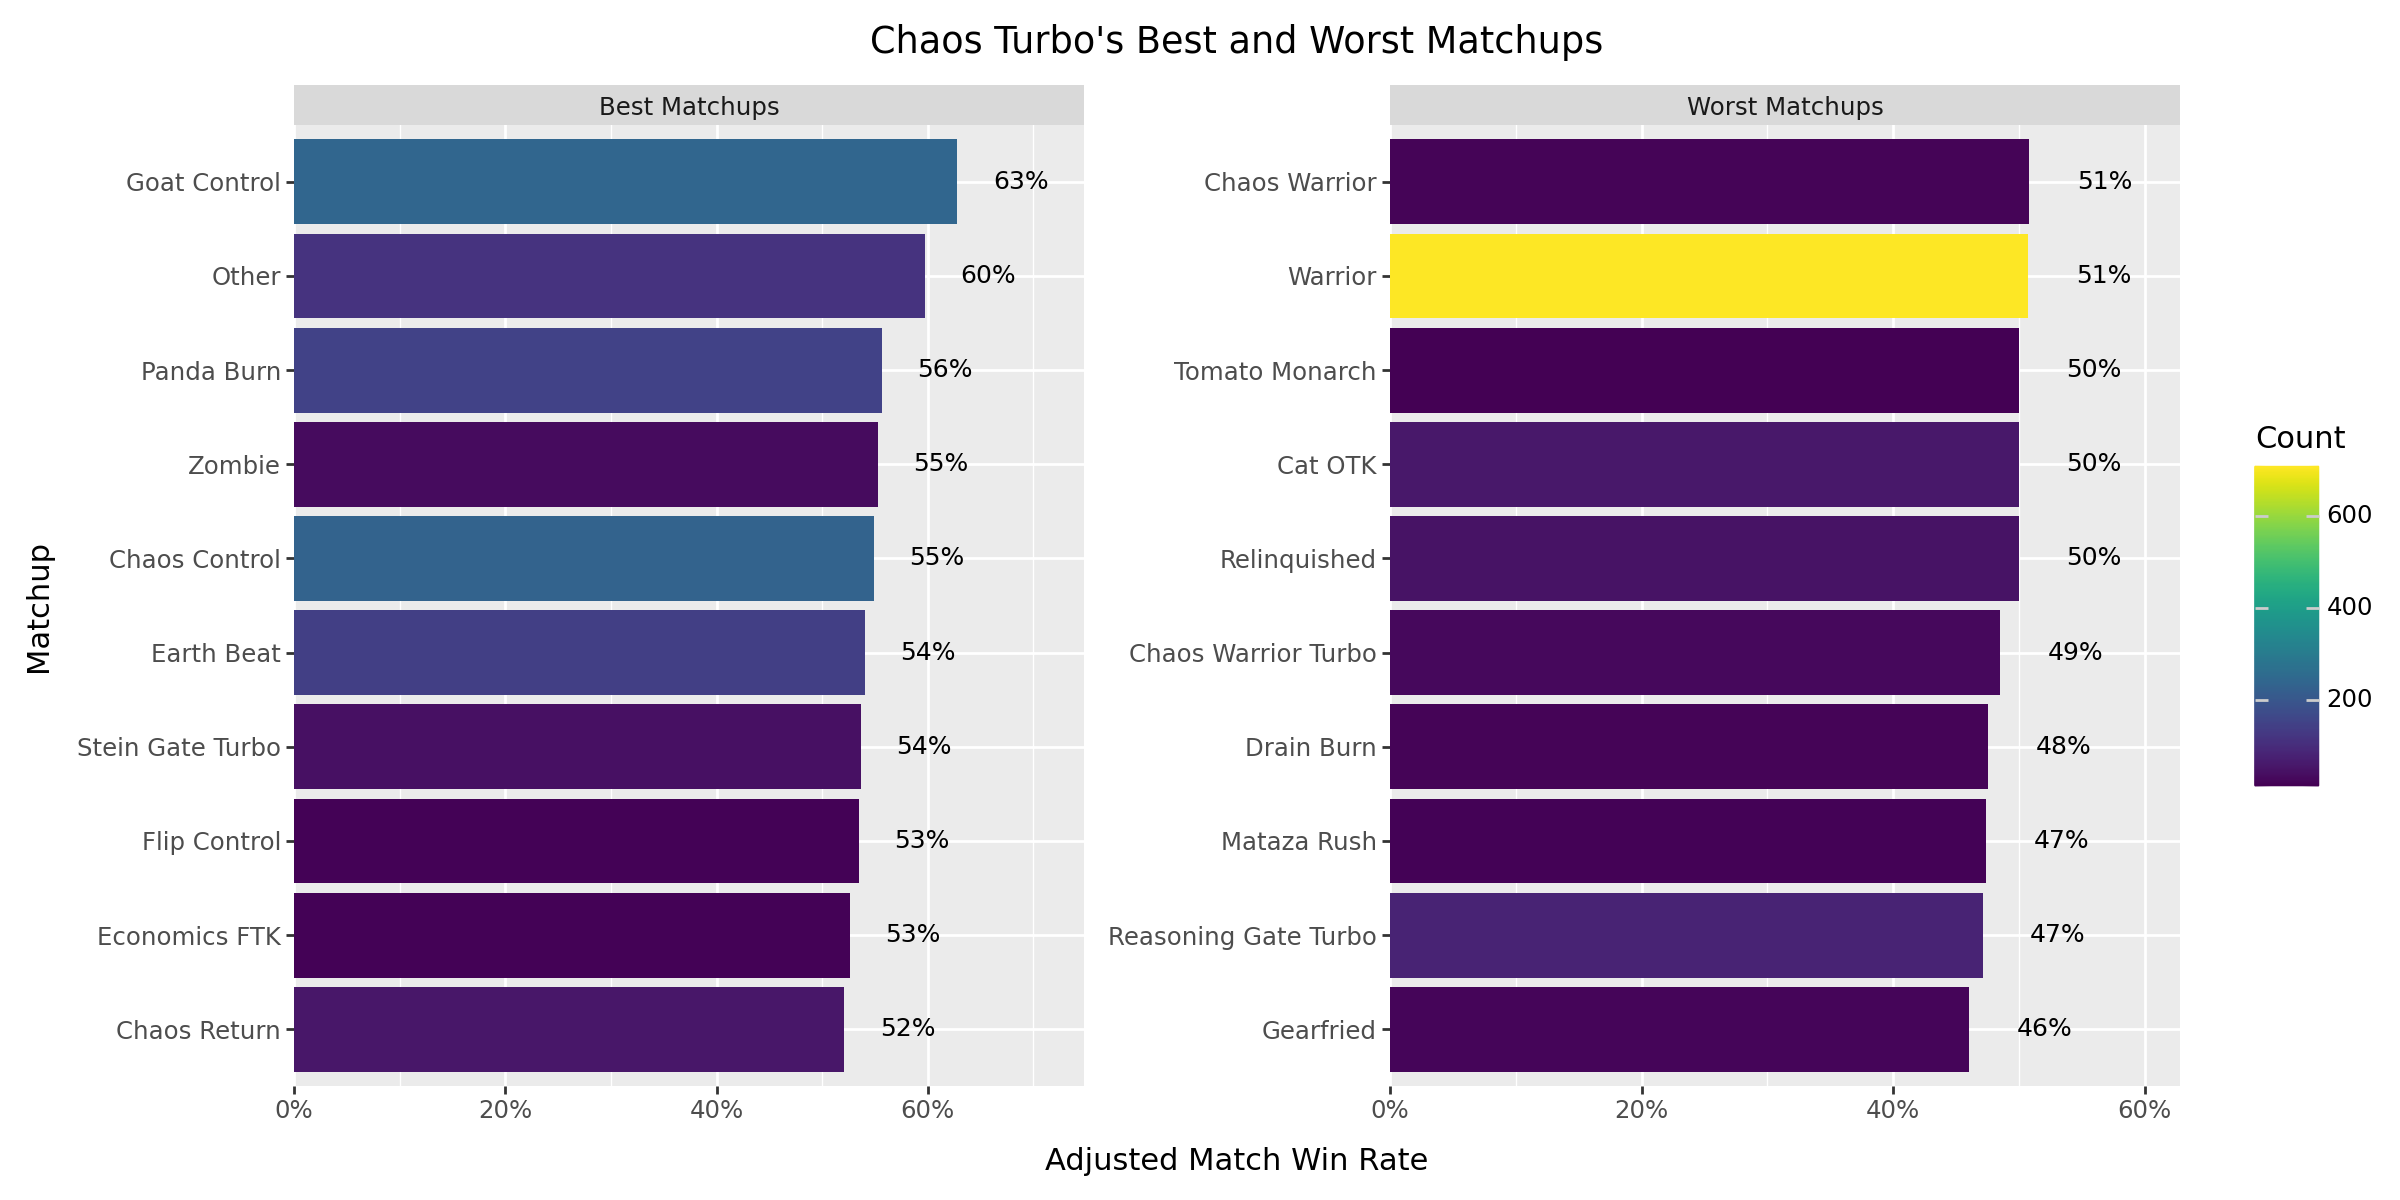

In [ ]:
cta_bawm_base_df = (
    cta_base_df
    .drop(["season", "game_number", "player_match_deck_type"])
    .unique(["replay_url", "player_won_match"])
    .group_by("opp_match_deck_type")
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
)

cta_bawm_plot_df = pl.concat([
    cta_bawm_base_df
        .top_k(10, by="adj_win_rate")
        .with_columns(group=pl.lit("Best Matchups")),
    cta_bawm_base_df
        .top_k(10, by="adj_win_rate", reverse=True)
        .with_columns(group=pl.lit("Worst Matchups"))
])

(
    ggplot(
        cta_bawm_plot_df,
        aes(x="reorder(opp_match_deck_type, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.0f}%",
        nudge_y=6,
        size=9
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 6)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo's Best and Worst Matchups",
        x="Matchup",
        y="Adjusted Match Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6)
    )
)

### Best Matchups Preside vs Postside

You can interpret this chart as, which matchups are Chaos Turbo most prepared against? If the win rate is greater preside, than poor, otherwise great.

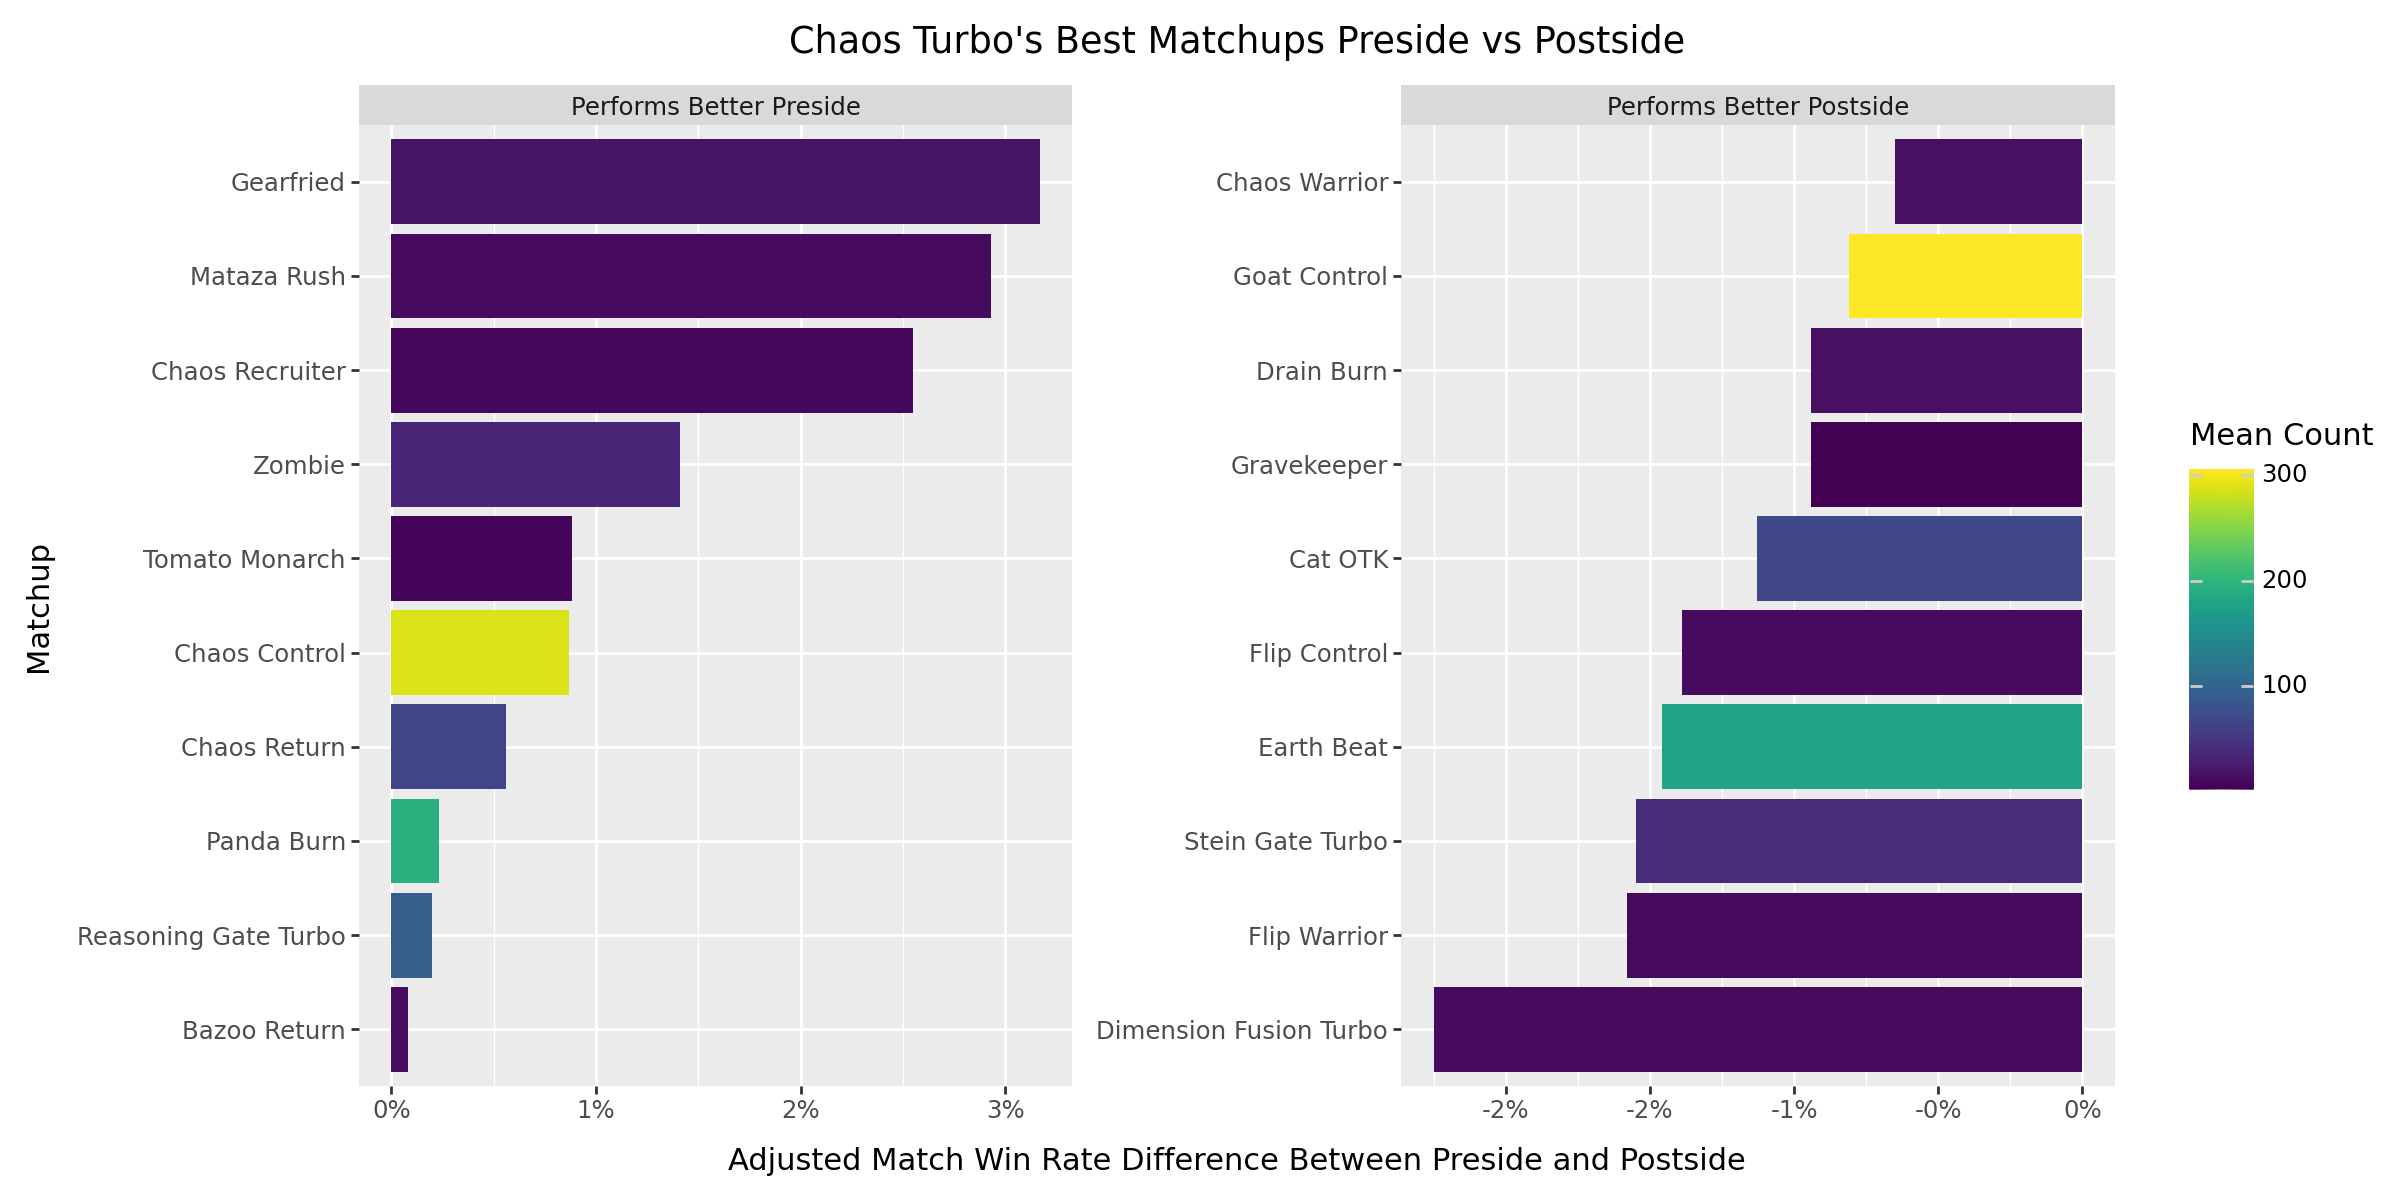

In [ ]:
cta_bmpvp_base_df = (
    final_cards_df
    .filter(pl.col("player_match_deck_type") == "Chaos Turbo", pl.col("opp_match_deck_type") != "Chaos Turbo")
    .select("replay_url", "game_number", cs.contains("match") & ~cs.matches("player_match_deck|conf"), "side_type")
    .unique(["replay_url", "game_number"])
    .group_by("opp_match_deck_type", "side_type")
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
    .pivot(
        on="side_type",
        index="opp_match_deck_type",
        values=["count", "adj_win_rate"]
    )
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_pvp_diff=pl.col("adj_win_rate_preside") - pl.col("adj_win_rate_postside")
    )
)

cta_bmpvp_plot_df = reorder_within(
    pl.concat([
        cta_bmpvp_base_df
            .top_k(10, by="wr_pvp_diff")
            .with_columns(group=pl.lit("Performs Better Preside")),
        cta_bmpvp_base_df
            .top_k(10, by="wr_pvp_diff", reverse=True)
            .with_columns(group=pl.lit("Performs Better Postside"))
    ]),
    x="opp_match_deck_type",
    by="wr_pvp_diff",
    within="group"
).to_pandas()

cta_bmpvp_plot_df["group"] = pd.Categorical(
    values=[value for value in cta_bmpvp_plot_df["group"]],
    categories=["Performs Better Preside", "Performs Better Postside"],
    ordered=True
)

(
    ggplot(
        cta_bmpvp_plot_df,
        aes(x="reorder(opp_match_deck_type_ordered, wr_pvp_diff)", y="wr_pvp_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_x_discrete(labels=remove_suffix)
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x]
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo's Best Matchups Preside vs Postside",
        x="Matchup",
        y="Adjusted Match Win Rate Difference Between Preside and Postside",
        fill="Mean Count"
    )
    + theme(
        figure_size=(12, 6)
    )
)

### Best and Worst Cards

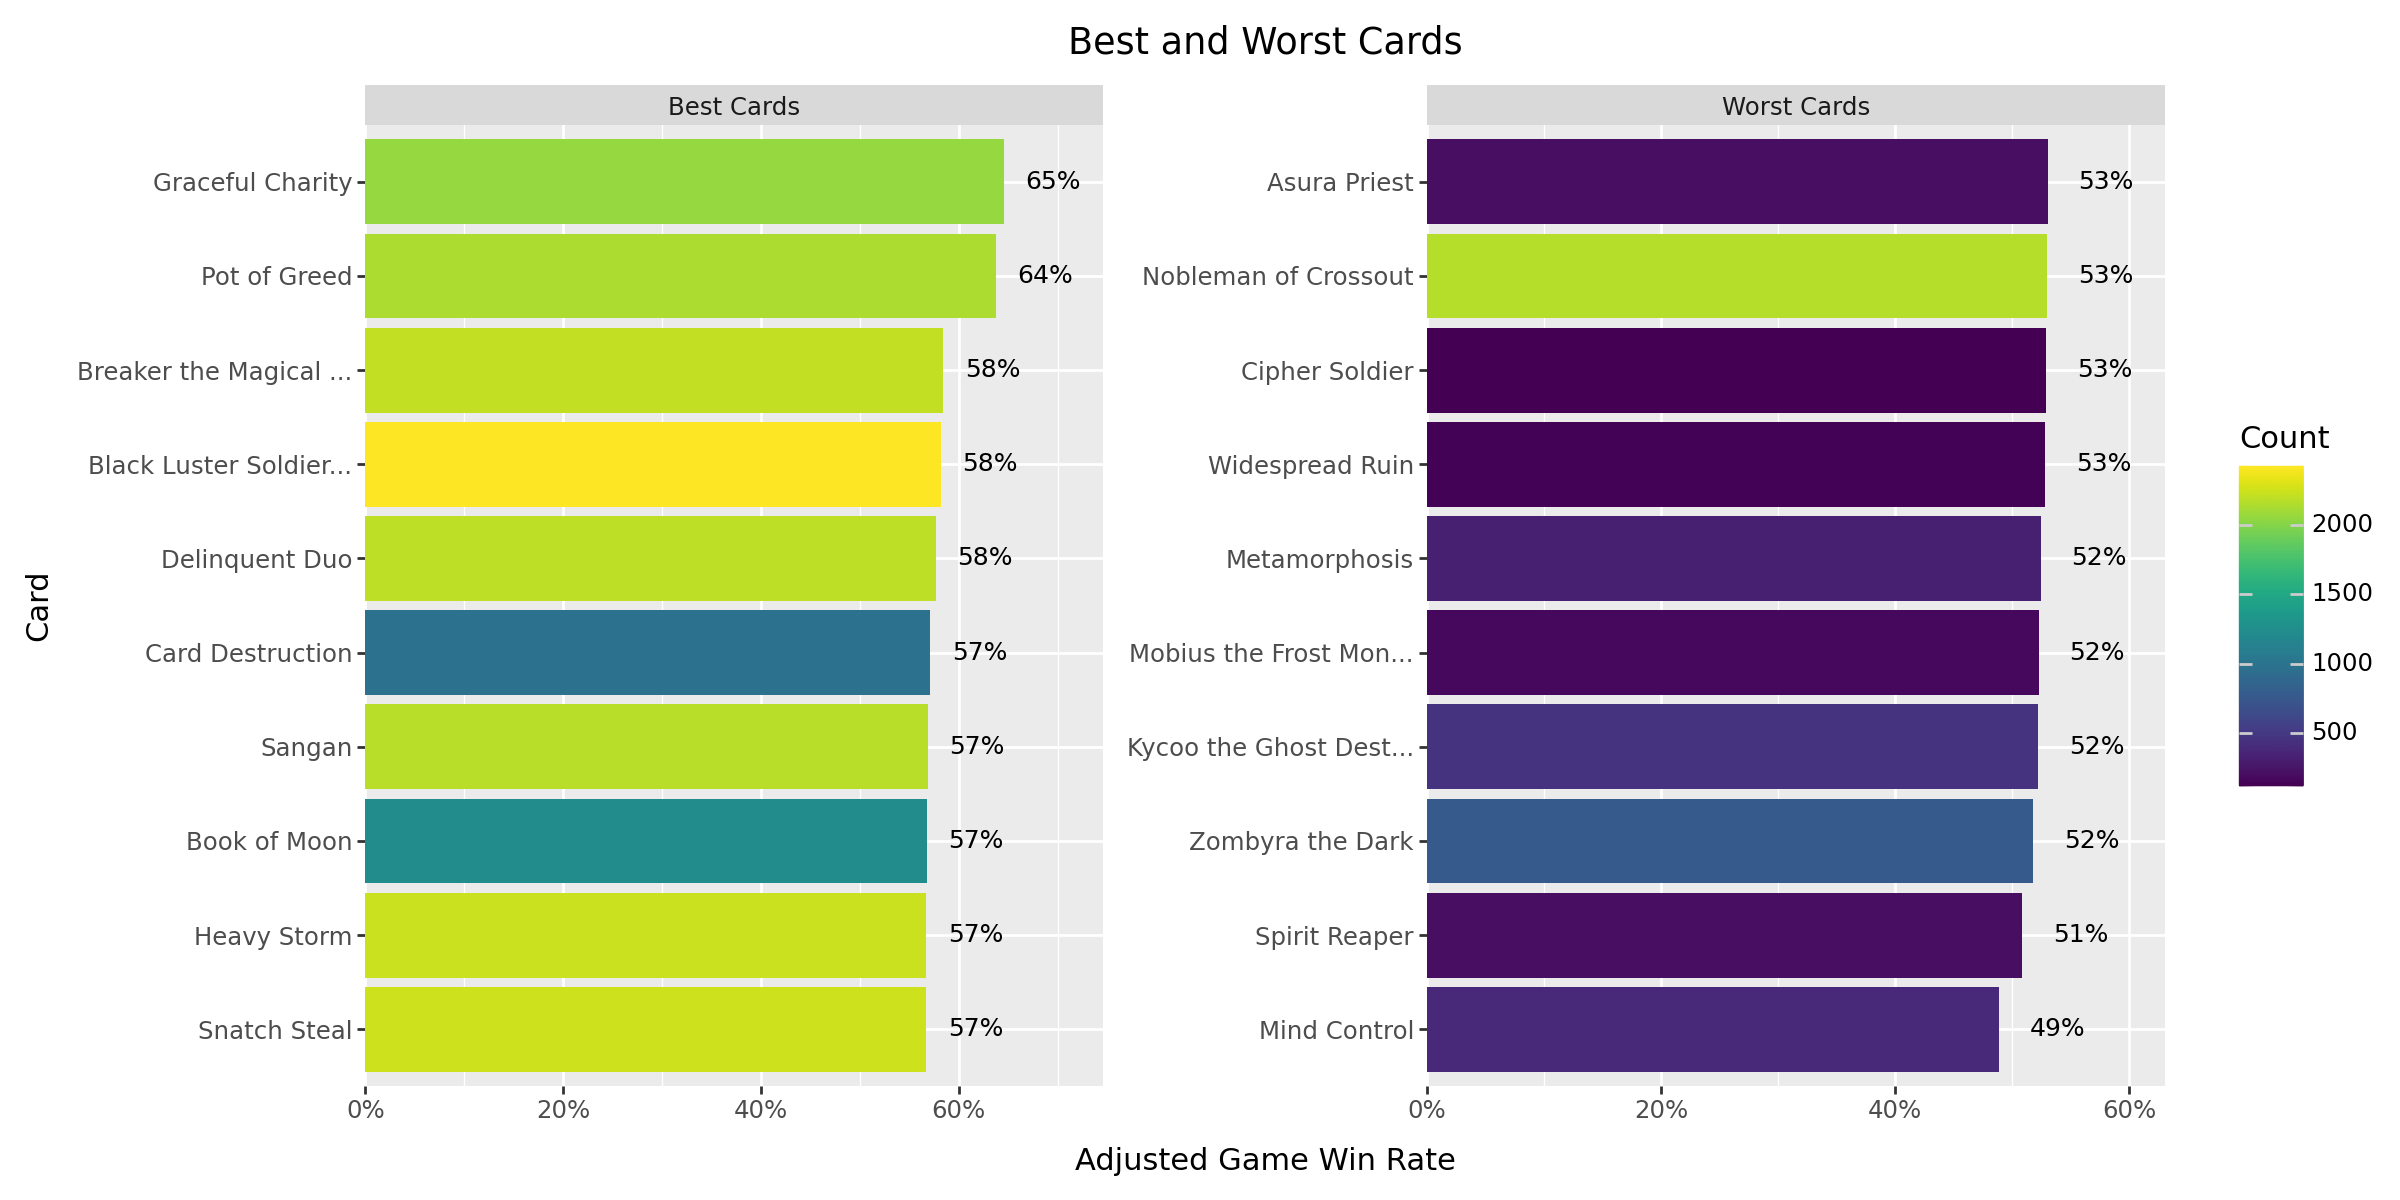

In [480]:
cta_bawc_base_df = (
    final_cards_df
    .filter(pl.col("player_match_deck_type") == "Chaos Turbo", pl.col("opp_match_deck_type") != "Chaos Turbo")
    .group_by("player_card_name")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .filter(pl.col("count") > 100)
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], K=250),
            return_dtype=float
        )
    )
    .sort("adj_win_rate")
)

cta_bawc_plot_df = pl.concat([
    cta_bawc_base_df
        .top_k(10, by="adj_win_rate")
        .with_columns(group=pl.lit("Best Cards")),
    cta_bawc_base_df
        .top_k(10, by="adj_win_rate", reverse=True)
        .with_columns(group=pl.lit("Worst Cards"))
])

(
    ggplot(
        cta_bawc_plot_df,
        aes(x="reorder(player_card_name, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.0f}%",
        nudge_y=5,
        size=9
    )
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in x])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 5)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Best and Worst Cards",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6)
    )
)

### Best Cards Preside vs Postside

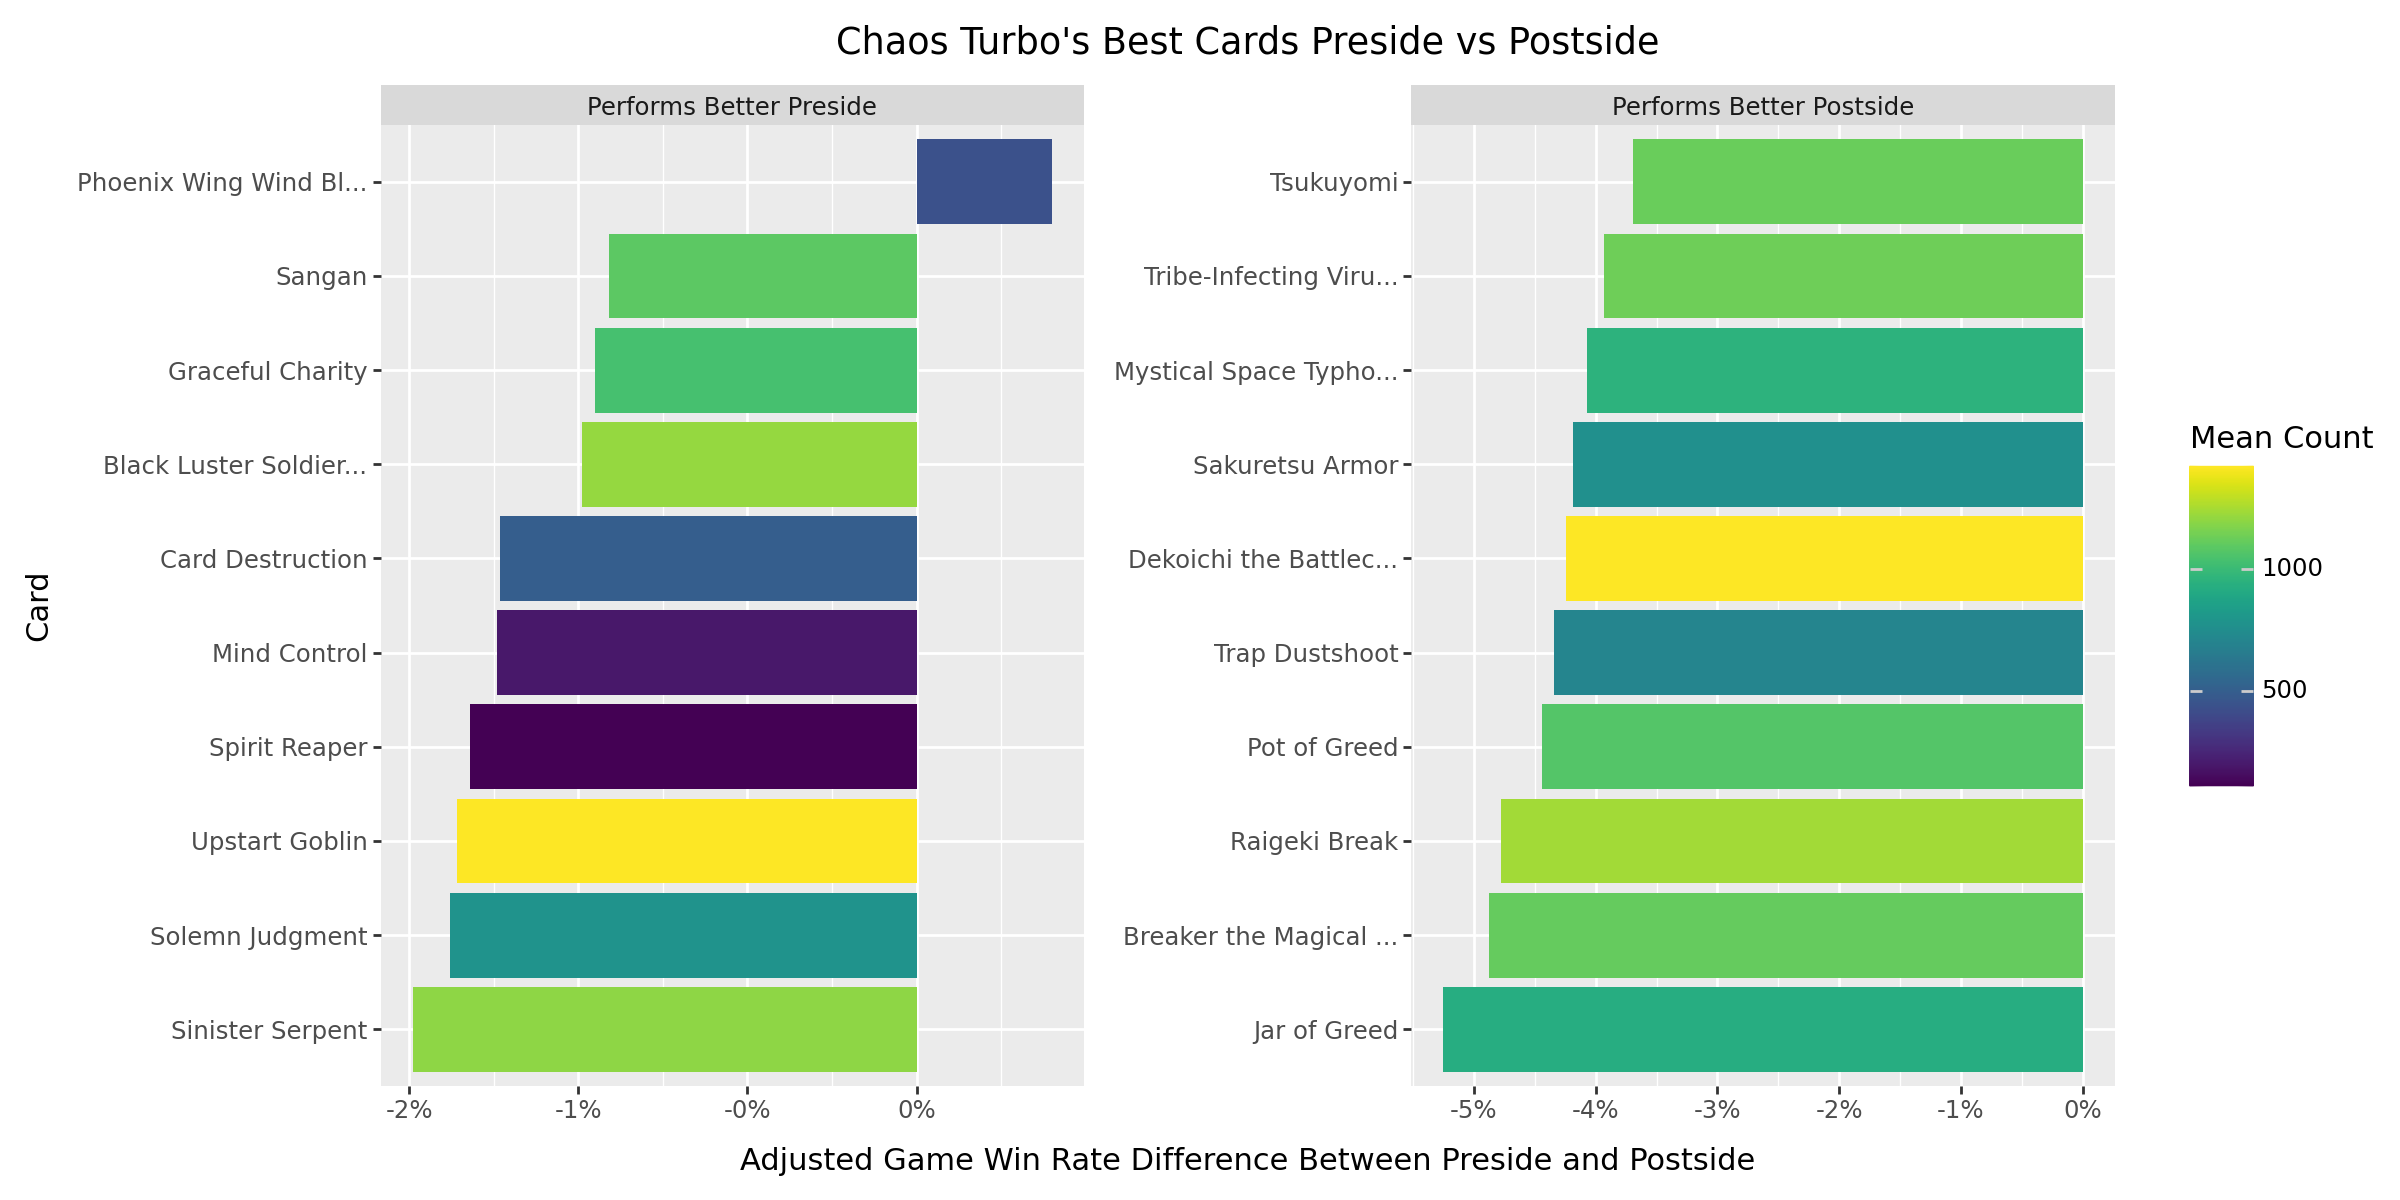

In [481]:
cta_bcpvp_base_df = (
    final_cards_df
    .filter(pl.col("player_match_deck_type") == "Chaos Turbo", pl.col("opp_match_deck_type") != "Chaos Turbo")
    .group_by("player_card_name", "side_type")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .filter(pl.col("count") > 50)
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], K=250),
            return_dtype=float
        )
    )
    .pivot(
        on="side_type",
        index="player_card_name",
        values=["count", "adj_win_rate"]
    )
    .drop_nulls()
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_pvp_diff=pl.col("adj_win_rate_preside") - pl.col("adj_win_rate_postside")
    )
)


cta_bcpvp_plot_df = reorder_within(
    pl.concat([
        cta_bcpvp_base_df
            .top_k(10, by="wr_pvp_diff")
            .with_columns(group=pl.lit("Performs Better Preside")),
        cta_bcpvp_base_df
            .top_k(10, by="wr_pvp_diff", reverse=True)
            .with_columns(group=pl.lit("Performs Better Postside"))
    ]),
    x="player_card_name",
    by="wr_pvp_diff",
    within="group"
).to_pandas()

cta_bcpvp_plot_df["group"] = pd.Categorical(
    values=[value for value in cta_bcpvp_plot_df["group"]],
    categories=["Performs Better Preside", "Performs Better Postside"],
    ordered=True
)

(
    ggplot(
        cta_bcpvp_plot_df,
        aes(x="reorder(player_card_name_ordered, wr_pvp_diff)", y="wr_pvp_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x]
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo's Best Cards Preside vs Postside",
        x="Card",
        y="Adjusted Game Win Rate Difference Between Preside and Postside",
        fill="Mean Count"
    )
    + theme(
        figure_size=(12, 6)
    )
)

### Warrior Matchup

#### Match Win Rate

In [ ]:
cta_wm_mwr_base_df = (
    final_cards_df
    .filter(pl.col("player_match_deck_type") == "Chaos Turbo", pl.col("opp_match_deck_type") == "Warrior")
    .select("replay_url", "season", "game_number", "player_card_name", "opp_cards", "side_type", "player_went_first", cs.contains("won"))
    .sort(["replay_url", "game_number"])
)

print(
    cta_wm_mwr_base_df
    .unique(["replay_url", "player_won_match"])
    .select(
        pl.col("player_won_match").sum().alias("win"),
        pl.len().alias("count")
    )
    .with_columns(
        win_rate=((pl.col("win")/pl.col("count"))*100).round(2),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
)

shape: (1, 4)
┌─────┬───────┬──────────┬──────────────┐
│ win ┆ count ┆ win_rate ┆ adj_win_rate │
│ --- ┆ ---   ┆ ---      ┆ ---          │
│ u32 ┆ u32   ┆ f64      ┆ f64          │
╞═════╪═══════╪══════════╪══════════════╡
│ 363 ┆ 715   ┆ 50.77    ┆ 50.72        │
└─────┴───────┴──────────┴──────────────┘


#### Match Win Rate Across Seasons

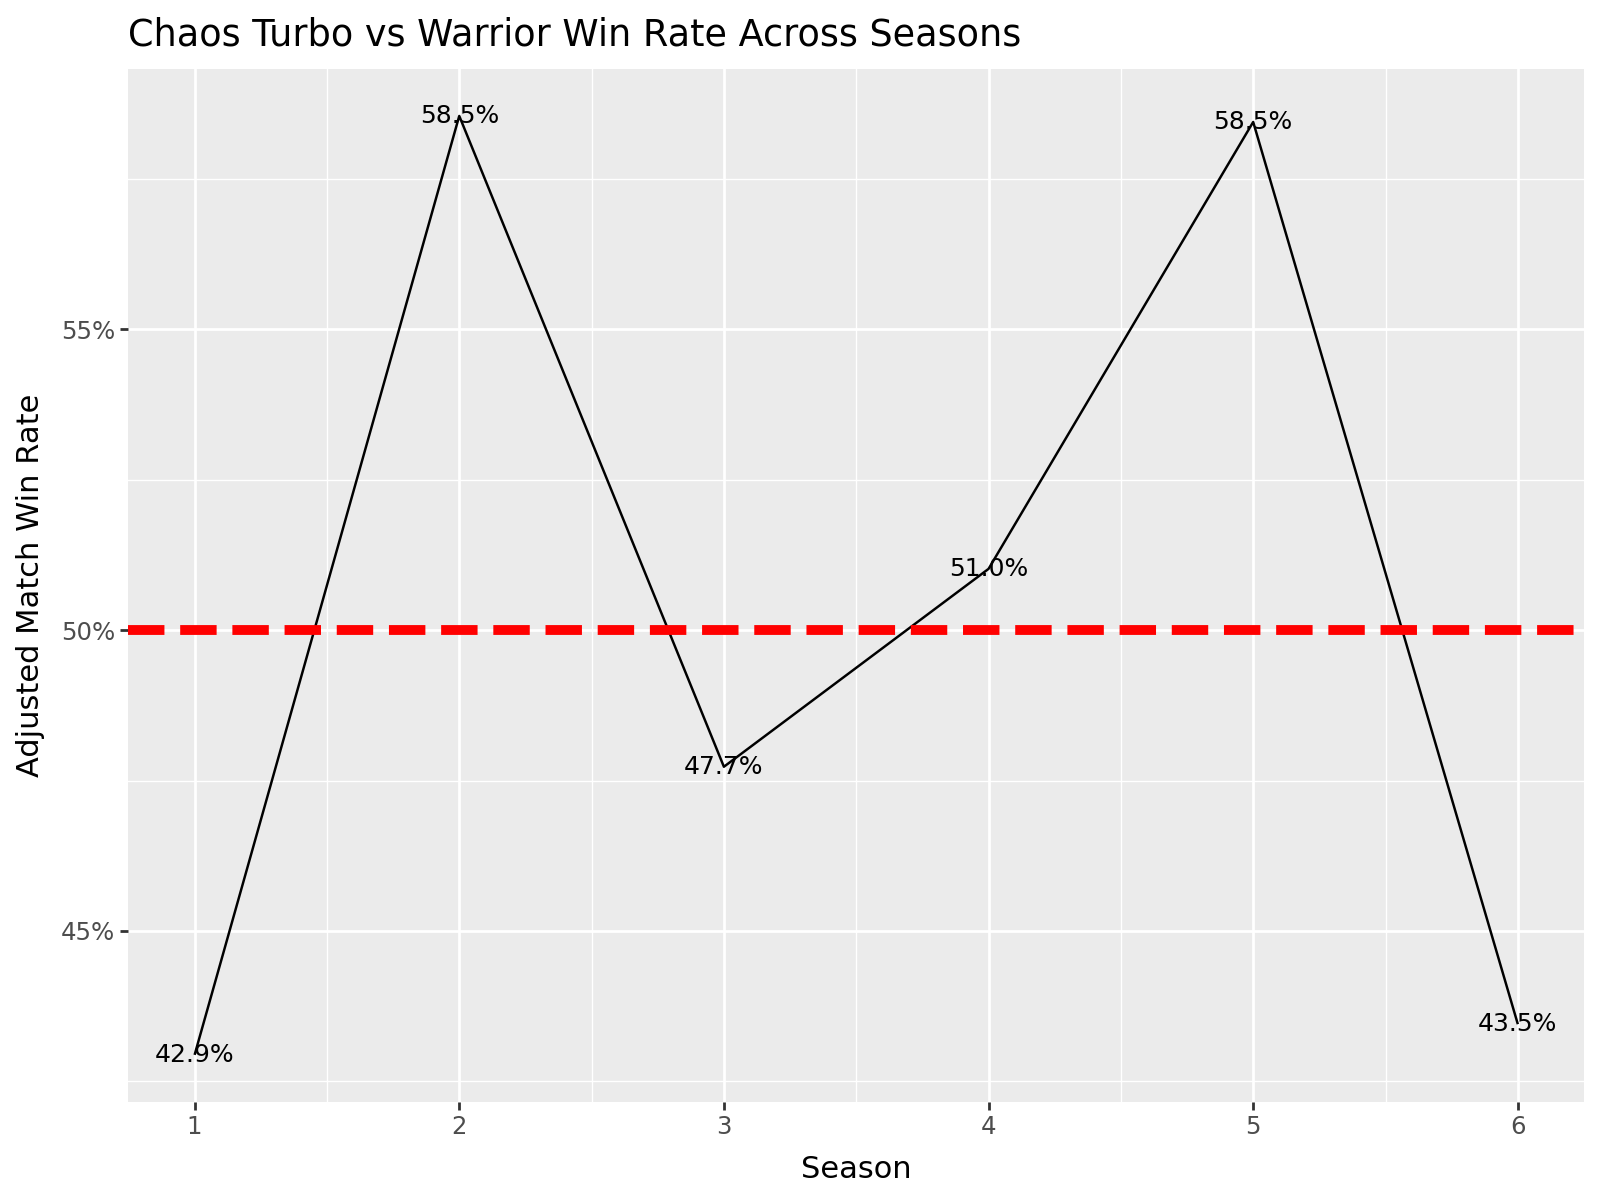

In [ ]:
cta_wm_mwras_plot_df = (
    cta_wm_mwr_base_df
    .unique(["replay_url", "player_won_match"])
    .group_by("season")
    .agg(
        win=pl.col("player_won_match").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
)

(
    ggplot(
        cta_wm_mwras_plot_df,
        aes(x="season", y="adj_win_rate")
    )
    + geom_line()
    + geom_hline(yintercept=50, size=2, color="red", linetype="dashed")
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.1f}%",
        size=9
    )
    + scale_x_continuous(breaks=range(1, 7))
    + scale_y_continuous(labels=lambda x: [f"{label:.0f}%" for label in x])
    + labs(
        title="Chaos Turbo vs Warrior Win Rate Across Seasons",
        x="Season",
        y="Adjusted Match Win Rate"
    )
    + theme(
        figure_size=(8, 6),
        plot_title=element_text(ha="left")
    )
    
)

#### Game Win Rate

In [ ]:
print(
    final_cards_df
    .filter(pl.col("player_match_deck_type") == "Chaos Turbo", pl.col("opp_match_deck_type") == "Warrior")
    .unique(["replay_url", "game_number"])
    .group_by("game_number")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .filter(pl.col("game_number") <= 3)
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
    .sort("game_number")
)

shape: (3, 4)
┌─────────────┬─────┬───────┬──────────────┐
│ game_number ┆ win ┆ count ┆ adj_win_rate │
│ ---         ┆ --- ┆ ---   ┆ ---          │
│ i64         ┆ u32 ┆ u32   ┆ f64          │
╞═════════════╪═════╪═══════╪══════════════╡
│ 1           ┆ 303 ┆ 715   ┆ 42.88        │
│ 2           ┆ 397 ┆ 712   ┆ 55.38        │
│ 3           ┆ 239 ┆ 468   ┆ 50.97        │
└─────────────┴─────┴───────┴──────────────┘


#### Game Win Rate Across Seasons

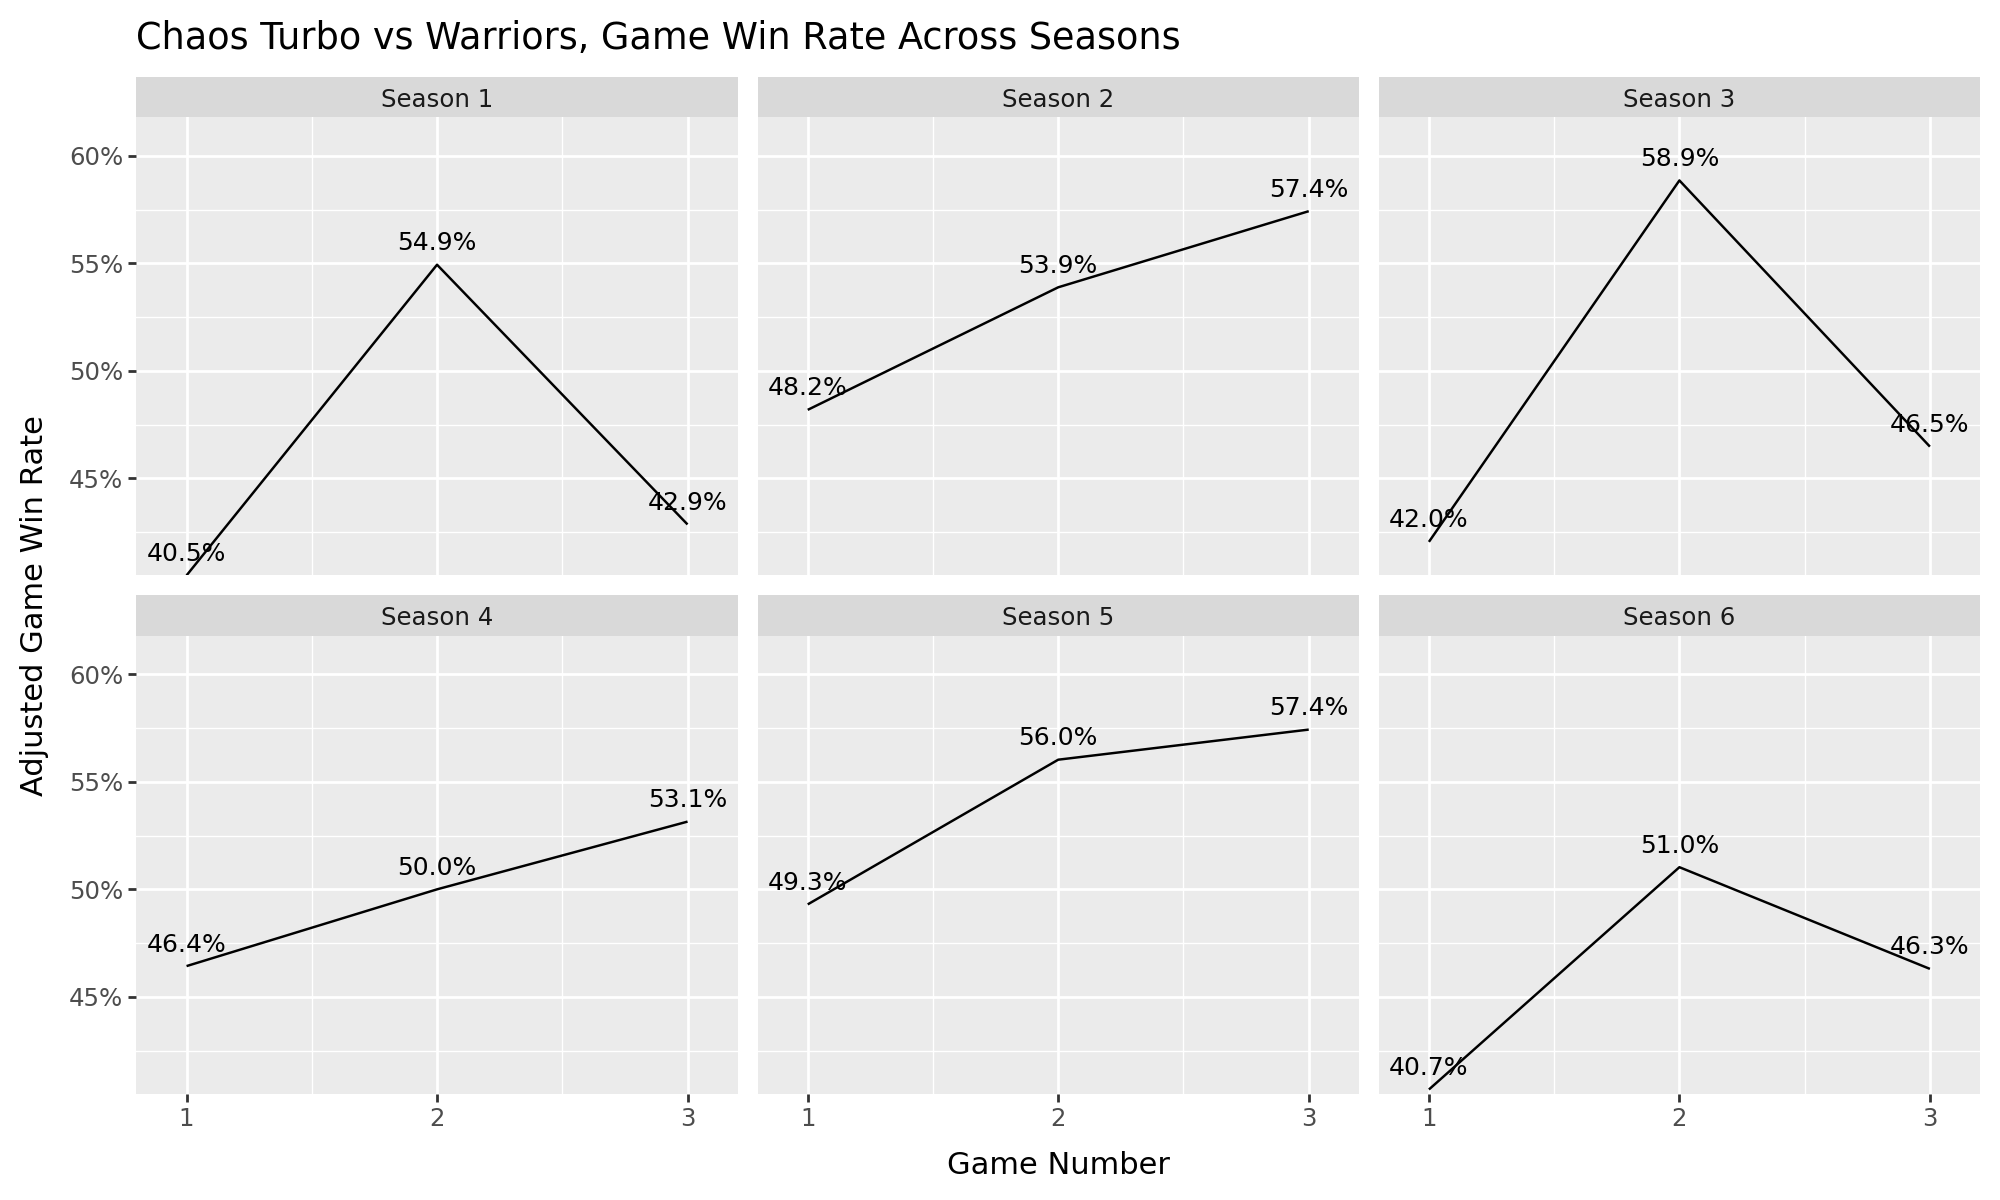

In [ ]:
cta_wm_gwras_plot_df = (
    final_cards_df
    .filter(
        pl.col("player_match_deck_type") == "Chaos Turbo", 
        pl.col("opp_match_deck_type") == "Warrior",
        pl.col("game_number") <= 3
    )
    .unique(["replay_url", "game_number"])
    .group_by("season", "game_number")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        season=pl.concat_str(pl.lit("Season "), pl.col("season")),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
    .sort("adj_win_rate")
)

(
    ggplot(
        cta_wm_gwras_plot_df,
        aes(x="game_number", y="adj_win_rate")
    )
    + geom_line()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.1f}%",
        nudge_y=1,
        size=9
    )
    + scale_x_continuous(
        breaks=range(1, 4),
        labels=range(1, 4),
        expand=(.1, 0)
    )
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, .1, 0)
    )
    + facet_wrap("season")
    + labs(
        title="Chaos Turbo vs Warriors, Game Win Rate Across Seasons",
        x="Game Number",
        y="Adjusted Game Win Rate"
    )
    + theme(
        figure_size=(10, 6),
        plot_title=element_text(ha="left")
    )
)

#### Game Win Rate Preside vs Postside

In [ ]:
print(
    final_cards_df
    .filter(
        pl.col("player_match_deck_type") == "Chaos Turbo",
        pl.col("opp_match_deck_type") == "Warrior"
    )
    .unique(["replay_url", "game_number"])
    .select("replay_url", "player_won", "side_type")
    .group_by("side_type")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
)

shape: (2, 4)
┌───────────┬─────┬───────┬──────────────┐
│ side_type ┆ win ┆ count ┆ adj_win_rate │
│ ---       ┆ --- ┆ ---   ┆ ---          │
│ str       ┆ u32 ┆ u32   ┆ f64          │
╞═══════════╪═════╪═══════╪══════════════╡
│ postside  ┆ 638 ┆ 1186  ┆ 53.64        │
│ preside   ┆ 303 ┆ 715   ┆ 42.88        │
└───────────┴─────┴───────┴──────────────┘


#### Best and Worst Cards

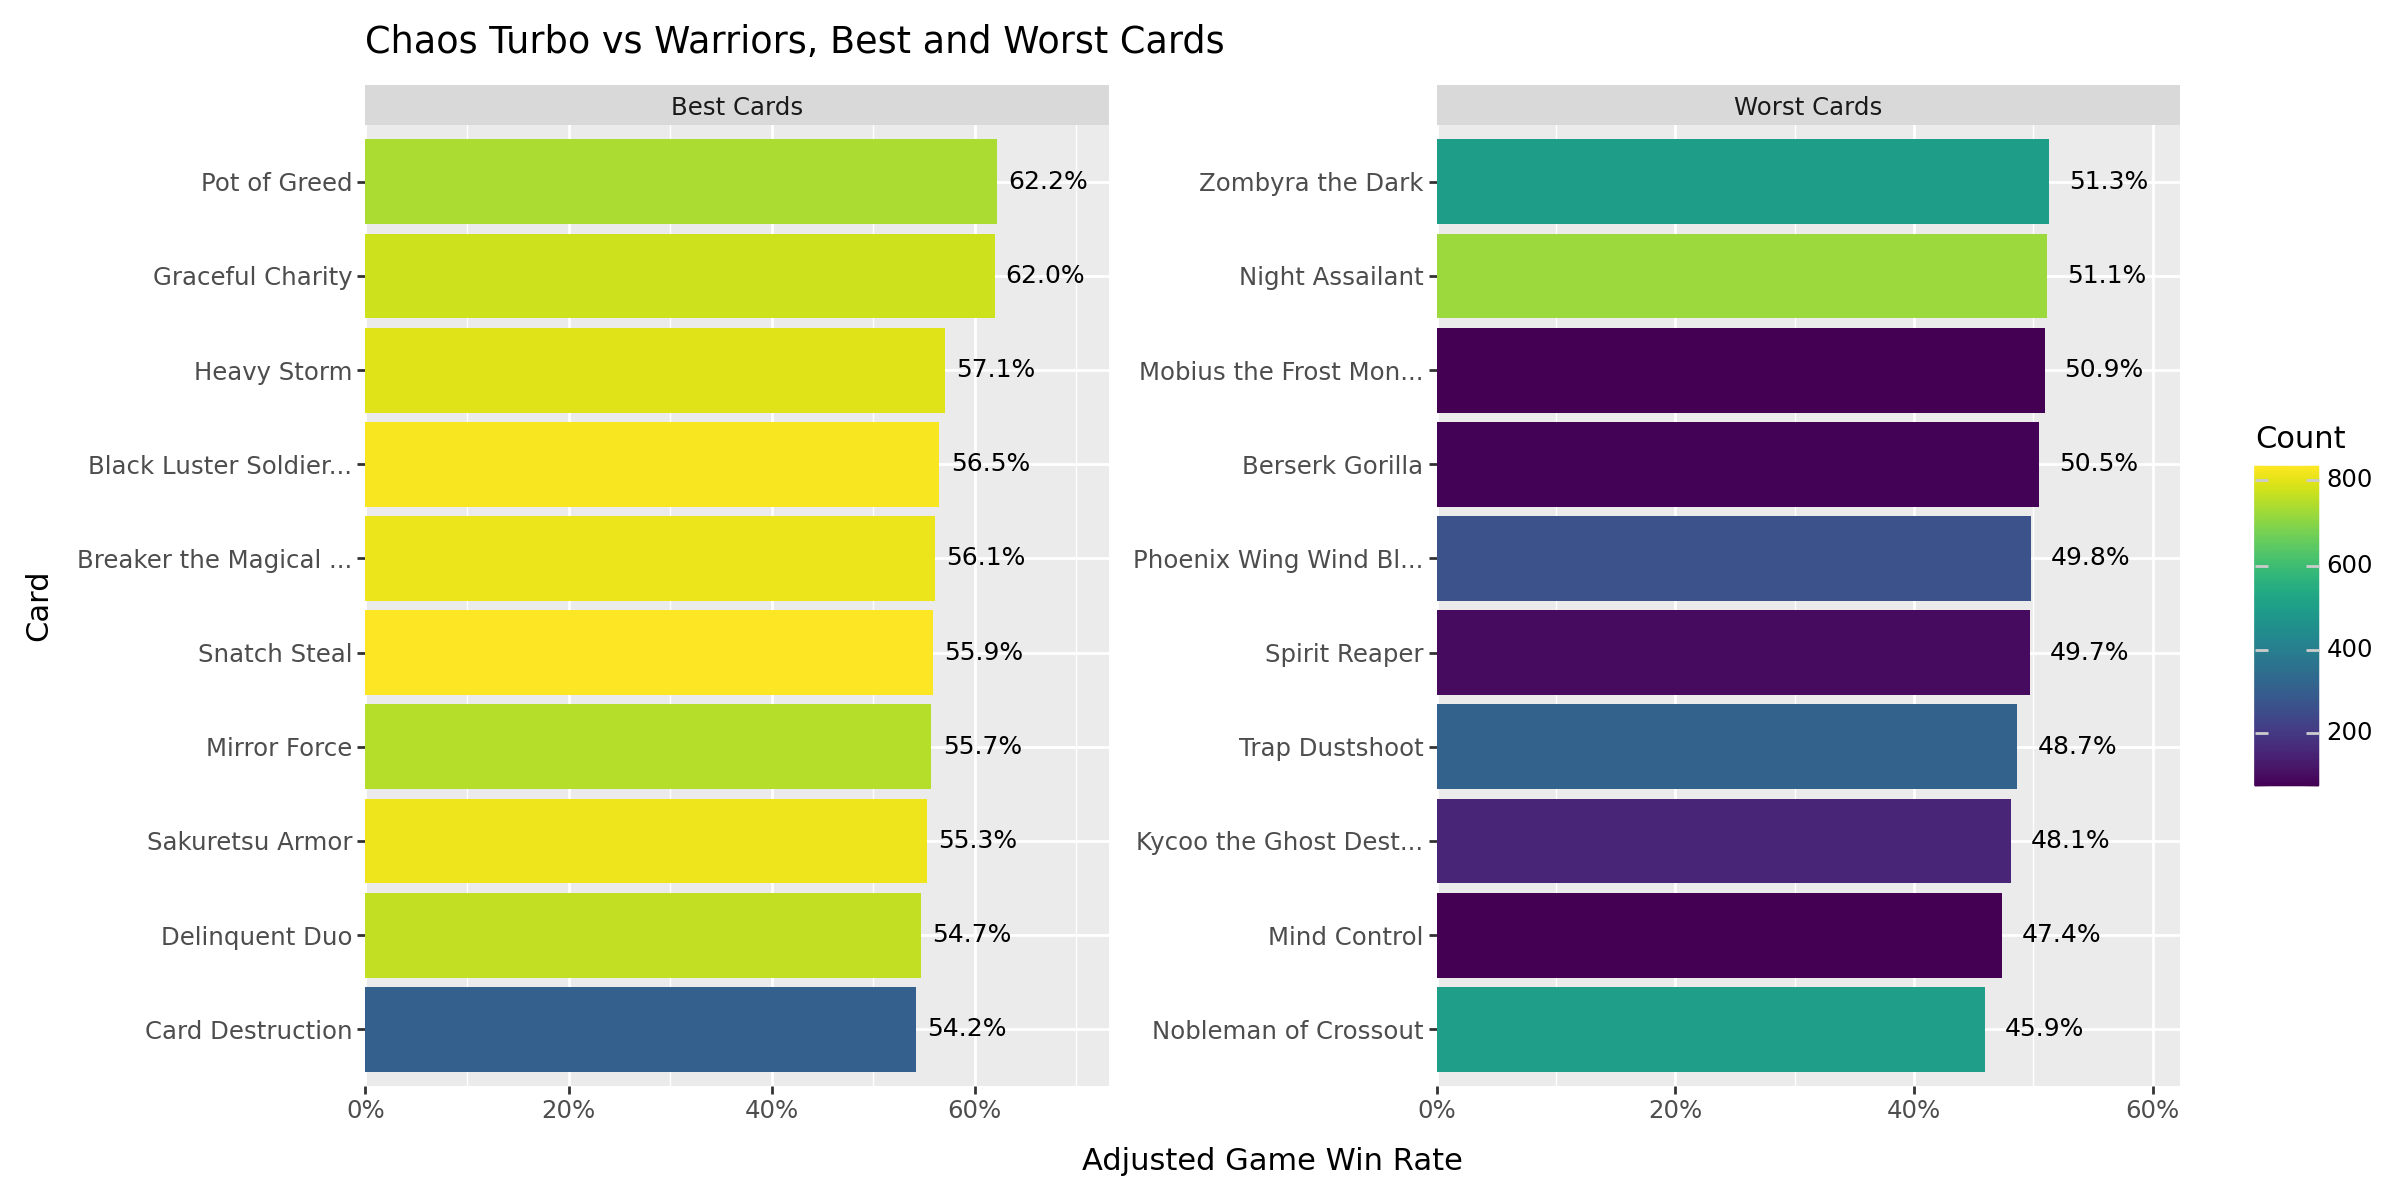

In [487]:
cta_wm_bawc_base_df = (
    final_cards_df
    .filter(
        pl.col("player_match_deck_type") == "Chaos Turbo",
        pl.col("opp_match_deck_type") == "Warrior"
    )
    .group_by("player_card_name")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .filter(pl.col("count") >= 50)
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], K=250),
            return_dtype=float
        )
    )
    .sort("adj_win_rate")
)

cta_wm_bawc_plot_df = pl.concat([
    cta_wm_bawc_base_df
        .top_k(10, by="adj_win_rate")
        .with_columns(group=pl.lit("Best Cards")),
    cta_wm_bawc_base_df
        .top_k(10, by="adj_win_rate", reverse=True)
        .with_columns(group=pl.lit("Worst Cards")),
])

(
    ggplot(
        cta_wm_bawc_plot_df,
        aes(x="reorder(player_card_name, adj_win_rate)", y="adj_win_rate", fill="count")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate"),
        format_string="{:.1f}%",
        nudge_y=5,
        size=9
    )
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in x])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 6)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo vs Warriors, Best and Worst Cards",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

#### Best and Worst Cards Preside

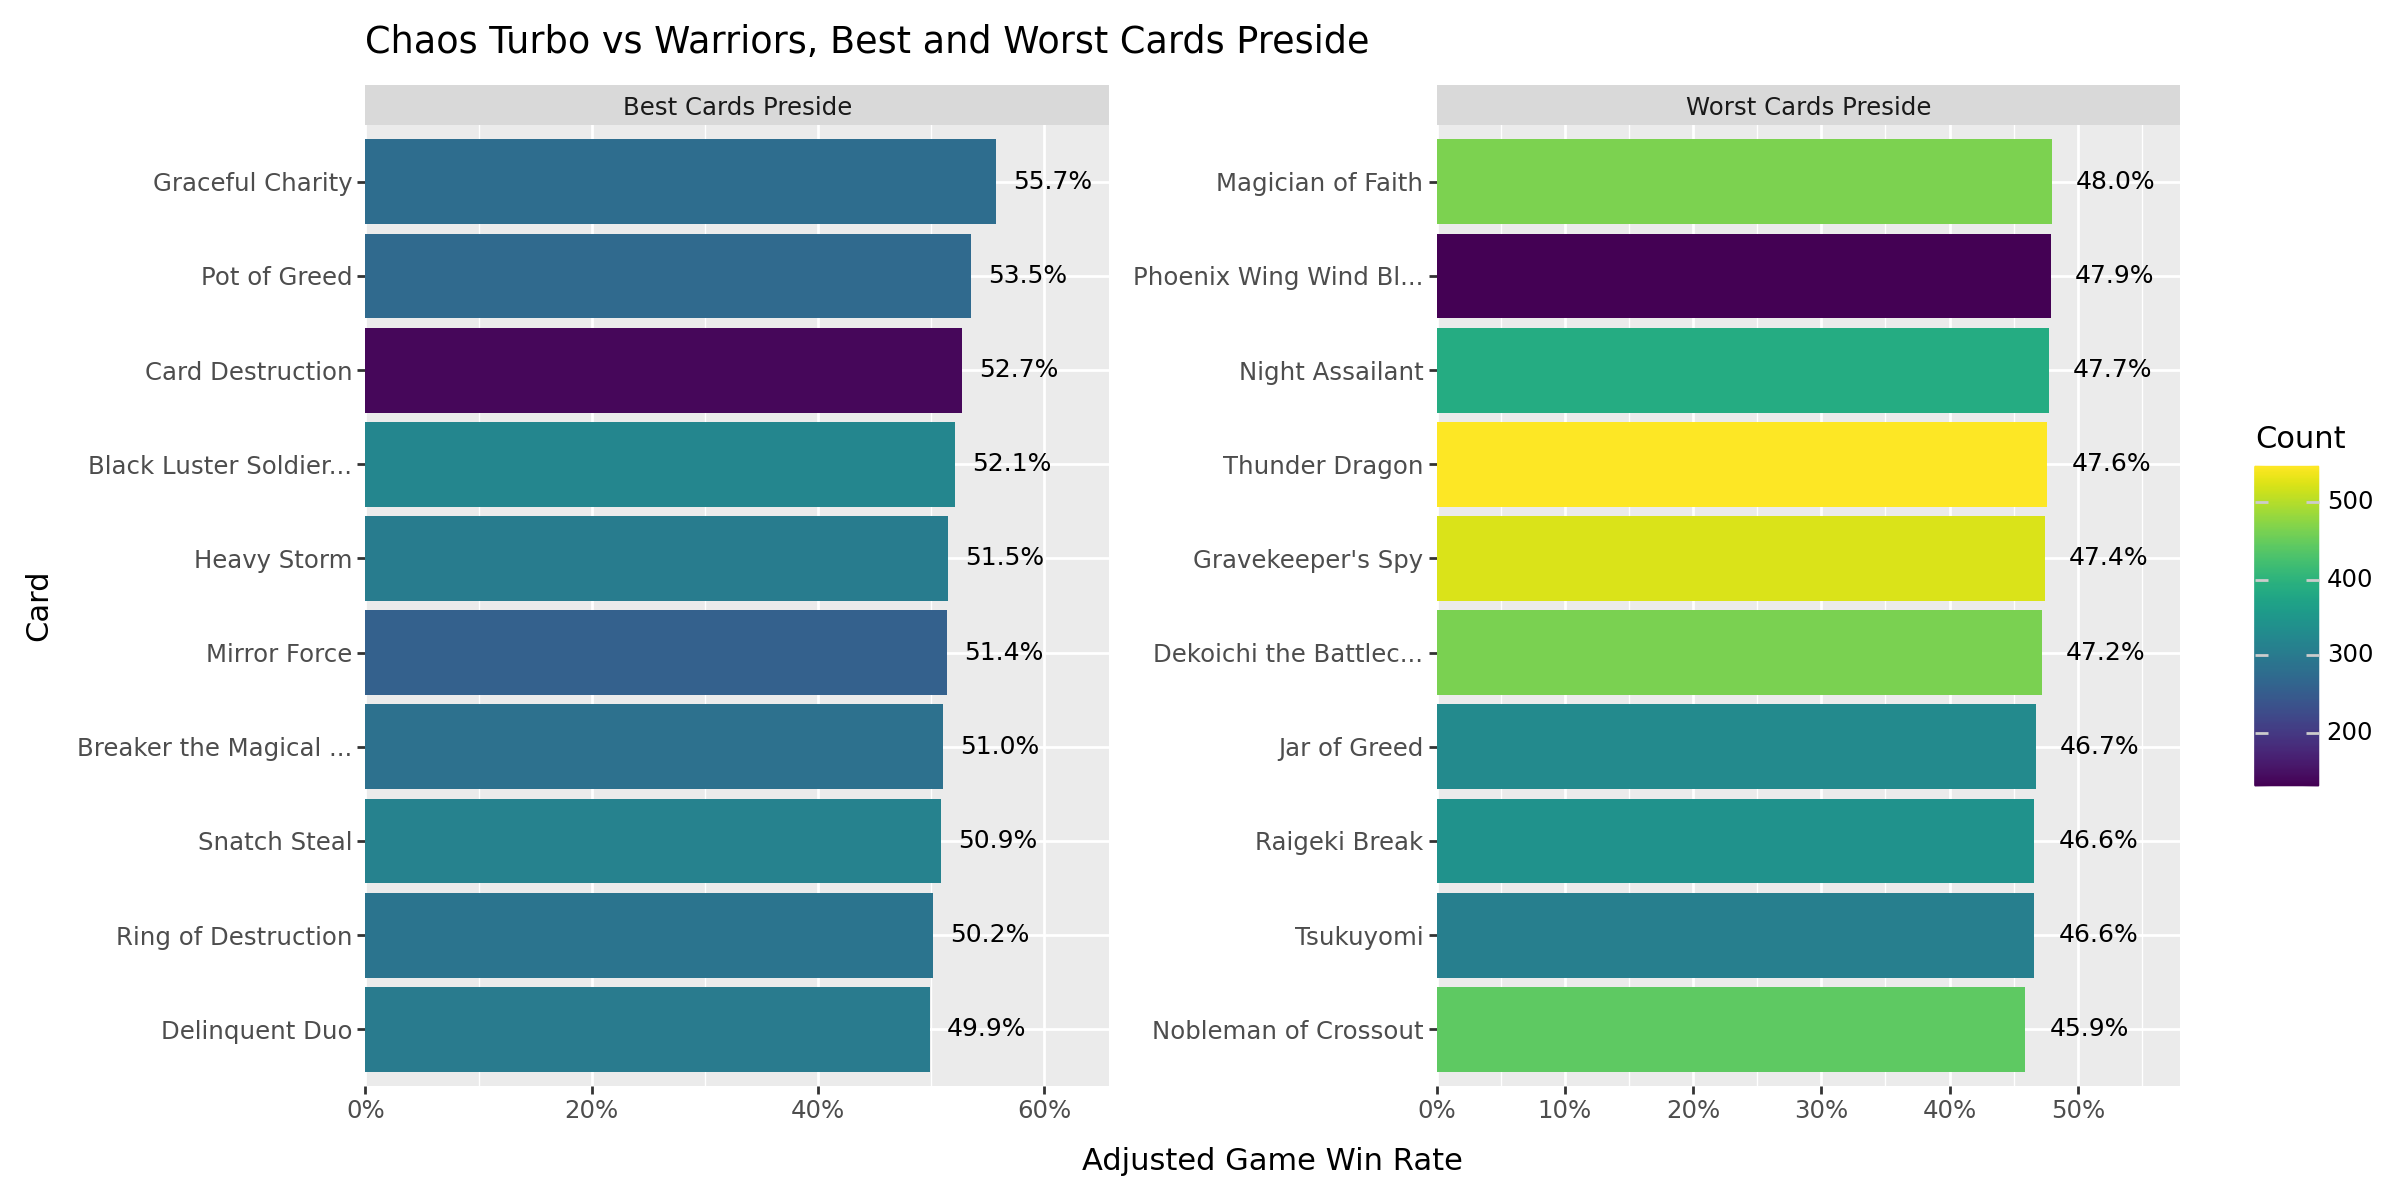

In [488]:
ct_mu_bawcpvp_base_df = (
    final_cards_df
    .filter(
        pl.col("player_match_deck_type") == "Chaos Turbo",
        pl.col("opp_match_deck_type") == "Warrior"
    )
    .group_by("side_type", "player_card_name")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .filter(pl.col("count") >= 50)
    .with_columns(
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"], K=250),
            return_dtype=float
        )
    )
    .pivot(
        on="side_type",
        index="player_card_name",
        values=["count", "adj_win_rate"]
    )
    .drop_nulls()
)

ct_mu_bawcpre_plot_df = reorder_within(
    pl.concat([
        ct_mu_bawcpvp_base_df
            .top_k(10, by="adj_win_rate_preside")
            .with_columns(group=pl.lit("Best Cards Preside")),
        ct_mu_bawcpvp_base_df
            .top_k(10, by="adj_win_rate_preside", reverse=True)
            .with_columns(group=pl.lit("Worst Cards Preside")),
    ]),
    x="player_card_name",
    by="adj_win_rate_preside",
    within="group"
)

(
    ggplot(
        ct_mu_bawcpre_plot_df,
        aes(x="reorder(player_card_name_ordered, adj_win_rate_preside)", y="adj_win_rate_preside", fill="count_preside")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate_preside"),
        format_string="{:.1f}%",
        nudge_y=5,
        size=9
    )
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 5)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo vs Warriors, Best and Worst Cards Preside",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

#### Best and Worst Cards Postside

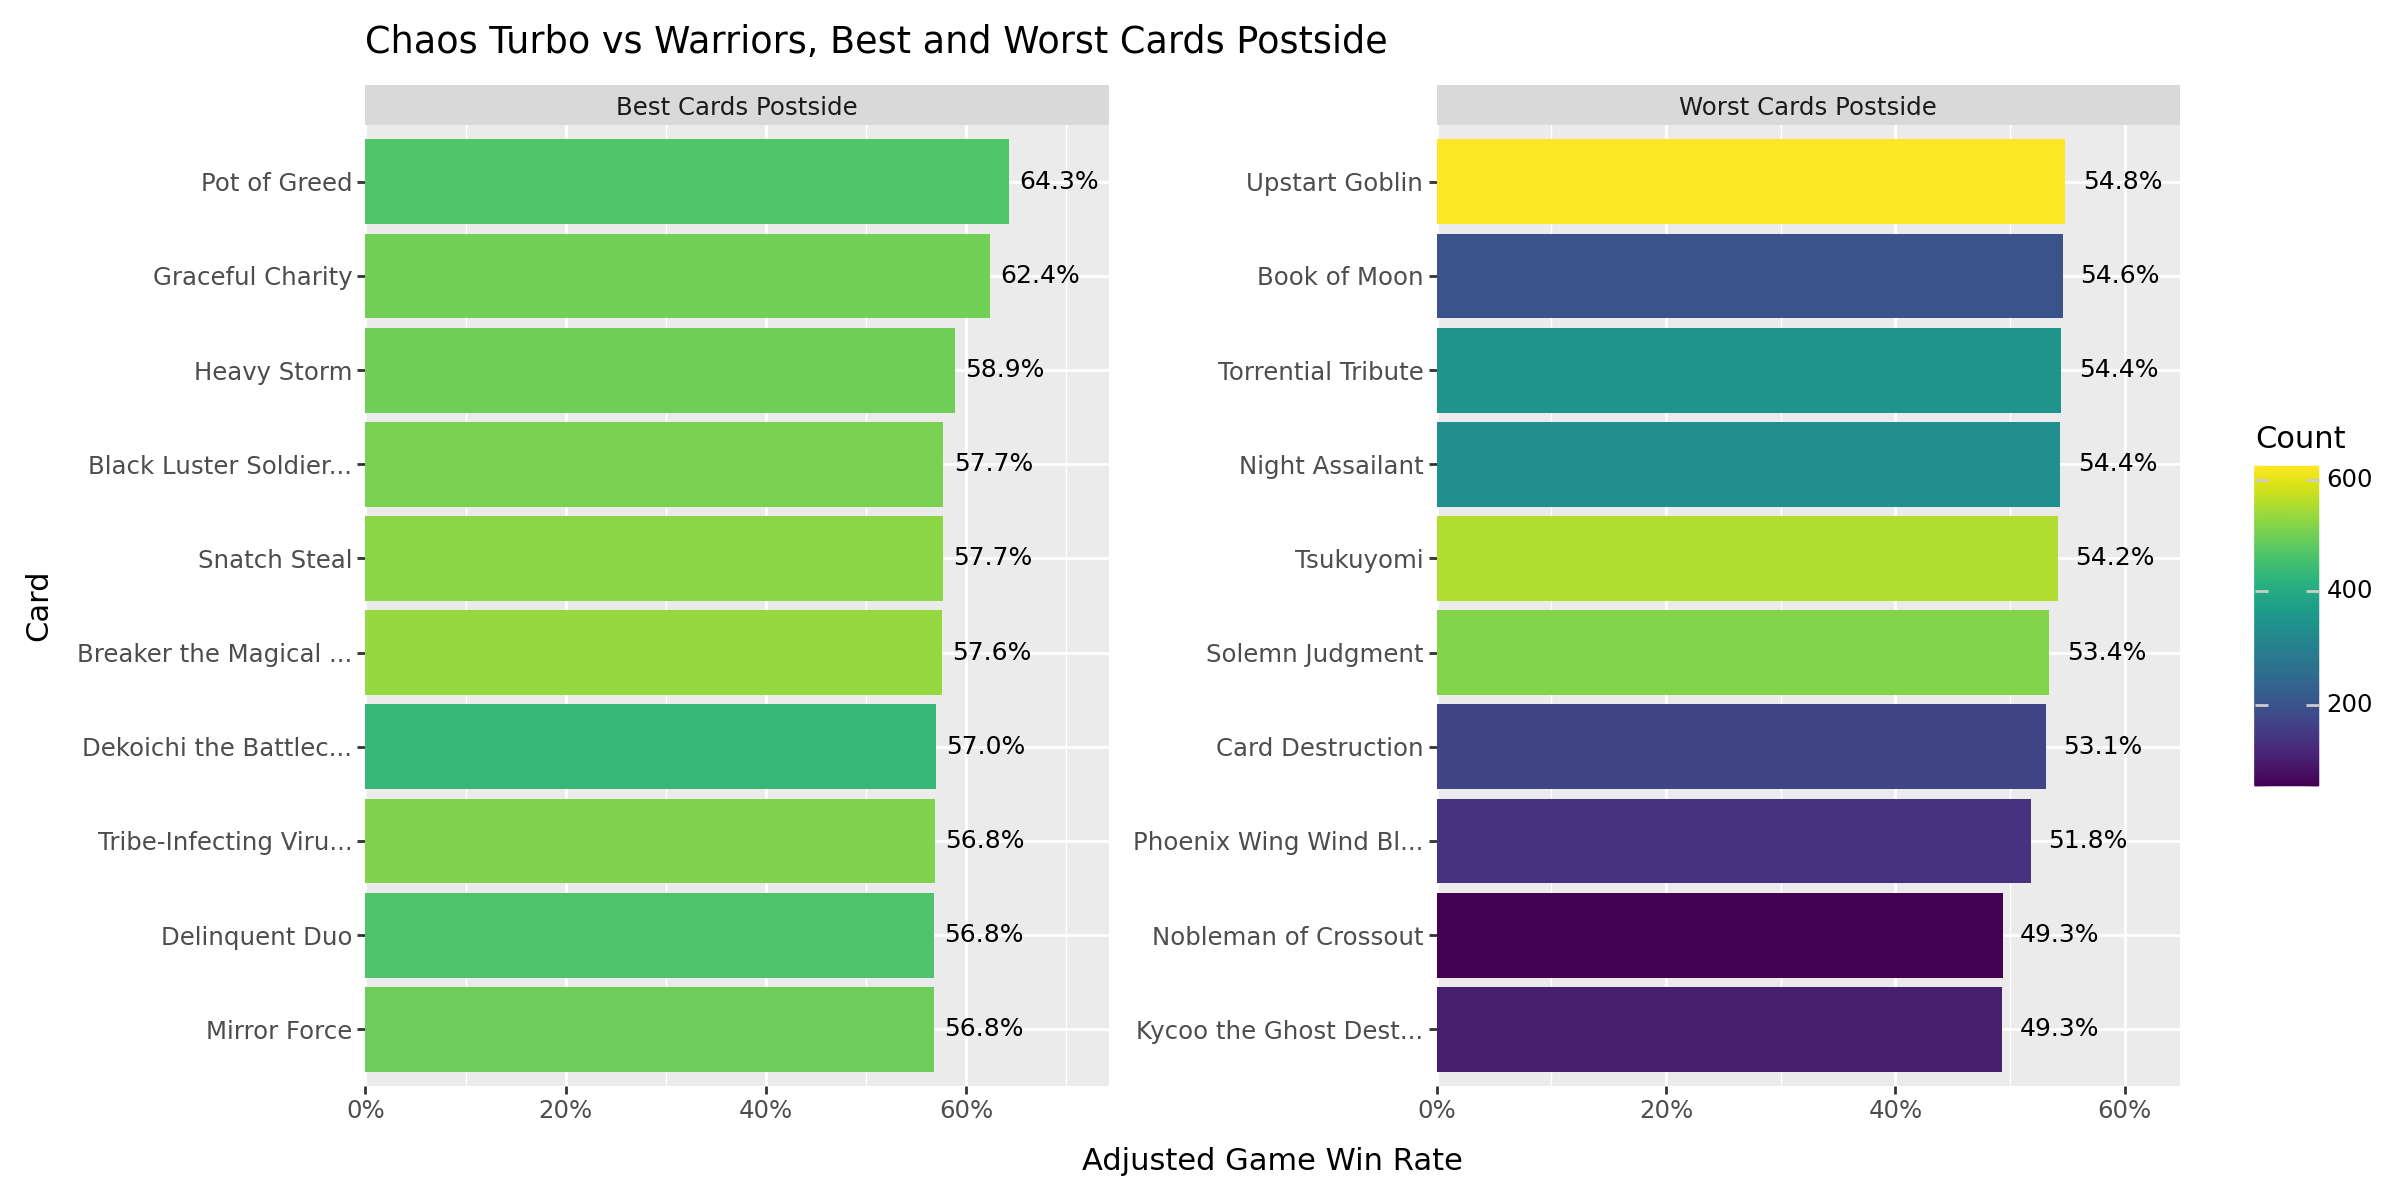

In [489]:
ct_mu_bawcpost_plot_df = reorder_within(
    pl.concat([
        ct_mu_bawcpvp_base_df
            .top_k(10, by="adj_win_rate_postside")
            .with_columns(group=pl.lit("Best Cards Postside")),
        ct_mu_bawcpvp_base_df
            .top_k(10, by="adj_win_rate_postside", reverse=True)
            .with_columns(group=pl.lit("Worst Cards Postside")),
    ]),
    x="player_card_name",
    by="adj_win_rate_postside",
    within="group"
)

(
    ggplot(
        ct_mu_bawcpost_plot_df,
        aes(x="reorder(player_card_name_ordered, adj_win_rate_postside)", y="adj_win_rate_postside", fill="count_postside")
    )
    + geom_col()
    + coord_flip()
    + geom_text(
        aes(label="adj_win_rate_postside"),
        format_string="{:.1f}%",
        nudge_y=5,
        size=9
    )
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x],
        expand=(0, 0, 0, 5)
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo vs Warriors, Best and Worst Cards Postside",
        x="Card",
        y="Adjusted Game Win Rate",
        fill="Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

#### Best Cards Preside vs Postside

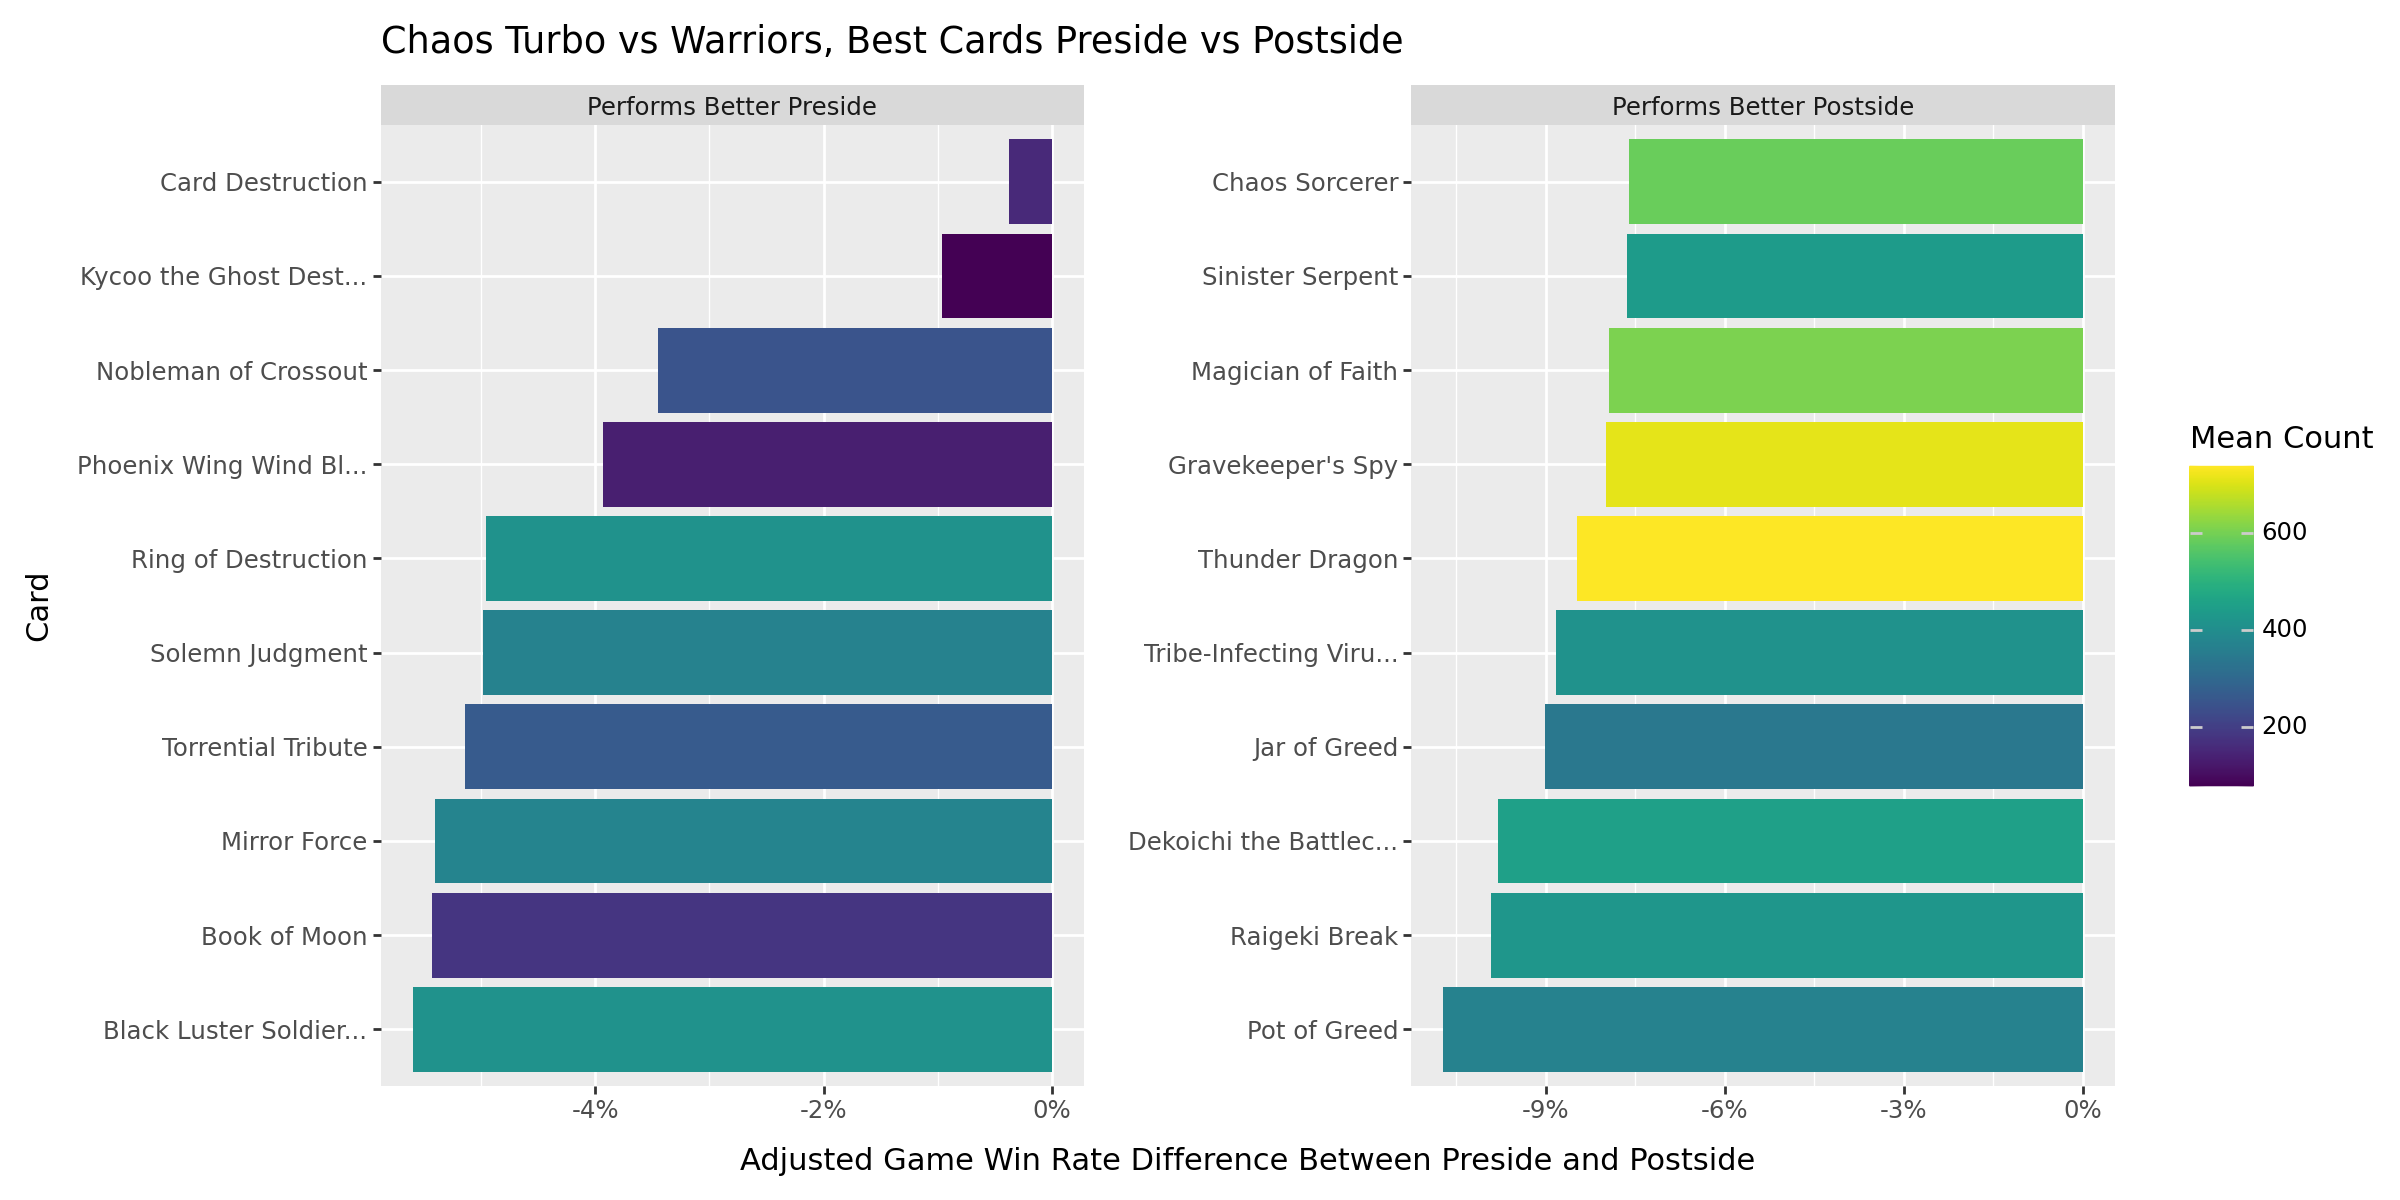

In [490]:
ct_mu_bcpvp_base_df = (
    ct_mu_bawcpvp_base_df
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_pvp_diff=pl.col("adj_win_rate_preside") - pl.col("adj_win_rate_postside")
    )
    .sort("wr_pvp_diff")
)

ct_mu_bcpvp_base_df

ct_mu_bcpvp_plot_df = reorder_within(
    pl.concat([
        ct_mu_bcpvp_base_df
            .top_k(10, by="wr_pvp_diff")
            .with_columns(group=pl.lit("Performs Better Preside")),
        ct_mu_bcpvp_base_df
            .top_k(10, by="wr_pvp_diff", reverse=True)
            .with_columns(group=pl.lit("Performs Better Postside"))
    ]),
    x="player_card_name",
    by="wr_pvp_diff",
    within="group"
).to_pandas()

ct_mu_bcpvp_plot_df["group"] = pd.Categorical(
    values=[value for value in ct_mu_bcpvp_plot_df["group"]],
    categories=["Performs Better Preside", "Performs Better Postside"],
    ordered=True
)

(
    ggplot(
        ct_mu_bcpvp_plot_df,
        aes(x="reorder(player_card_name_ordered, wr_pvp_diff)", y="wr_pvp_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x]
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo vs Warriors, Best Cards Preside vs Postside",
        x="Card",
        y="Adjusted Game Win Rate Difference Between Preside and Postside",
        fill="Mean Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)

### What Changed Between Season 5 and 6?

Chaos Turbo's postside cards performance differences.

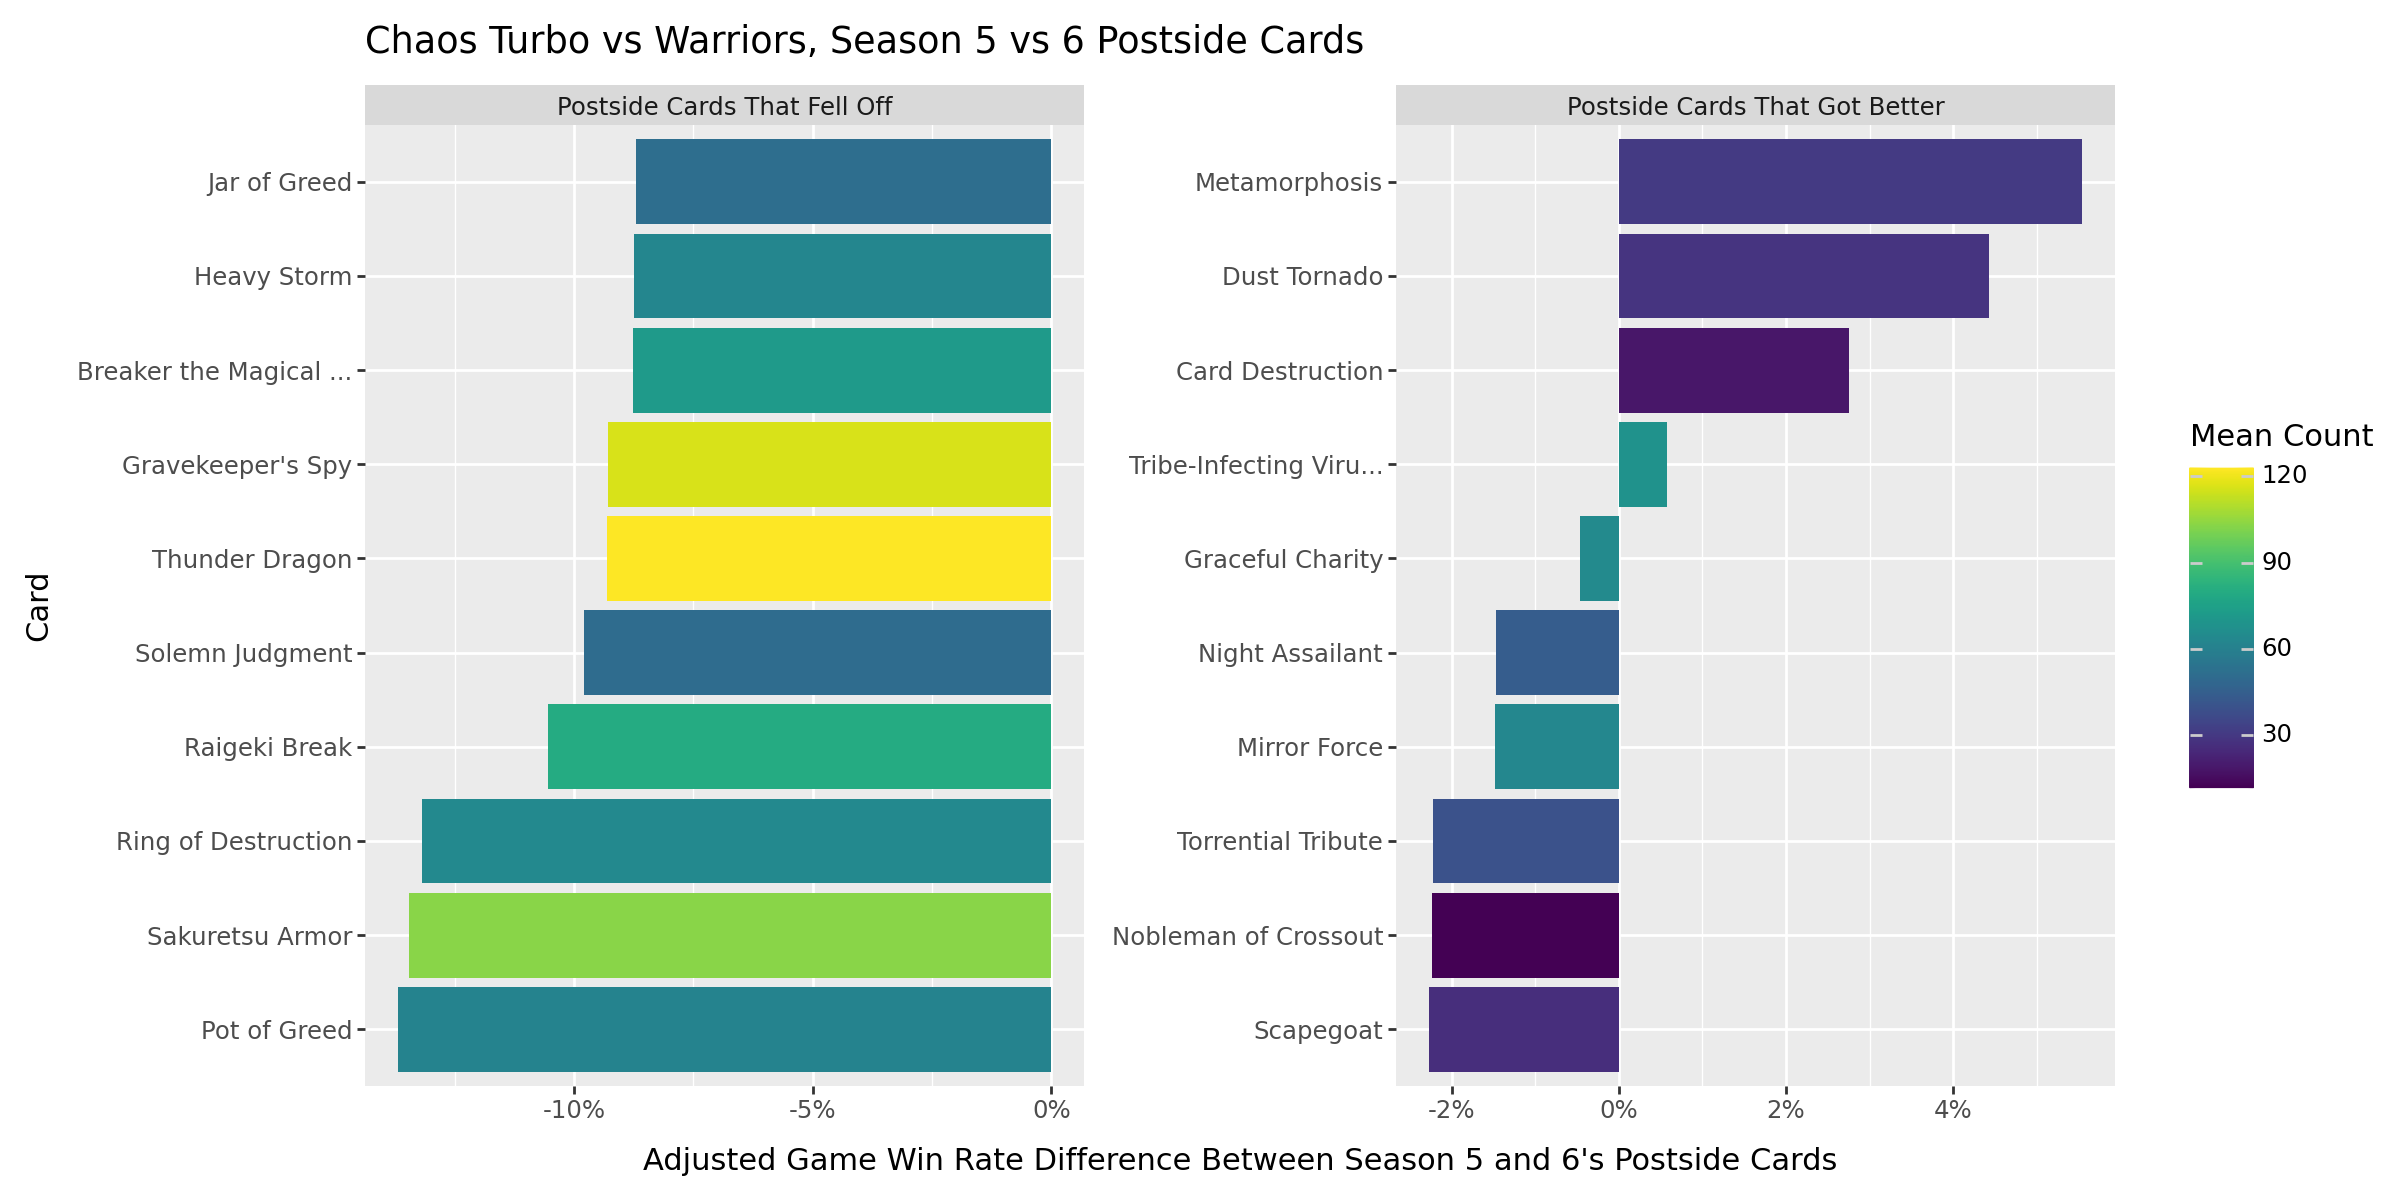

In [ ]:
ct_wm_wcbs56_base_df = (
    final_cards_df
    .filter(
        pl.col("player_match_deck_type") == "Chaos Turbo",
        pl.col("opp_match_deck_type") == "Warrior",
        pl.col("season").is_in([5, 6]),
        pl.col("side_type") == "postside"
    )
    .group_by("season", "player_card_name")
    .agg(
        win=pl.col("player_won").sum(),
        count=pl.len()
    )
    .with_columns(
        season=pl.concat_str(pl.lit("s"), pl.col("season")),
        adj_win_rate=pl.struct(pl.col("win"), pl.col("count")).map_elements(
            lambda row: adjusted_win_rate(row["win"], row["count"]),
            return_dtype=float
        )
    )
    .pivot(
        on="season",
        index="player_card_name",
        values=["count", "adj_win_rate"]
    )
    .drop_nulls()
    .with_columns(
        mean_count=pl.mean_horizontal(cs.contains("count")),
        wr_s56_diff=pl.col("adj_win_rate_s6") - pl.col("adj_win_rate_s5")
    )
    .filter(pl.col("mean_count") >= 10)
    .sort("wr_s56_diff")
)

ct_wm_wcbs56_plot_df = reorder_within(
    pl.concat([
        ct_wm_wcbs56_base_df
            .top_k(10, by="wr_s56_diff", reverse=True)
            .with_columns(group=pl.lit("Postside Cards That Fell Off")),
        ct_wm_wcbs56_base_df
            .top_k(10, by="wr_s56_diff")
            .with_columns(group=pl.lit("Postside Cards That Got Better"))
    ]),
    x="player_card_name",
    by="wr_s56_diff",
    within="group"
)

(
    ggplot(
        ct_wm_wcbs56_plot_df,
        aes(x="reorder(player_card_name_ordered, wr_s56_diff)", y="wr_s56_diff", fill="mean_count")
    )
    + geom_col()
    + coord_flip()
    + scale_x_discrete(labels=lambda x: [f"{label[:20]}..." if len(label) > 20 else label for label in remove_suffix(x)])
    + scale_y_continuous(
        labels=lambda x: [f"{label:.0f}%" for label in x]
    )
    + facet_wrap("group", scales="free")
    + labs(
        title="Chaos Turbo vs Warriors, Season 5 vs 6 Postside Cards",
        x="Card",
        y="Adjusted Game Win Rate Difference Between Season 5 and 6's Postside Cards",
        fill="Mean Count"
    )
    + theme(
        figure_size=(12, 6),
        plot_title=element_text(ha="left")
    )
)